<a href="https://www.kaggle.com/code/ghadaataoui/eeg-signal-processing?scriptVersionId=248813010" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pickle
import numpy as np
import os

def read_data(filename):
    with open(filename, 'rb') as f:
        x = pickle._Unpickler(f)
        x.encoding = 'latin1'
        data = x.load()
    return data

# List of participant file names
files = [f"{i:02}" for i in range(1, 33)]

labels = []
data = []

base_path = "/kaggle/input/deap-dataset/deap-dataset/data_preprocessed_python/"

for i in files:
    file_path = os.path.join(base_path, f"s{i}.dat")
    d = read_data(file_path)
    labels.append(d['labels'])
    data.append(d['data'])

Convertir les données au format tableau
Convert data to table format

In [2]:
labels = np.array(labels)
data = np.array(data)
print(labels.shape)
print(data.shape)

(32, 40, 4)
(32, 40, 40, 8064)


In [3]:
labels = labels.reshape(1280, 4)
data = data.reshape(1280, 40, 8064)
print(labels.shape)
print(data.shape)

(1280, 4)
(1280, 40, 8064)


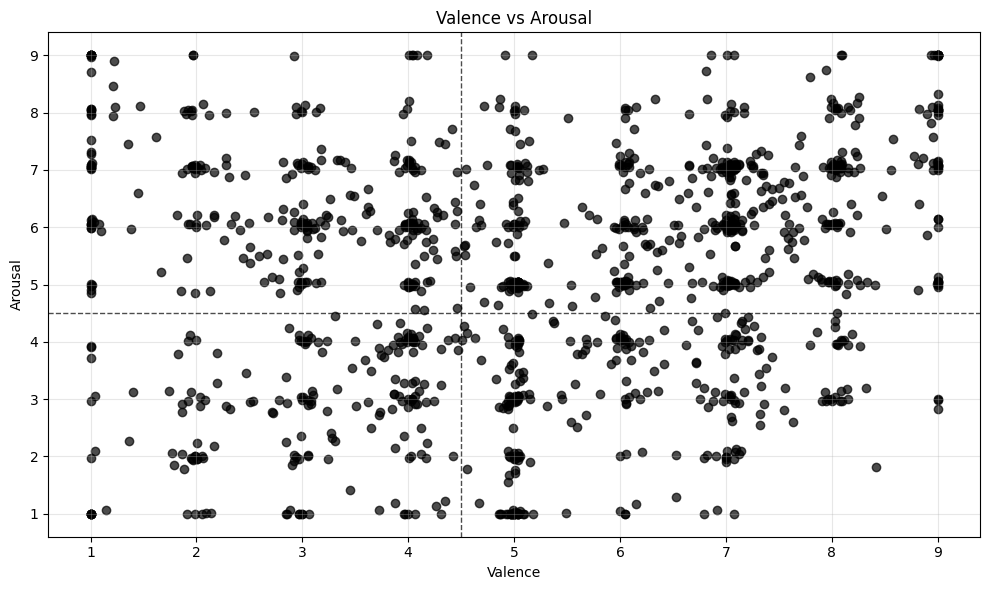

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/kaggle/input/deap-dataset/deap-dataset/Metadata/participant_ratings.xls'
data = pd.read_excel(file_path, index_col=0)

threshold = 4.5
data['Valence_Category'] = ['V+' if val > threshold else 'V-' for val in data['Valence']]
data['Arousal_Category'] = ['A+' if ar > threshold else 'A-' for ar in data['Arousal']]

data['Category'] = data['Arousal_Category'] + ', ' + data['Valence_Category']

# Plot
plt.figure(figsize=(10, 6))

# Scatter plot with black points
plt.scatter(data['Valence'], data['Arousal'], color='black', alpha=0.7)

plt.title('Valence vs Arousal')
plt.xlabel('Valence')
plt.ylabel('Arousal')

# Add thresholds
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.axvline(threshold, color='black', linestyle='--', linewidth=1, alpha=0.7)

plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()

## Fusion au niveau des décisions (Decision Fusion)

# **Feature Extraction**

In [5]:
import numpy as np
import pandas as pd
import os
import pickle
from scipy.signal import welch
from tqdm import tqdm

def bandpower(data, sf, band):
    band = np.asarray(band)
    low, high = band
    nperseg = (2 / low) * sf
    freqs, psd = welch(data, sf, nperseg=nperseg)
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    bp = np.trapz(psd[idx_band], dx=freq_res)
    return bp

def get_band_power(data, sf, band):
    bands = {
        "alpha": (8, 12),
        "beta": (12, 30),
        "gamma": (30, 64)
    }
    return bandpower(data, sf, bands[band]) if band in bands else None

# Paths
base_path = '/kaggle/input/deap-dataset/deap-dataset/data_preprocessed_python/'
output_base = '/kaggle/working/'

EEG_ch_names = ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1',
                'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8',
                'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2']
fs = 128

for channel_name in EEG_ch_names:
    channel_dir = os.path.join(output_base, channel_name)
    os.makedirs(channel_dir, exist_ok=True)

    for participant in tqdm(range(1, 33), desc=f'Processing channel {channel_name}'):
        file_path = os.path.join(base_path, f's{participant:02d}.dat')

        try:
            with open(file_path, 'rb') as f:
                raw = pickle.load(f, encoding='latin1')
                key = 'data' if 'data' in raw else b'data' if b'data' in raw else None
                if key is None:
                    raise KeyError("Key 'data' not found in file")
                data = raw[key]
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            continue

        participant_data = []
        for trial in range(40):
            eeg_signal = data[trial, EEG_ch_names.index(channel_name), :]

            alpha_power = get_band_power(eeg_signal, fs, "alpha")
            beta_power = get_band_power(eeg_signal, fs, "beta")
            gamma_power = get_band_power(eeg_signal, fs, "gamma")

            combined_features = {
                'trial': trial,
                'alpha_power': alpha_power,
                'beta_power': beta_power,
                'gamma_power': gamma_power
            }
            participant_data.append(combined_features)

        output_df = pd.DataFrame(participant_data)
        save_path = os.path.join(channel_dir, f's{participant:02d}_bandpower.csv')
        output_df.to_csv(save_path, index=False)

        print(f"Band power features for participant s{participant:02d} in channel {channel_name} saved at {save_path}")

Processing channel Fp1:   6%|▋         | 2/32 [00:00<00:04,  6.19it/s]

Band power features for participant s01 in channel Fp1 saved at /kaggle/working/Fp1/s01_bandpower.csv
Band power features for participant s02 in channel Fp1 saved at /kaggle/working/Fp1/s02_bandpower.csv


Processing channel Fp1:  12%|█▎        | 4/32 [00:00<00:04,  6.04it/s]

Band power features for participant s03 in channel Fp1 saved at /kaggle/working/Fp1/s03_bandpower.csv
Band power features for participant s04 in channel Fp1 saved at /kaggle/working/Fp1/s04_bandpower.csv


Processing channel Fp1:  19%|█▉        | 6/32 [00:00<00:04,  6.13it/s]

Band power features for participant s05 in channel Fp1 saved at /kaggle/working/Fp1/s05_bandpower.csv
Band power features for participant s06 in channel Fp1 saved at /kaggle/working/Fp1/s06_bandpower.csv


Processing channel Fp1:  25%|██▌       | 8/32 [00:01<00:03,  6.04it/s]

Band power features for participant s07 in channel Fp1 saved at /kaggle/working/Fp1/s07_bandpower.csv
Band power features for participant s08 in channel Fp1 saved at /kaggle/working/Fp1/s08_bandpower.csv


Processing channel Fp1:  31%|███▏      | 10/32 [00:01<00:03,  6.03it/s]

Band power features for participant s09 in channel Fp1 saved at /kaggle/working/Fp1/s09_bandpower.csv
Band power features for participant s10 in channel Fp1 saved at /kaggle/working/Fp1/s10_bandpower.csv


Processing channel Fp1:  38%|███▊      | 12/32 [00:01<00:03,  5.90it/s]

Band power features for participant s11 in channel Fp1 saved at /kaggle/working/Fp1/s11_bandpower.csv
Band power features for participant s12 in channel Fp1 saved at /kaggle/working/Fp1/s12_bandpower.csv


Processing channel Fp1:  44%|████▍     | 14/32 [00:02<00:03,  5.90it/s]

Band power features for participant s13 in channel Fp1 saved at /kaggle/working/Fp1/s13_bandpower.csv
Band power features for participant s14 in channel Fp1 saved at /kaggle/working/Fp1/s14_bandpower.csv


Processing channel Fp1:  50%|█████     | 16/32 [00:02<00:02,  5.91it/s]

Band power features for participant s15 in channel Fp1 saved at /kaggle/working/Fp1/s15_bandpower.csv
Band power features for participant s16 in channel Fp1 saved at /kaggle/working/Fp1/s16_bandpower.csv


Processing channel Fp1:  56%|█████▋    | 18/32 [00:03<00:02,  5.97it/s]

Band power features for participant s17 in channel Fp1 saved at /kaggle/working/Fp1/s17_bandpower.csv
Band power features for participant s18 in channel Fp1 saved at /kaggle/working/Fp1/s18_bandpower.csv


Processing channel Fp1:  62%|██████▎   | 20/32 [00:03<00:01,  6.02it/s]

Band power features for participant s19 in channel Fp1 saved at /kaggle/working/Fp1/s19_bandpower.csv
Band power features for participant s20 in channel Fp1 saved at /kaggle/working/Fp1/s20_bandpower.csv


Processing channel Fp1:  69%|██████▉   | 22/32 [00:03<00:01,  5.97it/s]

Band power features for participant s21 in channel Fp1 saved at /kaggle/working/Fp1/s21_bandpower.csv
Band power features for participant s22 in channel Fp1 saved at /kaggle/working/Fp1/s22_bandpower.csv


Processing channel Fp1:  75%|███████▌  | 24/32 [00:04<00:01,  6.04it/s]

Band power features for participant s23 in channel Fp1 saved at /kaggle/working/Fp1/s23_bandpower.csv
Band power features for participant s24 in channel Fp1 saved at /kaggle/working/Fp1/s24_bandpower.csv


Processing channel Fp1:  81%|████████▏ | 26/32 [00:04<00:01,  6.00it/s]

Band power features for participant s25 in channel Fp1 saved at /kaggle/working/Fp1/s25_bandpower.csv
Band power features for participant s26 in channel Fp1 saved at /kaggle/working/Fp1/s26_bandpower.csv


Processing channel Fp1:  88%|████████▊ | 28/32 [00:04<00:00,  5.96it/s]

Band power features for participant s27 in channel Fp1 saved at /kaggle/working/Fp1/s27_bandpower.csv
Band power features for participant s28 in channel Fp1 saved at /kaggle/working/Fp1/s28_bandpower.csv


Processing channel Fp1:  94%|█████████▍| 30/32 [00:05<00:00,  6.03it/s]

Band power features for participant s29 in channel Fp1 saved at /kaggle/working/Fp1/s29_bandpower.csv
Band power features for participant s30 in channel Fp1 saved at /kaggle/working/Fp1/s30_bandpower.csv


Processing channel Fp1: 100%|██████████| 32/32 [00:05<00:00,  5.99it/s]


Band power features for participant s31 in channel Fp1 saved at /kaggle/working/Fp1/s31_bandpower.csv
Band power features for participant s32 in channel Fp1 saved at /kaggle/working/Fp1/s32_bandpower.csv


Processing channel AF3:   6%|▋         | 2/32 [00:00<00:04,  6.06it/s]

Band power features for participant s01 in channel AF3 saved at /kaggle/working/AF3/s01_bandpower.csv
Band power features for participant s02 in channel AF3 saved at /kaggle/working/AF3/s02_bandpower.csv


Processing channel AF3:  12%|█▎        | 4/32 [00:00<00:04,  6.31it/s]

Band power features for participant s03 in channel AF3 saved at /kaggle/working/AF3/s03_bandpower.csv
Band power features for participant s04 in channel AF3 saved at /kaggle/working/AF3/s04_bandpower.csv


Processing channel AF3:  19%|█▉        | 6/32 [00:00<00:04,  6.37it/s]

Band power features for participant s05 in channel AF3 saved at /kaggle/working/AF3/s05_bandpower.csv
Band power features for participant s06 in channel AF3 saved at /kaggle/working/AF3/s06_bandpower.csv


Processing channel AF3:  25%|██▌       | 8/32 [00:01<00:03,  6.34it/s]

Band power features for participant s07 in channel AF3 saved at /kaggle/working/AF3/s07_bandpower.csv
Band power features for participant s08 in channel AF3 saved at /kaggle/working/AF3/s08_bandpower.csv


Processing channel AF3:  31%|███▏      | 10/32 [00:01<00:03,  6.48it/s]

Band power features for participant s09 in channel AF3 saved at /kaggle/working/AF3/s09_bandpower.csv
Band power features for participant s10 in channel AF3 saved at /kaggle/working/AF3/s10_bandpower.csv


Processing channel AF3:  38%|███▊      | 12/32 [00:01<00:03,  6.52it/s]

Band power features for participant s11 in channel AF3 saved at /kaggle/working/AF3/s11_bandpower.csv
Band power features for participant s12 in channel AF3 saved at /kaggle/working/AF3/s12_bandpower.csv


Processing channel AF3:  44%|████▍     | 14/32 [00:02<00:02,  6.45it/s]

Band power features for participant s13 in channel AF3 saved at /kaggle/working/AF3/s13_bandpower.csv
Band power features for participant s14 in channel AF3 saved at /kaggle/working/AF3/s14_bandpower.csv


Processing channel AF3:  50%|█████     | 16/32 [00:02<00:02,  6.39it/s]

Band power features for participant s15 in channel AF3 saved at /kaggle/working/AF3/s15_bandpower.csv
Band power features for participant s16 in channel AF3 saved at /kaggle/working/AF3/s16_bandpower.csv


Processing channel AF3:  56%|█████▋    | 18/32 [00:02<00:02,  6.35it/s]

Band power features for participant s17 in channel AF3 saved at /kaggle/working/AF3/s17_bandpower.csv
Band power features for participant s18 in channel AF3 saved at /kaggle/working/AF3/s18_bandpower.csv


Processing channel AF3:  62%|██████▎   | 20/32 [00:03<00:01,  6.09it/s]

Band power features for participant s19 in channel AF3 saved at /kaggle/working/AF3/s19_bandpower.csv
Band power features for participant s20 in channel AF3 saved at /kaggle/working/AF3/s20_bandpower.csv


Processing channel AF3:  69%|██████▉   | 22/32 [00:03<00:01,  6.09it/s]

Band power features for participant s21 in channel AF3 saved at /kaggle/working/AF3/s21_bandpower.csv
Band power features for participant s22 in channel AF3 saved at /kaggle/working/AF3/s22_bandpower.csv


Processing channel AF3:  75%|███████▌  | 24/32 [00:03<00:01,  5.87it/s]

Band power features for participant s23 in channel AF3 saved at /kaggle/working/AF3/s23_bandpower.csv
Band power features for participant s24 in channel AF3 saved at /kaggle/working/AF3/s24_bandpower.csv


Processing channel AF3:  81%|████████▏ | 26/32 [00:04<00:01,  5.82it/s]

Band power features for participant s25 in channel AF3 saved at /kaggle/working/AF3/s25_bandpower.csv
Band power features for participant s26 in channel AF3 saved at /kaggle/working/AF3/s26_bandpower.csv


Processing channel AF3:  88%|████████▊ | 28/32 [00:04<00:00,  6.00it/s]

Band power features for participant s27 in channel AF3 saved at /kaggle/working/AF3/s27_bandpower.csv
Band power features for participant s28 in channel AF3 saved at /kaggle/working/AF3/s28_bandpower.csv


Processing channel AF3:  94%|█████████▍| 30/32 [00:04<00:00,  6.15it/s]

Band power features for participant s29 in channel AF3 saved at /kaggle/working/AF3/s29_bandpower.csv
Band power features for participant s30 in channel AF3 saved at /kaggle/working/AF3/s30_bandpower.csv


Processing channel AF3: 100%|██████████| 32/32 [00:05<00:00,  6.21it/s]


Band power features for participant s31 in channel AF3 saved at /kaggle/working/AF3/s31_bandpower.csv
Band power features for participant s32 in channel AF3 saved at /kaggle/working/AF3/s32_bandpower.csv


Processing channel F3:   6%|▋         | 2/32 [00:00<00:04,  6.52it/s]

Band power features for participant s01 in channel F3 saved at /kaggle/working/F3/s01_bandpower.csv
Band power features for participant s02 in channel F3 saved at /kaggle/working/F3/s02_bandpower.csv


Processing channel F3:  12%|█▎        | 4/32 [00:00<00:04,  6.46it/s]

Band power features for participant s03 in channel F3 saved at /kaggle/working/F3/s03_bandpower.csv
Band power features for participant s04 in channel F3 saved at /kaggle/working/F3/s04_bandpower.csv


Processing channel F3:  19%|█▉        | 6/32 [00:00<00:04,  6.45it/s]

Band power features for participant s05 in channel F3 saved at /kaggle/working/F3/s05_bandpower.csv
Band power features for participant s06 in channel F3 saved at /kaggle/working/F3/s06_bandpower.csv


Processing channel F3:  25%|██▌       | 8/32 [00:01<00:03,  6.52it/s]

Band power features for participant s07 in channel F3 saved at /kaggle/working/F3/s07_bandpower.csv
Band power features for participant s08 in channel F3 saved at /kaggle/working/F3/s08_bandpower.csv


Processing channel F3:  31%|███▏      | 10/32 [00:01<00:03,  6.47it/s]

Band power features for participant s09 in channel F3 saved at /kaggle/working/F3/s09_bandpower.csv
Band power features for participant s10 in channel F3 saved at /kaggle/working/F3/s10_bandpower.csv


Processing channel F3:  38%|███▊      | 12/32 [00:01<00:03,  6.41it/s]

Band power features for participant s11 in channel F3 saved at /kaggle/working/F3/s11_bandpower.csv
Band power features for participant s12 in channel F3 saved at /kaggle/working/F3/s12_bandpower.csv


Processing channel F3:  44%|████▍     | 14/32 [00:02<00:02,  6.41it/s]

Band power features for participant s13 in channel F3 saved at /kaggle/working/F3/s13_bandpower.csv
Band power features for participant s14 in channel F3 saved at /kaggle/working/F3/s14_bandpower.csv


Processing channel F3:  50%|█████     | 16/32 [00:02<00:02,  6.38it/s]

Band power features for participant s15 in channel F3 saved at /kaggle/working/F3/s15_bandpower.csv
Band power features for participant s16 in channel F3 saved at /kaggle/working/F3/s16_bandpower.csv


Processing channel F3:  56%|█████▋    | 18/32 [00:02<00:02,  6.41it/s]

Band power features for participant s17 in channel F3 saved at /kaggle/working/F3/s17_bandpower.csv
Band power features for participant s18 in channel F3 saved at /kaggle/working/F3/s18_bandpower.csv


Processing channel F3:  62%|██████▎   | 20/32 [00:03<00:01,  6.48it/s]

Band power features for participant s19 in channel F3 saved at /kaggle/working/F3/s19_bandpower.csv
Band power features for participant s20 in channel F3 saved at /kaggle/working/F3/s20_bandpower.csv


Processing channel F3:  69%|██████▉   | 22/32 [00:03<00:01,  6.57it/s]

Band power features for participant s21 in channel F3 saved at /kaggle/working/F3/s21_bandpower.csv
Band power features for participant s22 in channel F3 saved at /kaggle/working/F3/s22_bandpower.csv


Processing channel F3:  75%|███████▌  | 24/32 [00:03<00:01,  6.51it/s]

Band power features for participant s23 in channel F3 saved at /kaggle/working/F3/s23_bandpower.csv
Band power features for participant s24 in channel F3 saved at /kaggle/working/F3/s24_bandpower.csv


Processing channel F3:  81%|████████▏ | 26/32 [00:04<00:00,  6.43it/s]

Band power features for participant s25 in channel F3 saved at /kaggle/working/F3/s25_bandpower.csv
Band power features for participant s26 in channel F3 saved at /kaggle/working/F3/s26_bandpower.csv


Processing channel F3:  88%|████████▊ | 28/32 [00:04<00:00,  6.40it/s]

Band power features for participant s27 in channel F3 saved at /kaggle/working/F3/s27_bandpower.csv
Band power features for participant s28 in channel F3 saved at /kaggle/working/F3/s28_bandpower.csv


Processing channel F3:  94%|█████████▍| 30/32 [00:04<00:00,  6.44it/s]

Band power features for participant s29 in channel F3 saved at /kaggle/working/F3/s29_bandpower.csv
Band power features for participant s30 in channel F3 saved at /kaggle/working/F3/s30_bandpower.csv


Processing channel F3: 100%|██████████| 32/32 [00:04<00:00,  6.45it/s]


Band power features for participant s31 in channel F3 saved at /kaggle/working/F3/s31_bandpower.csv
Band power features for participant s32 in channel F3 saved at /kaggle/working/F3/s32_bandpower.csv


Processing channel F7:   6%|▋         | 2/32 [00:00<00:04,  6.24it/s]

Band power features for participant s01 in channel F7 saved at /kaggle/working/F7/s01_bandpower.csv
Band power features for participant s02 in channel F7 saved at /kaggle/working/F7/s02_bandpower.csv


Processing channel F7:  12%|█▎        | 4/32 [00:00<00:04,  6.27it/s]

Band power features for participant s03 in channel F7 saved at /kaggle/working/F7/s03_bandpower.csv
Band power features for participant s04 in channel F7 saved at /kaggle/working/F7/s04_bandpower.csv


Processing channel F7:  19%|█▉        | 6/32 [00:00<00:04,  6.31it/s]

Band power features for participant s05 in channel F7 saved at /kaggle/working/F7/s05_bandpower.csv
Band power features for participant s06 in channel F7 saved at /kaggle/working/F7/s06_bandpower.csv


Processing channel F7:  25%|██▌       | 8/32 [00:01<00:03,  6.32it/s]

Band power features for participant s07 in channel F7 saved at /kaggle/working/F7/s07_bandpower.csv
Band power features for participant s08 in channel F7 saved at /kaggle/working/F7/s08_bandpower.csv


Processing channel F7:  31%|███▏      | 10/32 [00:01<00:03,  6.39it/s]

Band power features for participant s09 in channel F7 saved at /kaggle/working/F7/s09_bandpower.csv
Band power features for participant s10 in channel F7 saved at /kaggle/working/F7/s10_bandpower.csv


Processing channel F7:  38%|███▊      | 12/32 [00:01<00:03,  6.36it/s]

Band power features for participant s11 in channel F7 saved at /kaggle/working/F7/s11_bandpower.csv
Band power features for participant s12 in channel F7 saved at /kaggle/working/F7/s12_bandpower.csv


Processing channel F7:  44%|████▍     | 14/32 [00:02<00:02,  6.41it/s]

Band power features for participant s13 in channel F7 saved at /kaggle/working/F7/s13_bandpower.csv
Band power features for participant s14 in channel F7 saved at /kaggle/working/F7/s14_bandpower.csv


Processing channel F7:  50%|█████     | 16/32 [00:02<00:02,  6.39it/s]

Band power features for participant s15 in channel F7 saved at /kaggle/working/F7/s15_bandpower.csv
Band power features for participant s16 in channel F7 saved at /kaggle/working/F7/s16_bandpower.csv


Processing channel F7:  56%|█████▋    | 18/32 [00:02<00:02,  6.41it/s]

Band power features for participant s17 in channel F7 saved at /kaggle/working/F7/s17_bandpower.csv
Band power features for participant s18 in channel F7 saved at /kaggle/working/F7/s18_bandpower.csv


Processing channel F7:  62%|██████▎   | 20/32 [00:03<00:01,  6.47it/s]

Band power features for participant s19 in channel F7 saved at /kaggle/working/F7/s19_bandpower.csv
Band power features for participant s20 in channel F7 saved at /kaggle/working/F7/s20_bandpower.csv


Processing channel F7:  69%|██████▉   | 22/32 [00:03<00:01,  6.47it/s]

Band power features for participant s21 in channel F7 saved at /kaggle/working/F7/s21_bandpower.csv
Band power features for participant s22 in channel F7 saved at /kaggle/working/F7/s22_bandpower.csv


Processing channel F7:  75%|███████▌  | 24/32 [00:03<00:01,  6.48it/s]

Band power features for participant s23 in channel F7 saved at /kaggle/working/F7/s23_bandpower.csv
Band power features for participant s24 in channel F7 saved at /kaggle/working/F7/s24_bandpower.csv


Processing channel F7:  81%|████████▏ | 26/32 [00:04<00:00,  6.45it/s]

Band power features for participant s25 in channel F7 saved at /kaggle/working/F7/s25_bandpower.csv
Band power features for participant s26 in channel F7 saved at /kaggle/working/F7/s26_bandpower.csv


Processing channel F7:  88%|████████▊ | 28/32 [00:04<00:00,  6.49it/s]

Band power features for participant s27 in channel F7 saved at /kaggle/working/F7/s27_bandpower.csv
Band power features for participant s28 in channel F7 saved at /kaggle/working/F7/s28_bandpower.csv


Processing channel F7:  94%|█████████▍| 30/32 [00:04<00:00,  6.51it/s]

Band power features for participant s29 in channel F7 saved at /kaggle/working/F7/s29_bandpower.csv
Band power features for participant s30 in channel F7 saved at /kaggle/working/F7/s30_bandpower.csv


Processing channel F7: 100%|██████████| 32/32 [00:05<00:00,  6.40it/s]


Band power features for participant s31 in channel F7 saved at /kaggle/working/F7/s31_bandpower.csv
Band power features for participant s32 in channel F7 saved at /kaggle/working/F7/s32_bandpower.csv


Processing channel FC5:   6%|▋         | 2/32 [00:00<00:04,  6.42it/s]

Band power features for participant s01 in channel FC5 saved at /kaggle/working/FC5/s01_bandpower.csv
Band power features for participant s02 in channel FC5 saved at /kaggle/working/FC5/s02_bandpower.csv


Processing channel FC5:  12%|█▎        | 4/32 [00:00<00:04,  6.41it/s]

Band power features for participant s03 in channel FC5 saved at /kaggle/working/FC5/s03_bandpower.csv
Band power features for participant s04 in channel FC5 saved at /kaggle/working/FC5/s04_bandpower.csv


Processing channel FC5:  19%|█▉        | 6/32 [00:00<00:04,  6.44it/s]

Band power features for participant s05 in channel FC5 saved at /kaggle/working/FC5/s05_bandpower.csv
Band power features for participant s06 in channel FC5 saved at /kaggle/working/FC5/s06_bandpower.csv


Processing channel FC5:  25%|██▌       | 8/32 [00:01<00:03,  6.46it/s]

Band power features for participant s07 in channel FC5 saved at /kaggle/working/FC5/s07_bandpower.csv
Band power features for participant s08 in channel FC5 saved at /kaggle/working/FC5/s08_bandpower.csv


Processing channel FC5:  31%|███▏      | 10/32 [00:01<00:03,  6.48it/s]

Band power features for participant s09 in channel FC5 saved at /kaggle/working/FC5/s09_bandpower.csv
Band power features for participant s10 in channel FC5 saved at /kaggle/working/FC5/s10_bandpower.csv


Processing channel FC5:  38%|███▊      | 12/32 [00:01<00:03,  6.39it/s]

Band power features for participant s11 in channel FC5 saved at /kaggle/working/FC5/s11_bandpower.csv
Band power features for participant s12 in channel FC5 saved at /kaggle/working/FC5/s12_bandpower.csv


Processing channel FC5:  44%|████▍     | 14/32 [00:02<00:02,  6.47it/s]

Band power features for participant s13 in channel FC5 saved at /kaggle/working/FC5/s13_bandpower.csv
Band power features for participant s14 in channel FC5 saved at /kaggle/working/FC5/s14_bandpower.csv


Processing channel FC5:  50%|█████     | 16/32 [00:02<00:02,  6.39it/s]

Band power features for participant s15 in channel FC5 saved at /kaggle/working/FC5/s15_bandpower.csv
Band power features for participant s16 in channel FC5 saved at /kaggle/working/FC5/s16_bandpower.csv


Processing channel FC5:  56%|█████▋    | 18/32 [00:02<00:02,  6.37it/s]

Band power features for participant s17 in channel FC5 saved at /kaggle/working/FC5/s17_bandpower.csv
Band power features for participant s18 in channel FC5 saved at /kaggle/working/FC5/s18_bandpower.csv


Processing channel FC5:  62%|██████▎   | 20/32 [00:03<00:01,  6.45it/s]

Band power features for participant s19 in channel FC5 saved at /kaggle/working/FC5/s19_bandpower.csv
Band power features for participant s20 in channel FC5 saved at /kaggle/working/FC5/s20_bandpower.csv


Processing channel FC5:  69%|██████▉   | 22/32 [00:03<00:01,  6.44it/s]

Band power features for participant s21 in channel FC5 saved at /kaggle/working/FC5/s21_bandpower.csv
Band power features for participant s22 in channel FC5 saved at /kaggle/working/FC5/s22_bandpower.csv


Processing channel FC5:  75%|███████▌  | 24/32 [00:03<00:01,  6.39it/s]

Band power features for participant s23 in channel FC5 saved at /kaggle/working/FC5/s23_bandpower.csv
Band power features for participant s24 in channel FC5 saved at /kaggle/working/FC5/s24_bandpower.csv


Processing channel FC5:  81%|████████▏ | 26/32 [00:04<00:00,  6.34it/s]

Band power features for participant s25 in channel FC5 saved at /kaggle/working/FC5/s25_bandpower.csv
Band power features for participant s26 in channel FC5 saved at /kaggle/working/FC5/s26_bandpower.csv


Processing channel FC5:  88%|████████▊ | 28/32 [00:04<00:00,  6.35it/s]

Band power features for participant s27 in channel FC5 saved at /kaggle/working/FC5/s27_bandpower.csv
Band power features for participant s28 in channel FC5 saved at /kaggle/working/FC5/s28_bandpower.csv


Processing channel FC5:  94%|█████████▍| 30/32 [00:04<00:00,  6.41it/s]

Band power features for participant s29 in channel FC5 saved at /kaggle/working/FC5/s29_bandpower.csv
Band power features for participant s30 in channel FC5 saved at /kaggle/working/FC5/s30_bandpower.csv


Processing channel FC5: 100%|██████████| 32/32 [00:05<00:00,  6.40it/s]


Band power features for participant s31 in channel FC5 saved at /kaggle/working/FC5/s31_bandpower.csv
Band power features for participant s32 in channel FC5 saved at /kaggle/working/FC5/s32_bandpower.csv


Processing channel FC1:   6%|▋         | 2/32 [00:00<00:04,  6.28it/s]

Band power features for participant s01 in channel FC1 saved at /kaggle/working/FC1/s01_bandpower.csv
Band power features for participant s02 in channel FC1 saved at /kaggle/working/FC1/s02_bandpower.csv


Processing channel FC1:  12%|█▎        | 4/32 [00:00<00:04,  6.36it/s]

Band power features for participant s03 in channel FC1 saved at /kaggle/working/FC1/s03_bandpower.csv
Band power features for participant s04 in channel FC1 saved at /kaggle/working/FC1/s04_bandpower.csv


Processing channel FC1:  19%|█▉        | 6/32 [00:00<00:04,  6.35it/s]

Band power features for participant s05 in channel FC1 saved at /kaggle/working/FC1/s05_bandpower.csv
Band power features for participant s06 in channel FC1 saved at /kaggle/working/FC1/s06_bandpower.csv


Processing channel FC1:  25%|██▌       | 8/32 [00:01<00:03,  6.37it/s]

Band power features for participant s07 in channel FC1 saved at /kaggle/working/FC1/s07_bandpower.csv
Band power features for participant s08 in channel FC1 saved at /kaggle/working/FC1/s08_bandpower.csv


Processing channel FC1:  31%|███▏      | 10/32 [00:01<00:03,  6.42it/s]

Band power features for participant s09 in channel FC1 saved at /kaggle/working/FC1/s09_bandpower.csv
Band power features for participant s10 in channel FC1 saved at /kaggle/working/FC1/s10_bandpower.csv


Processing channel FC1:  38%|███▊      | 12/32 [00:01<00:03,  6.44it/s]

Band power features for participant s11 in channel FC1 saved at /kaggle/working/FC1/s11_bandpower.csv
Band power features for participant s12 in channel FC1 saved at /kaggle/working/FC1/s12_bandpower.csv


Processing channel FC1:  44%|████▍     | 14/32 [00:02<00:02,  6.37it/s]

Band power features for participant s13 in channel FC1 saved at /kaggle/working/FC1/s13_bandpower.csv
Band power features for participant s14 in channel FC1 saved at /kaggle/working/FC1/s14_bandpower.csv


Processing channel FC1:  50%|█████     | 16/32 [00:02<00:02,  6.42it/s]

Band power features for participant s15 in channel FC1 saved at /kaggle/working/FC1/s15_bandpower.csv
Band power features for participant s16 in channel FC1 saved at /kaggle/working/FC1/s16_bandpower.csv


Processing channel FC1:  56%|█████▋    | 18/32 [00:02<00:02,  6.38it/s]

Band power features for participant s17 in channel FC1 saved at /kaggle/working/FC1/s17_bandpower.csv
Band power features for participant s18 in channel FC1 saved at /kaggle/working/FC1/s18_bandpower.csv


Processing channel FC1:  62%|██████▎   | 20/32 [00:03<00:01,  6.40it/s]

Band power features for participant s19 in channel FC1 saved at /kaggle/working/FC1/s19_bandpower.csv
Band power features for participant s20 in channel FC1 saved at /kaggle/working/FC1/s20_bandpower.csv


Processing channel FC1:  69%|██████▉   | 22/32 [00:03<00:01,  6.31it/s]

Band power features for participant s21 in channel FC1 saved at /kaggle/working/FC1/s21_bandpower.csv
Band power features for participant s22 in channel FC1 saved at /kaggle/working/FC1/s22_bandpower.csv


Processing channel FC1:  75%|███████▌  | 24/32 [00:03<00:01,  6.34it/s]

Band power features for participant s23 in channel FC1 saved at /kaggle/working/FC1/s23_bandpower.csv
Band power features for participant s24 in channel FC1 saved at /kaggle/working/FC1/s24_bandpower.csv


Processing channel FC1:  81%|████████▏ | 26/32 [00:04<00:00,  6.42it/s]

Band power features for participant s25 in channel FC1 saved at /kaggle/working/FC1/s25_bandpower.csv
Band power features for participant s26 in channel FC1 saved at /kaggle/working/FC1/s26_bandpower.csv


Processing channel FC1:  88%|████████▊ | 28/32 [00:04<00:00,  6.52it/s]

Band power features for participant s27 in channel FC1 saved at /kaggle/working/FC1/s27_bandpower.csv
Band power features for participant s28 in channel FC1 saved at /kaggle/working/FC1/s28_bandpower.csv


Processing channel FC1:  94%|█████████▍| 30/32 [00:04<00:00,  6.53it/s]

Band power features for participant s29 in channel FC1 saved at /kaggle/working/FC1/s29_bandpower.csv
Band power features for participant s30 in channel FC1 saved at /kaggle/working/FC1/s30_bandpower.csv


Processing channel FC1: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s]


Band power features for participant s31 in channel FC1 saved at /kaggle/working/FC1/s31_bandpower.csv
Band power features for participant s32 in channel FC1 saved at /kaggle/working/FC1/s32_bandpower.csv


Processing channel C3:   6%|▋         | 2/32 [00:00<00:04,  6.51it/s]

Band power features for participant s01 in channel C3 saved at /kaggle/working/C3/s01_bandpower.csv
Band power features for participant s02 in channel C3 saved at /kaggle/working/C3/s02_bandpower.csv


Processing channel C3:  12%|█▎        | 4/32 [00:00<00:04,  6.56it/s]

Band power features for participant s03 in channel C3 saved at /kaggle/working/C3/s03_bandpower.csv
Band power features for participant s04 in channel C3 saved at /kaggle/working/C3/s04_bandpower.csv


Processing channel C3:  19%|█▉        | 6/32 [00:00<00:03,  6.58it/s]

Band power features for participant s05 in channel C3 saved at /kaggle/working/C3/s05_bandpower.csv
Band power features for participant s06 in channel C3 saved at /kaggle/working/C3/s06_bandpower.csv


Processing channel C3:  25%|██▌       | 8/32 [00:01<00:03,  6.48it/s]

Band power features for participant s07 in channel C3 saved at /kaggle/working/C3/s07_bandpower.csv
Band power features for participant s08 in channel C3 saved at /kaggle/working/C3/s08_bandpower.csv


Processing channel C3:  31%|███▏      | 10/32 [00:01<00:03,  6.43it/s]

Band power features for participant s09 in channel C3 saved at /kaggle/working/C3/s09_bandpower.csv
Band power features for participant s10 in channel C3 saved at /kaggle/working/C3/s10_bandpower.csv


Processing channel C3:  38%|███▊      | 12/32 [00:01<00:03,  6.39it/s]

Band power features for participant s11 in channel C3 saved at /kaggle/working/C3/s11_bandpower.csv
Band power features for participant s12 in channel C3 saved at /kaggle/working/C3/s12_bandpower.csv


Processing channel C3:  44%|████▍     | 14/32 [00:02<00:02,  6.41it/s]

Band power features for participant s13 in channel C3 saved at /kaggle/working/C3/s13_bandpower.csv
Band power features for participant s14 in channel C3 saved at /kaggle/working/C3/s14_bandpower.csv


Processing channel C3:  50%|█████     | 16/32 [00:02<00:02,  6.44it/s]

Band power features for participant s15 in channel C3 saved at /kaggle/working/C3/s15_bandpower.csv
Band power features for participant s16 in channel C3 saved at /kaggle/working/C3/s16_bandpower.csv


Processing channel C3:  56%|█████▋    | 18/32 [00:02<00:02,  6.45it/s]

Band power features for participant s17 in channel C3 saved at /kaggle/working/C3/s17_bandpower.csv
Band power features for participant s18 in channel C3 saved at /kaggle/working/C3/s18_bandpower.csv


Processing channel C3:  62%|██████▎   | 20/32 [00:03<00:01,  6.44it/s]

Band power features for participant s19 in channel C3 saved at /kaggle/working/C3/s19_bandpower.csv
Band power features for participant s20 in channel C3 saved at /kaggle/working/C3/s20_bandpower.csv


Processing channel C3:  69%|██████▉   | 22/32 [00:03<00:01,  6.54it/s]

Band power features for participant s21 in channel C3 saved at /kaggle/working/C3/s21_bandpower.csv
Band power features for participant s22 in channel C3 saved at /kaggle/working/C3/s22_bandpower.csv


Processing channel C3:  75%|███████▌  | 24/32 [00:03<00:01,  6.54it/s]

Band power features for participant s23 in channel C3 saved at /kaggle/working/C3/s23_bandpower.csv
Band power features for participant s24 in channel C3 saved at /kaggle/working/C3/s24_bandpower.csv


Processing channel C3:  81%|████████▏ | 26/32 [00:04<00:00,  6.48it/s]

Band power features for participant s25 in channel C3 saved at /kaggle/working/C3/s25_bandpower.csv
Band power features for participant s26 in channel C3 saved at /kaggle/working/C3/s26_bandpower.csv


Processing channel C3:  88%|████████▊ | 28/32 [00:04<00:00,  6.48it/s]

Band power features for participant s27 in channel C3 saved at /kaggle/working/C3/s27_bandpower.csv
Band power features for participant s28 in channel C3 saved at /kaggle/working/C3/s28_bandpower.csv


Processing channel C3:  94%|█████████▍| 30/32 [00:04<00:00,  6.51it/s]

Band power features for participant s29 in channel C3 saved at /kaggle/working/C3/s29_bandpower.csv
Band power features for participant s30 in channel C3 saved at /kaggle/working/C3/s30_bandpower.csv


Processing channel C3: 100%|██████████| 32/32 [00:04<00:00,  6.48it/s]


Band power features for participant s31 in channel C3 saved at /kaggle/working/C3/s31_bandpower.csv
Band power features for participant s32 in channel C3 saved at /kaggle/working/C3/s32_bandpower.csv


Processing channel T7:   6%|▋         | 2/32 [00:00<00:04,  6.05it/s]

Band power features for participant s01 in channel T7 saved at /kaggle/working/T7/s01_bandpower.csv
Band power features for participant s02 in channel T7 saved at /kaggle/working/T7/s02_bandpower.csv


Processing channel T7:  12%|█▎        | 4/32 [00:00<00:04,  6.26it/s]

Band power features for participant s03 in channel T7 saved at /kaggle/working/T7/s03_bandpower.csv
Band power features for participant s04 in channel T7 saved at /kaggle/working/T7/s04_bandpower.csv


Processing channel T7:  19%|█▉        | 6/32 [00:00<00:04,  6.34it/s]

Band power features for participant s05 in channel T7 saved at /kaggle/working/T7/s05_bandpower.csv
Band power features for participant s06 in channel T7 saved at /kaggle/working/T7/s06_bandpower.csv


Processing channel T7:  25%|██▌       | 8/32 [00:01<00:03,  6.35it/s]

Band power features for participant s07 in channel T7 saved at /kaggle/working/T7/s07_bandpower.csv
Band power features for participant s08 in channel T7 saved at /kaggle/working/T7/s08_bandpower.csv


Processing channel T7:  31%|███▏      | 10/32 [00:01<00:03,  6.39it/s]

Band power features for participant s09 in channel T7 saved at /kaggle/working/T7/s09_bandpower.csv
Band power features for participant s10 in channel T7 saved at /kaggle/working/T7/s10_bandpower.csv


Processing channel T7:  38%|███▊      | 12/32 [00:01<00:03,  6.48it/s]

Band power features for participant s11 in channel T7 saved at /kaggle/working/T7/s11_bandpower.csv
Band power features for participant s12 in channel T7 saved at /kaggle/working/T7/s12_bandpower.csv


Processing channel T7:  44%|████▍     | 14/32 [00:02<00:02,  6.47it/s]

Band power features for participant s13 in channel T7 saved at /kaggle/working/T7/s13_bandpower.csv
Band power features for participant s14 in channel T7 saved at /kaggle/working/T7/s14_bandpower.csv


Processing channel T7:  50%|█████     | 16/32 [00:02<00:02,  6.28it/s]

Band power features for participant s15 in channel T7 saved at /kaggle/working/T7/s15_bandpower.csv
Band power features for participant s16 in channel T7 saved at /kaggle/working/T7/s16_bandpower.csv


Processing channel T7:  56%|█████▋    | 18/32 [00:02<00:02,  6.23it/s]

Band power features for participant s17 in channel T7 saved at /kaggle/working/T7/s17_bandpower.csv
Band power features for participant s18 in channel T7 saved at /kaggle/working/T7/s18_bandpower.csv


Processing channel T7:  62%|██████▎   | 20/32 [00:03<00:01,  6.39it/s]

Band power features for participant s19 in channel T7 saved at /kaggle/working/T7/s19_bandpower.csv
Band power features for participant s20 in channel T7 saved at /kaggle/working/T7/s20_bandpower.csv


Processing channel T7:  69%|██████▉   | 22/32 [00:03<00:01,  6.48it/s]

Band power features for participant s21 in channel T7 saved at /kaggle/working/T7/s21_bandpower.csv
Band power features for participant s22 in channel T7 saved at /kaggle/working/T7/s22_bandpower.csv


Processing channel T7:  75%|███████▌  | 24/32 [00:03<00:01,  6.45it/s]

Band power features for participant s23 in channel T7 saved at /kaggle/working/T7/s23_bandpower.csv
Band power features for participant s24 in channel T7 saved at /kaggle/working/T7/s24_bandpower.csv


Processing channel T7:  81%|████████▏ | 26/32 [00:04<00:00,  6.43it/s]

Band power features for participant s25 in channel T7 saved at /kaggle/working/T7/s25_bandpower.csv
Band power features for participant s26 in channel T7 saved at /kaggle/working/T7/s26_bandpower.csv


Processing channel T7:  88%|████████▊ | 28/32 [00:04<00:00,  6.38it/s]

Band power features for participant s27 in channel T7 saved at /kaggle/working/T7/s27_bandpower.csv
Band power features for participant s28 in channel T7 saved at /kaggle/working/T7/s28_bandpower.csv


Processing channel T7:  94%|█████████▍| 30/32 [00:04<00:00,  6.33it/s]

Band power features for participant s29 in channel T7 saved at /kaggle/working/T7/s29_bandpower.csv
Band power features for participant s30 in channel T7 saved at /kaggle/working/T7/s30_bandpower.csv


Processing channel T7: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s]


Band power features for participant s31 in channel T7 saved at /kaggle/working/T7/s31_bandpower.csv
Band power features for participant s32 in channel T7 saved at /kaggle/working/T7/s32_bandpower.csv


Processing channel CP5:   6%|▋         | 2/32 [00:00<00:05,  5.95it/s]

Band power features for participant s01 in channel CP5 saved at /kaggle/working/CP5/s01_bandpower.csv
Band power features for participant s02 in channel CP5 saved at /kaggle/working/CP5/s02_bandpower.csv


Processing channel CP5:  12%|█▎        | 4/32 [00:00<00:04,  6.12it/s]

Band power features for participant s03 in channel CP5 saved at /kaggle/working/CP5/s03_bandpower.csv
Band power features for participant s04 in channel CP5 saved at /kaggle/working/CP5/s04_bandpower.csv


Processing channel CP5:  19%|█▉        | 6/32 [00:00<00:04,  6.17it/s]

Band power features for participant s05 in channel CP5 saved at /kaggle/working/CP5/s05_bandpower.csv
Band power features for participant s06 in channel CP5 saved at /kaggle/working/CP5/s06_bandpower.csv


Processing channel CP5:  25%|██▌       | 8/32 [00:01<00:03,  6.30it/s]

Band power features for participant s07 in channel CP5 saved at /kaggle/working/CP5/s07_bandpower.csv
Band power features for participant s08 in channel CP5 saved at /kaggle/working/CP5/s08_bandpower.csv


Processing channel CP5:  31%|███▏      | 10/32 [00:01<00:03,  6.27it/s]

Band power features for participant s09 in channel CP5 saved at /kaggle/working/CP5/s09_bandpower.csv
Band power features for participant s10 in channel CP5 saved at /kaggle/working/CP5/s10_bandpower.csv


Processing channel CP5:  38%|███▊      | 12/32 [00:01<00:03,  6.30it/s]

Band power features for participant s11 in channel CP5 saved at /kaggle/working/CP5/s11_bandpower.csv
Band power features for participant s12 in channel CP5 saved at /kaggle/working/CP5/s12_bandpower.csv


Processing channel CP5:  44%|████▍     | 14/32 [00:02<00:02,  6.37it/s]

Band power features for participant s13 in channel CP5 saved at /kaggle/working/CP5/s13_bandpower.csv
Band power features for participant s14 in channel CP5 saved at /kaggle/working/CP5/s14_bandpower.csv


Processing channel CP5:  50%|█████     | 16/32 [00:02<00:02,  6.42it/s]

Band power features for participant s15 in channel CP5 saved at /kaggle/working/CP5/s15_bandpower.csv
Band power features for participant s16 in channel CP5 saved at /kaggle/working/CP5/s16_bandpower.csv


Processing channel CP5:  56%|█████▋    | 18/32 [00:02<00:02,  6.45it/s]

Band power features for participant s17 in channel CP5 saved at /kaggle/working/CP5/s17_bandpower.csv
Band power features for participant s18 in channel CP5 saved at /kaggle/working/CP5/s18_bandpower.csv


Processing channel CP5:  62%|██████▎   | 20/32 [00:03<00:01,  6.49it/s]

Band power features for participant s19 in channel CP5 saved at /kaggle/working/CP5/s19_bandpower.csv
Band power features for participant s20 in channel CP5 saved at /kaggle/working/CP5/s20_bandpower.csv


Processing channel CP5:  69%|██████▉   | 22/32 [00:03<00:01,  6.49it/s]

Band power features for participant s21 in channel CP5 saved at /kaggle/working/CP5/s21_bandpower.csv
Band power features for participant s22 in channel CP5 saved at /kaggle/working/CP5/s22_bandpower.csv


Processing channel CP5:  75%|███████▌  | 24/32 [00:03<00:01,  6.35it/s]

Band power features for participant s23 in channel CP5 saved at /kaggle/working/CP5/s23_bandpower.csv
Band power features for participant s24 in channel CP5 saved at /kaggle/working/CP5/s24_bandpower.csv


Processing channel CP5:  81%|████████▏ | 26/32 [00:04<00:00,  6.35it/s]

Band power features for participant s25 in channel CP5 saved at /kaggle/working/CP5/s25_bandpower.csv
Band power features for participant s26 in channel CP5 saved at /kaggle/working/CP5/s26_bandpower.csv


Processing channel CP5:  88%|████████▊ | 28/32 [00:04<00:00,  6.47it/s]

Band power features for participant s27 in channel CP5 saved at /kaggle/working/CP5/s27_bandpower.csv
Band power features for participant s28 in channel CP5 saved at /kaggle/working/CP5/s28_bandpower.csv


Processing channel CP5:  94%|█████████▍| 30/32 [00:04<00:00,  6.54it/s]

Band power features for participant s29 in channel CP5 saved at /kaggle/working/CP5/s29_bandpower.csv
Band power features for participant s30 in channel CP5 saved at /kaggle/working/CP5/s30_bandpower.csv


Processing channel CP5: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s]


Band power features for participant s31 in channel CP5 saved at /kaggle/working/CP5/s31_bandpower.csv
Band power features for participant s32 in channel CP5 saved at /kaggle/working/CP5/s32_bandpower.csv


Processing channel CP1:   6%|▋         | 2/32 [00:00<00:04,  6.44it/s]

Band power features for participant s01 in channel CP1 saved at /kaggle/working/CP1/s01_bandpower.csv
Band power features for participant s02 in channel CP1 saved at /kaggle/working/CP1/s02_bandpower.csv


Processing channel CP1:  12%|█▎        | 4/32 [00:00<00:04,  6.53it/s]

Band power features for participant s03 in channel CP1 saved at /kaggle/working/CP1/s03_bandpower.csv
Band power features for participant s04 in channel CP1 saved at /kaggle/working/CP1/s04_bandpower.csv


Processing channel CP1:  19%|█▉        | 6/32 [00:00<00:04,  6.22it/s]

Band power features for participant s05 in channel CP1 saved at /kaggle/working/CP1/s05_bandpower.csv
Band power features for participant s06 in channel CP1 saved at /kaggle/working/CP1/s06_bandpower.csv


Processing channel CP1:  25%|██▌       | 8/32 [00:01<00:03,  6.24it/s]

Band power features for participant s07 in channel CP1 saved at /kaggle/working/CP1/s07_bandpower.csv
Band power features for participant s08 in channel CP1 saved at /kaggle/working/CP1/s08_bandpower.csv


Processing channel CP1:  31%|███▏      | 10/32 [00:01<00:03,  6.30it/s]

Band power features for participant s09 in channel CP1 saved at /kaggle/working/CP1/s09_bandpower.csv
Band power features for participant s10 in channel CP1 saved at /kaggle/working/CP1/s10_bandpower.csv


Processing channel CP1:  38%|███▊      | 12/32 [00:01<00:03,  6.33it/s]

Band power features for participant s11 in channel CP1 saved at /kaggle/working/CP1/s11_bandpower.csv
Band power features for participant s12 in channel CP1 saved at /kaggle/working/CP1/s12_bandpower.csv


Processing channel CP1:  44%|████▍     | 14/32 [00:02<00:02,  6.37it/s]

Band power features for participant s13 in channel CP1 saved at /kaggle/working/CP1/s13_bandpower.csv
Band power features for participant s14 in channel CP1 saved at /kaggle/working/CP1/s14_bandpower.csv


Processing channel CP1:  50%|█████     | 16/32 [00:02<00:02,  6.47it/s]

Band power features for participant s15 in channel CP1 saved at /kaggle/working/CP1/s15_bandpower.csv
Band power features for participant s16 in channel CP1 saved at /kaggle/working/CP1/s16_bandpower.csv


Processing channel CP1:  56%|█████▋    | 18/32 [00:02<00:02,  6.33it/s]

Band power features for participant s17 in channel CP1 saved at /kaggle/working/CP1/s17_bandpower.csv
Band power features for participant s18 in channel CP1 saved at /kaggle/working/CP1/s18_bandpower.csv


Processing channel CP1:  62%|██████▎   | 20/32 [00:03<00:01,  6.37it/s]

Band power features for participant s19 in channel CP1 saved at /kaggle/working/CP1/s19_bandpower.csv
Band power features for participant s20 in channel CP1 saved at /kaggle/working/CP1/s20_bandpower.csv


Processing channel CP1:  69%|██████▉   | 22/32 [00:03<00:01,  6.46it/s]

Band power features for participant s21 in channel CP1 saved at /kaggle/working/CP1/s21_bandpower.csv
Band power features for participant s22 in channel CP1 saved at /kaggle/working/CP1/s22_bandpower.csv


Processing channel CP1:  75%|███████▌  | 24/32 [00:03<00:01,  6.35it/s]

Band power features for participant s23 in channel CP1 saved at /kaggle/working/CP1/s23_bandpower.csv
Band power features for participant s24 in channel CP1 saved at /kaggle/working/CP1/s24_bandpower.csv


Processing channel CP1:  81%|████████▏ | 26/32 [00:04<00:00,  6.41it/s]

Band power features for participant s25 in channel CP1 saved at /kaggle/working/CP1/s25_bandpower.csv
Band power features for participant s26 in channel CP1 saved at /kaggle/working/CP1/s26_bandpower.csv


Processing channel CP1:  88%|████████▊ | 28/32 [00:04<00:00,  6.48it/s]

Band power features for participant s27 in channel CP1 saved at /kaggle/working/CP1/s27_bandpower.csv
Band power features for participant s28 in channel CP1 saved at /kaggle/working/CP1/s28_bandpower.csv


Processing channel CP1:  94%|█████████▍| 30/32 [00:04<00:00,  6.40it/s]

Band power features for participant s29 in channel CP1 saved at /kaggle/working/CP1/s29_bandpower.csv
Band power features for participant s30 in channel CP1 saved at /kaggle/working/CP1/s30_bandpower.csv


Processing channel CP1: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s]


Band power features for participant s31 in channel CP1 saved at /kaggle/working/CP1/s31_bandpower.csv
Band power features for participant s32 in channel CP1 saved at /kaggle/working/CP1/s32_bandpower.csv


Processing channel P3:   6%|▋         | 2/32 [00:00<00:04,  6.06it/s]

Band power features for participant s01 in channel P3 saved at /kaggle/working/P3/s01_bandpower.csv
Band power features for participant s02 in channel P3 saved at /kaggle/working/P3/s02_bandpower.csv


Processing channel P3:  12%|█▎        | 4/32 [00:00<00:04,  6.20it/s]

Band power features for participant s03 in channel P3 saved at /kaggle/working/P3/s03_bandpower.csv
Band power features for participant s04 in channel P3 saved at /kaggle/working/P3/s04_bandpower.csv


Processing channel P3:  19%|█▉        | 6/32 [00:00<00:04,  6.05it/s]

Band power features for participant s05 in channel P3 saved at /kaggle/working/P3/s05_bandpower.csv
Band power features for participant s06 in channel P3 saved at /kaggle/working/P3/s06_bandpower.csv


Processing channel P3:  25%|██▌       | 8/32 [00:01<00:03,  6.07it/s]

Band power features for participant s07 in channel P3 saved at /kaggle/working/P3/s07_bandpower.csv
Band power features for participant s08 in channel P3 saved at /kaggle/working/P3/s08_bandpower.csv


Processing channel P3:  31%|███▏      | 10/32 [00:01<00:03,  6.14it/s]

Band power features for participant s09 in channel P3 saved at /kaggle/working/P3/s09_bandpower.csv
Band power features for participant s10 in channel P3 saved at /kaggle/working/P3/s10_bandpower.csv


Processing channel P3:  38%|███▊      | 12/32 [00:01<00:03,  6.12it/s]

Band power features for participant s11 in channel P3 saved at /kaggle/working/P3/s11_bandpower.csv
Band power features for participant s12 in channel P3 saved at /kaggle/working/P3/s12_bandpower.csv


Processing channel P3:  44%|████▍     | 14/32 [00:02<00:02,  6.15it/s]

Band power features for participant s13 in channel P3 saved at /kaggle/working/P3/s13_bandpower.csv
Band power features for participant s14 in channel P3 saved at /kaggle/working/P3/s14_bandpower.csv


Processing channel P3:  50%|█████     | 16/32 [00:02<00:02,  6.10it/s]

Band power features for participant s15 in channel P3 saved at /kaggle/working/P3/s15_bandpower.csv
Band power features for participant s16 in channel P3 saved at /kaggle/working/P3/s16_bandpower.csv


Processing channel P3:  56%|█████▋    | 18/32 [00:02<00:02,  6.05it/s]

Band power features for participant s17 in channel P3 saved at /kaggle/working/P3/s17_bandpower.csv
Band power features for participant s18 in channel P3 saved at /kaggle/working/P3/s18_bandpower.csv


Processing channel P3:  62%|██████▎   | 20/32 [00:03<00:01,  6.07it/s]

Band power features for participant s19 in channel P3 saved at /kaggle/working/P3/s19_bandpower.csv
Band power features for participant s20 in channel P3 saved at /kaggle/working/P3/s20_bandpower.csv


Processing channel P3:  69%|██████▉   | 22/32 [00:03<00:01,  6.08it/s]

Band power features for participant s21 in channel P3 saved at /kaggle/working/P3/s21_bandpower.csv
Band power features for participant s22 in channel P3 saved at /kaggle/working/P3/s22_bandpower.csv


Processing channel P3:  75%|███████▌  | 24/32 [00:03<00:01,  6.12it/s]

Band power features for participant s23 in channel P3 saved at /kaggle/working/P3/s23_bandpower.csv
Band power features for participant s24 in channel P3 saved at /kaggle/working/P3/s24_bandpower.csv


Processing channel P3:  81%|████████▏ | 26/32 [00:04<00:00,  6.16it/s]

Band power features for participant s25 in channel P3 saved at /kaggle/working/P3/s25_bandpower.csv
Band power features for participant s26 in channel P3 saved at /kaggle/working/P3/s26_bandpower.csv


Processing channel P3:  88%|████████▊ | 28/32 [00:04<00:00,  6.19it/s]

Band power features for participant s27 in channel P3 saved at /kaggle/working/P3/s27_bandpower.csv
Band power features for participant s28 in channel P3 saved at /kaggle/working/P3/s28_bandpower.csv


Processing channel P3:  94%|█████████▍| 30/32 [00:04<00:00,  6.18it/s]

Band power features for participant s29 in channel P3 saved at /kaggle/working/P3/s29_bandpower.csv
Band power features for participant s30 in channel P3 saved at /kaggle/working/P3/s30_bandpower.csv


Processing channel P3: 100%|██████████| 32/32 [00:05<00:00,  6.10it/s]


Band power features for participant s31 in channel P3 saved at /kaggle/working/P3/s31_bandpower.csv
Band power features for participant s32 in channel P3 saved at /kaggle/working/P3/s32_bandpower.csv


Processing channel P7:   6%|▋         | 2/32 [00:00<00:04,  6.12it/s]

Band power features for participant s01 in channel P7 saved at /kaggle/working/P7/s01_bandpower.csv
Band power features for participant s02 in channel P7 saved at /kaggle/working/P7/s02_bandpower.csv


Processing channel P7:  12%|█▎        | 4/32 [00:00<00:04,  6.20it/s]

Band power features for participant s03 in channel P7 saved at /kaggle/working/P7/s03_bandpower.csv
Band power features for participant s04 in channel P7 saved at /kaggle/working/P7/s04_bandpower.csv


Processing channel P7:  19%|█▉        | 6/32 [00:00<00:04,  6.17it/s]

Band power features for participant s05 in channel P7 saved at /kaggle/working/P7/s05_bandpower.csv
Band power features for participant s06 in channel P7 saved at /kaggle/working/P7/s06_bandpower.csv


Processing channel P7:  25%|██▌       | 8/32 [00:01<00:03,  6.15it/s]

Band power features for participant s07 in channel P7 saved at /kaggle/working/P7/s07_bandpower.csv
Band power features for participant s08 in channel P7 saved at /kaggle/working/P7/s08_bandpower.csv


Processing channel P7:  31%|███▏      | 10/32 [00:01<00:03,  6.03it/s]

Band power features for participant s09 in channel P7 saved at /kaggle/working/P7/s09_bandpower.csv
Band power features for participant s10 in channel P7 saved at /kaggle/working/P7/s10_bandpower.csv


Processing channel P7:  38%|███▊      | 12/32 [00:01<00:03,  6.04it/s]

Band power features for participant s11 in channel P7 saved at /kaggle/working/P7/s11_bandpower.csv
Band power features for participant s12 in channel P7 saved at /kaggle/working/P7/s12_bandpower.csv


Processing channel P7:  44%|████▍     | 14/32 [00:02<00:02,  6.11it/s]

Band power features for participant s13 in channel P7 saved at /kaggle/working/P7/s13_bandpower.csv
Band power features for participant s14 in channel P7 saved at /kaggle/working/P7/s14_bandpower.csv


Processing channel P7:  50%|█████     | 16/32 [00:02<00:02,  6.06it/s]

Band power features for participant s15 in channel P7 saved at /kaggle/working/P7/s15_bandpower.csv
Band power features for participant s16 in channel P7 saved at /kaggle/working/P7/s16_bandpower.csv


Processing channel P7:  56%|█████▋    | 18/32 [00:02<00:02,  6.10it/s]

Band power features for participant s17 in channel P7 saved at /kaggle/working/P7/s17_bandpower.csv
Band power features for participant s18 in channel P7 saved at /kaggle/working/P7/s18_bandpower.csv


Processing channel P7:  62%|██████▎   | 20/32 [00:03<00:01,  6.15it/s]

Band power features for participant s19 in channel P7 saved at /kaggle/working/P7/s19_bandpower.csv
Band power features for participant s20 in channel P7 saved at /kaggle/working/P7/s20_bandpower.csv


Processing channel P7:  69%|██████▉   | 22/32 [00:03<00:01,  6.15it/s]

Band power features for participant s21 in channel P7 saved at /kaggle/working/P7/s21_bandpower.csv
Band power features for participant s22 in channel P7 saved at /kaggle/working/P7/s22_bandpower.csv


Processing channel P7:  75%|███████▌  | 24/32 [00:03<00:01,  6.20it/s]

Band power features for participant s23 in channel P7 saved at /kaggle/working/P7/s23_bandpower.csv
Band power features for participant s24 in channel P7 saved at /kaggle/working/P7/s24_bandpower.csv


Processing channel P7:  81%|████████▏ | 26/32 [00:04<00:00,  6.21it/s]

Band power features for participant s25 in channel P7 saved at /kaggle/working/P7/s25_bandpower.csv
Band power features for participant s26 in channel P7 saved at /kaggle/working/P7/s26_bandpower.csv


Processing channel P7:  88%|████████▊ | 28/32 [00:04<00:00,  6.18it/s]

Band power features for participant s27 in channel P7 saved at /kaggle/working/P7/s27_bandpower.csv
Band power features for participant s28 in channel P7 saved at /kaggle/working/P7/s28_bandpower.csv


Processing channel P7:  94%|█████████▍| 30/32 [00:04<00:00,  6.12it/s]

Band power features for participant s29 in channel P7 saved at /kaggle/working/P7/s29_bandpower.csv
Band power features for participant s30 in channel P7 saved at /kaggle/working/P7/s30_bandpower.csv


Processing channel P7: 100%|██████████| 32/32 [00:05<00:00,  6.14it/s]


Band power features for participant s31 in channel P7 saved at /kaggle/working/P7/s31_bandpower.csv
Band power features for participant s32 in channel P7 saved at /kaggle/working/P7/s32_bandpower.csv


Processing channel PO3:   6%|▋         | 2/32 [00:00<00:04,  6.14it/s]

Band power features for participant s01 in channel PO3 saved at /kaggle/working/PO3/s01_bandpower.csv
Band power features for participant s02 in channel PO3 saved at /kaggle/working/PO3/s02_bandpower.csv


Processing channel PO3:  12%|█▎        | 4/32 [00:00<00:04,  6.12it/s]

Band power features for participant s03 in channel PO3 saved at /kaggle/working/PO3/s03_bandpower.csv
Band power features for participant s04 in channel PO3 saved at /kaggle/working/PO3/s04_bandpower.csv


Processing channel PO3:  19%|█▉        | 6/32 [00:00<00:04,  6.16it/s]

Band power features for participant s05 in channel PO3 saved at /kaggle/working/PO3/s05_bandpower.csv
Band power features for participant s06 in channel PO3 saved at /kaggle/working/PO3/s06_bandpower.csv


Processing channel PO3:  25%|██▌       | 8/32 [00:01<00:03,  6.20it/s]

Band power features for participant s07 in channel PO3 saved at /kaggle/working/PO3/s07_bandpower.csv
Band power features for participant s08 in channel PO3 saved at /kaggle/working/PO3/s08_bandpower.csv


Processing channel PO3:  31%|███▏      | 10/32 [00:01<00:03,  6.11it/s]

Band power features for participant s09 in channel PO3 saved at /kaggle/working/PO3/s09_bandpower.csv
Band power features for participant s10 in channel PO3 saved at /kaggle/working/PO3/s10_bandpower.csv


Processing channel PO3:  38%|███▊      | 12/32 [00:01<00:03,  6.16it/s]

Band power features for participant s11 in channel PO3 saved at /kaggle/working/PO3/s11_bandpower.csv
Band power features for participant s12 in channel PO3 saved at /kaggle/working/PO3/s12_bandpower.csv


Processing channel PO3:  44%|████▍     | 14/32 [00:02<00:02,  6.18it/s]

Band power features for participant s13 in channel PO3 saved at /kaggle/working/PO3/s13_bandpower.csv
Band power features for participant s14 in channel PO3 saved at /kaggle/working/PO3/s14_bandpower.csv


Processing channel PO3:  50%|█████     | 16/32 [00:02<00:02,  6.20it/s]

Band power features for participant s15 in channel PO3 saved at /kaggle/working/PO3/s15_bandpower.csv
Band power features for participant s16 in channel PO3 saved at /kaggle/working/PO3/s16_bandpower.csv


Processing channel PO3:  56%|█████▋    | 18/32 [00:02<00:02,  6.20it/s]

Band power features for participant s17 in channel PO3 saved at /kaggle/working/PO3/s17_bandpower.csv
Band power features for participant s18 in channel PO3 saved at /kaggle/working/PO3/s18_bandpower.csv


Processing channel PO3:  62%|██████▎   | 20/32 [00:03<00:01,  6.15it/s]

Band power features for participant s19 in channel PO3 saved at /kaggle/working/PO3/s19_bandpower.csv
Band power features for participant s20 in channel PO3 saved at /kaggle/working/PO3/s20_bandpower.csv


Processing channel PO3:  69%|██████▉   | 22/32 [00:03<00:01,  6.17it/s]

Band power features for participant s21 in channel PO3 saved at /kaggle/working/PO3/s21_bandpower.csv
Band power features for participant s22 in channel PO3 saved at /kaggle/working/PO3/s22_bandpower.csv


Processing channel PO3:  75%|███████▌  | 24/32 [00:03<00:01,  6.22it/s]

Band power features for participant s23 in channel PO3 saved at /kaggle/working/PO3/s23_bandpower.csv
Band power features for participant s24 in channel PO3 saved at /kaggle/working/PO3/s24_bandpower.csv


Processing channel PO3:  81%|████████▏ | 26/32 [00:04<00:00,  6.21it/s]

Band power features for participant s25 in channel PO3 saved at /kaggle/working/PO3/s25_bandpower.csv
Band power features for participant s26 in channel PO3 saved at /kaggle/working/PO3/s26_bandpower.csv


Processing channel PO3:  88%|████████▊ | 28/32 [00:04<00:00,  5.79it/s]

Band power features for participant s27 in channel PO3 saved at /kaggle/working/PO3/s27_bandpower.csv
Band power features for participant s28 in channel PO3 saved at /kaggle/working/PO3/s28_bandpower.csv


Processing channel PO3:  94%|█████████▍| 30/32 [00:04<00:00,  5.98it/s]

Band power features for participant s29 in channel PO3 saved at /kaggle/working/PO3/s29_bandpower.csv
Band power features for participant s30 in channel PO3 saved at /kaggle/working/PO3/s30_bandpower.csv


Processing channel PO3: 100%|██████████| 32/32 [00:05<00:00,  6.14it/s]


Band power features for participant s31 in channel PO3 saved at /kaggle/working/PO3/s31_bandpower.csv
Band power features for participant s32 in channel PO3 saved at /kaggle/working/PO3/s32_bandpower.csv


Processing channel O1:   6%|▋         | 2/32 [00:00<00:04,  6.30it/s]

Band power features for participant s01 in channel O1 saved at /kaggle/working/O1/s01_bandpower.csv
Band power features for participant s02 in channel O1 saved at /kaggle/working/O1/s02_bandpower.csv


Processing channel O1:  12%|█▎        | 4/32 [00:00<00:04,  6.22it/s]

Band power features for participant s03 in channel O1 saved at /kaggle/working/O1/s03_bandpower.csv
Band power features for participant s04 in channel O1 saved at /kaggle/working/O1/s04_bandpower.csv


Processing channel O1:  19%|█▉        | 6/32 [00:00<00:04,  6.23it/s]

Band power features for participant s05 in channel O1 saved at /kaggle/working/O1/s05_bandpower.csv
Band power features for participant s06 in channel O1 saved at /kaggle/working/O1/s06_bandpower.csv


Processing channel O1:  25%|██▌       | 8/32 [00:01<00:03,  6.19it/s]

Band power features for participant s07 in channel O1 saved at /kaggle/working/O1/s07_bandpower.csv
Band power features for participant s08 in channel O1 saved at /kaggle/working/O1/s08_bandpower.csv


Processing channel O1:  31%|███▏      | 10/32 [00:01<00:03,  6.17it/s]

Band power features for participant s09 in channel O1 saved at /kaggle/working/O1/s09_bandpower.csv
Band power features for participant s10 in channel O1 saved at /kaggle/working/O1/s10_bandpower.csv


Processing channel O1:  38%|███▊      | 12/32 [00:01<00:03,  6.15it/s]

Band power features for participant s11 in channel O1 saved at /kaggle/working/O1/s11_bandpower.csv
Band power features for participant s12 in channel O1 saved at /kaggle/working/O1/s12_bandpower.csv


Processing channel O1:  44%|████▍     | 14/32 [00:02<00:02,  6.08it/s]

Band power features for participant s13 in channel O1 saved at /kaggle/working/O1/s13_bandpower.csv
Band power features for participant s14 in channel O1 saved at /kaggle/working/O1/s14_bandpower.csv


Processing channel O1:  50%|█████     | 16/32 [00:02<00:02,  6.03it/s]

Band power features for participant s15 in channel O1 saved at /kaggle/working/O1/s15_bandpower.csv
Band power features for participant s16 in channel O1 saved at /kaggle/working/O1/s16_bandpower.csv


Processing channel O1:  56%|█████▋    | 18/32 [00:02<00:02,  6.10it/s]

Band power features for participant s17 in channel O1 saved at /kaggle/working/O1/s17_bandpower.csv
Band power features for participant s18 in channel O1 saved at /kaggle/working/O1/s18_bandpower.csv


Processing channel O1:  62%|██████▎   | 20/32 [00:03<00:01,  6.15it/s]

Band power features for participant s19 in channel O1 saved at /kaggle/working/O1/s19_bandpower.csv
Band power features for participant s20 in channel O1 saved at /kaggle/working/O1/s20_bandpower.csv


Processing channel O1:  69%|██████▉   | 22/32 [00:03<00:01,  6.09it/s]

Band power features for participant s21 in channel O1 saved at /kaggle/working/O1/s21_bandpower.csv
Band power features for participant s22 in channel O1 saved at /kaggle/working/O1/s22_bandpower.csv


Processing channel O1:  75%|███████▌  | 24/32 [00:03<00:01,  6.12it/s]

Band power features for participant s23 in channel O1 saved at /kaggle/working/O1/s23_bandpower.csv
Band power features for participant s24 in channel O1 saved at /kaggle/working/O1/s24_bandpower.csv


Processing channel O1:  81%|████████▏ | 26/32 [00:04<00:00,  6.13it/s]

Band power features for participant s25 in channel O1 saved at /kaggle/working/O1/s25_bandpower.csv
Band power features for participant s26 in channel O1 saved at /kaggle/working/O1/s26_bandpower.csv


Processing channel O1:  88%|████████▊ | 28/32 [00:04<00:00,  6.19it/s]

Band power features for participant s27 in channel O1 saved at /kaggle/working/O1/s27_bandpower.csv
Band power features for participant s28 in channel O1 saved at /kaggle/working/O1/s28_bandpower.csv


Processing channel O1:  94%|█████████▍| 30/32 [00:04<00:00,  6.23it/s]

Band power features for participant s29 in channel O1 saved at /kaggle/working/O1/s29_bandpower.csv
Band power features for participant s30 in channel O1 saved at /kaggle/working/O1/s30_bandpower.csv


Processing channel O1: 100%|██████████| 32/32 [00:05<00:00,  6.14it/s]


Band power features for participant s31 in channel O1 saved at /kaggle/working/O1/s31_bandpower.csv
Band power features for participant s32 in channel O1 saved at /kaggle/working/O1/s32_bandpower.csv


Processing channel Oz:   6%|▋         | 2/32 [00:00<00:04,  6.22it/s]

Band power features for participant s01 in channel Oz saved at /kaggle/working/Oz/s01_bandpower.csv
Band power features for participant s02 in channel Oz saved at /kaggle/working/Oz/s02_bandpower.csv


Processing channel Oz:  12%|█▎        | 4/32 [00:00<00:04,  6.18it/s]

Band power features for participant s03 in channel Oz saved at /kaggle/working/Oz/s03_bandpower.csv
Band power features for participant s04 in channel Oz saved at /kaggle/working/Oz/s04_bandpower.csv


Processing channel Oz:  19%|█▉        | 6/32 [00:00<00:04,  6.09it/s]

Band power features for participant s05 in channel Oz saved at /kaggle/working/Oz/s05_bandpower.csv
Band power features for participant s06 in channel Oz saved at /kaggle/working/Oz/s06_bandpower.csv


Processing channel Oz:  25%|██▌       | 8/32 [00:01<00:04,  5.78it/s]

Band power features for participant s07 in channel Oz saved at /kaggle/working/Oz/s07_bandpower.csv
Band power features for participant s08 in channel Oz saved at /kaggle/working/Oz/s08_bandpower.csv


Processing channel Oz:  31%|███▏      | 10/32 [00:01<00:03,  5.94it/s]

Band power features for participant s09 in channel Oz saved at /kaggle/working/Oz/s09_bandpower.csv
Band power features for participant s10 in channel Oz saved at /kaggle/working/Oz/s10_bandpower.csv


Processing channel Oz:  38%|███▊      | 12/32 [00:01<00:03,  5.98it/s]

Band power features for participant s11 in channel Oz saved at /kaggle/working/Oz/s11_bandpower.csv
Band power features for participant s12 in channel Oz saved at /kaggle/working/Oz/s12_bandpower.csv


Processing channel Oz:  44%|████▍     | 14/32 [00:02<00:02,  6.04it/s]

Band power features for participant s13 in channel Oz saved at /kaggle/working/Oz/s13_bandpower.csv
Band power features for participant s14 in channel Oz saved at /kaggle/working/Oz/s14_bandpower.csv


Processing channel Oz:  50%|█████     | 16/32 [00:02<00:02,  6.11it/s]

Band power features for participant s15 in channel Oz saved at /kaggle/working/Oz/s15_bandpower.csv
Band power features for participant s16 in channel Oz saved at /kaggle/working/Oz/s16_bandpower.csv


Processing channel Oz:  56%|█████▋    | 18/32 [00:02<00:02,  6.15it/s]

Band power features for participant s17 in channel Oz saved at /kaggle/working/Oz/s17_bandpower.csv
Band power features for participant s18 in channel Oz saved at /kaggle/working/Oz/s18_bandpower.csv


Processing channel Oz:  62%|██████▎   | 20/32 [00:03<00:01,  6.23it/s]

Band power features for participant s19 in channel Oz saved at /kaggle/working/Oz/s19_bandpower.csv
Band power features for participant s20 in channel Oz saved at /kaggle/working/Oz/s20_bandpower.csv


Processing channel Oz:  69%|██████▉   | 22/32 [00:03<00:01,  6.37it/s]

Band power features for participant s21 in channel Oz saved at /kaggle/working/Oz/s21_bandpower.csv
Band power features for participant s22 in channel Oz saved at /kaggle/working/Oz/s22_bandpower.csv


Processing channel Oz:  75%|███████▌  | 24/32 [00:03<00:01,  6.45it/s]

Band power features for participant s23 in channel Oz saved at /kaggle/working/Oz/s23_bandpower.csv
Band power features for participant s24 in channel Oz saved at /kaggle/working/Oz/s24_bandpower.csv


Processing channel Oz:  81%|████████▏ | 26/32 [00:04<00:00,  6.34it/s]

Band power features for participant s25 in channel Oz saved at /kaggle/working/Oz/s25_bandpower.csv
Band power features for participant s26 in channel Oz saved at /kaggle/working/Oz/s26_bandpower.csv


Processing channel Oz:  88%|████████▊ | 28/32 [00:04<00:00,  6.49it/s]

Band power features for participant s27 in channel Oz saved at /kaggle/working/Oz/s27_bandpower.csv
Band power features for participant s28 in channel Oz saved at /kaggle/working/Oz/s28_bandpower.csv


Processing channel Oz:  94%|█████████▍| 30/32 [00:04<00:00,  6.55it/s]

Band power features for participant s29 in channel Oz saved at /kaggle/working/Oz/s29_bandpower.csv
Band power features for participant s30 in channel Oz saved at /kaggle/working/Oz/s30_bandpower.csv


Processing channel Oz: 100%|██████████| 32/32 [00:05<00:00,  6.23it/s]


Band power features for participant s31 in channel Oz saved at /kaggle/working/Oz/s31_bandpower.csv
Band power features for participant s32 in channel Oz saved at /kaggle/working/Oz/s32_bandpower.csv


Processing channel Pz:   6%|▋         | 2/32 [00:00<00:04,  6.47it/s]

Band power features for participant s01 in channel Pz saved at /kaggle/working/Pz/s01_bandpower.csv
Band power features for participant s02 in channel Pz saved at /kaggle/working/Pz/s02_bandpower.csv


Processing channel Pz:  12%|█▎        | 4/32 [00:00<00:04,  6.42it/s]

Band power features for participant s03 in channel Pz saved at /kaggle/working/Pz/s03_bandpower.csv
Band power features for participant s04 in channel Pz saved at /kaggle/working/Pz/s04_bandpower.csv


Processing channel Pz:  19%|█▉        | 6/32 [00:00<00:04,  6.35it/s]

Band power features for participant s05 in channel Pz saved at /kaggle/working/Pz/s05_bandpower.csv
Band power features for participant s06 in channel Pz saved at /kaggle/working/Pz/s06_bandpower.csv


Processing channel Pz:  25%|██▌       | 8/32 [00:01<00:03,  6.38it/s]

Band power features for participant s07 in channel Pz saved at /kaggle/working/Pz/s07_bandpower.csv
Band power features for participant s08 in channel Pz saved at /kaggle/working/Pz/s08_bandpower.csv


Processing channel Pz:  31%|███▏      | 10/32 [00:01<00:03,  6.53it/s]

Band power features for participant s09 in channel Pz saved at /kaggle/working/Pz/s09_bandpower.csv
Band power features for participant s10 in channel Pz saved at /kaggle/working/Pz/s10_bandpower.csv


Processing channel Pz:  38%|███▊      | 12/32 [00:01<00:03,  6.51it/s]

Band power features for participant s11 in channel Pz saved at /kaggle/working/Pz/s11_bandpower.csv
Band power features for participant s12 in channel Pz saved at /kaggle/working/Pz/s12_bandpower.csv


Processing channel Pz:  44%|████▍     | 14/32 [00:02<00:02,  6.45it/s]

Band power features for participant s13 in channel Pz saved at /kaggle/working/Pz/s13_bandpower.csv
Band power features for participant s14 in channel Pz saved at /kaggle/working/Pz/s14_bandpower.csv


Processing channel Pz:  50%|█████     | 16/32 [00:02<00:02,  6.54it/s]

Band power features for participant s15 in channel Pz saved at /kaggle/working/Pz/s15_bandpower.csv
Band power features for participant s16 in channel Pz saved at /kaggle/working/Pz/s16_bandpower.csv


Processing channel Pz:  56%|█████▋    | 18/32 [00:02<00:02,  6.55it/s]

Band power features for participant s17 in channel Pz saved at /kaggle/working/Pz/s17_bandpower.csv
Band power features for participant s18 in channel Pz saved at /kaggle/working/Pz/s18_bandpower.csv


Processing channel Pz:  62%|██████▎   | 20/32 [00:03<00:01,  6.50it/s]

Band power features for participant s19 in channel Pz saved at /kaggle/working/Pz/s19_bandpower.csv
Band power features for participant s20 in channel Pz saved at /kaggle/working/Pz/s20_bandpower.csv


Processing channel Pz:  69%|██████▉   | 22/32 [00:03<00:01,  6.49it/s]

Band power features for participant s21 in channel Pz saved at /kaggle/working/Pz/s21_bandpower.csv
Band power features for participant s22 in channel Pz saved at /kaggle/working/Pz/s22_bandpower.csv


Processing channel Pz:  75%|███████▌  | 24/32 [00:03<00:01,  6.45it/s]

Band power features for participant s23 in channel Pz saved at /kaggle/working/Pz/s23_bandpower.csv
Band power features for participant s24 in channel Pz saved at /kaggle/working/Pz/s24_bandpower.csv


Processing channel Pz:  81%|████████▏ | 26/32 [00:04<00:00,  6.44it/s]

Band power features for participant s25 in channel Pz saved at /kaggle/working/Pz/s25_bandpower.csv
Band power features for participant s26 in channel Pz saved at /kaggle/working/Pz/s26_bandpower.csv


Processing channel Pz:  88%|████████▊ | 28/32 [00:04<00:00,  6.53it/s]

Band power features for participant s27 in channel Pz saved at /kaggle/working/Pz/s27_bandpower.csv
Band power features for participant s28 in channel Pz saved at /kaggle/working/Pz/s28_bandpower.csv


Processing channel Pz:  94%|█████████▍| 30/32 [00:04<00:00,  6.53it/s]

Band power features for participant s29 in channel Pz saved at /kaggle/working/Pz/s29_bandpower.csv
Band power features for participant s30 in channel Pz saved at /kaggle/working/Pz/s30_bandpower.csv


Processing channel Pz: 100%|██████████| 32/32 [00:04<00:00,  6.48it/s]


Band power features for participant s31 in channel Pz saved at /kaggle/working/Pz/s31_bandpower.csv
Band power features for participant s32 in channel Pz saved at /kaggle/working/Pz/s32_bandpower.csv


Processing channel Fp2:   6%|▋         | 2/32 [00:00<00:04,  6.51it/s]

Band power features for participant s01 in channel Fp2 saved at /kaggle/working/Fp2/s01_bandpower.csv
Band power features for participant s02 in channel Fp2 saved at /kaggle/working/Fp2/s02_bandpower.csv


Processing channel Fp2:  12%|█▎        | 4/32 [00:00<00:04,  6.47it/s]

Band power features for participant s03 in channel Fp2 saved at /kaggle/working/Fp2/s03_bandpower.csv
Band power features for participant s04 in channel Fp2 saved at /kaggle/working/Fp2/s04_bandpower.csv


Processing channel Fp2:  19%|█▉        | 6/32 [00:00<00:04,  6.42it/s]

Band power features for participant s05 in channel Fp2 saved at /kaggle/working/Fp2/s05_bandpower.csv
Band power features for participant s06 in channel Fp2 saved at /kaggle/working/Fp2/s06_bandpower.csv


Processing channel Fp2:  25%|██▌       | 8/32 [00:01<00:03,  6.35it/s]

Band power features for participant s07 in channel Fp2 saved at /kaggle/working/Fp2/s07_bandpower.csv
Band power features for participant s08 in channel Fp2 saved at /kaggle/working/Fp2/s08_bandpower.csv


Processing channel Fp2:  31%|███▏      | 10/32 [00:01<00:03,  6.44it/s]

Band power features for participant s09 in channel Fp2 saved at /kaggle/working/Fp2/s09_bandpower.csv
Band power features for participant s10 in channel Fp2 saved at /kaggle/working/Fp2/s10_bandpower.csv


Processing channel Fp2:  38%|███▊      | 12/32 [00:01<00:03,  6.39it/s]

Band power features for participant s11 in channel Fp2 saved at /kaggle/working/Fp2/s11_bandpower.csv
Band power features for participant s12 in channel Fp2 saved at /kaggle/working/Fp2/s12_bandpower.csv


Processing channel Fp2:  44%|████▍     | 14/32 [00:02<00:02,  6.43it/s]

Band power features for participant s13 in channel Fp2 saved at /kaggle/working/Fp2/s13_bandpower.csv
Band power features for participant s14 in channel Fp2 saved at /kaggle/working/Fp2/s14_bandpower.csv


Processing channel Fp2:  50%|█████     | 16/32 [00:02<00:02,  6.48it/s]

Band power features for participant s15 in channel Fp2 saved at /kaggle/working/Fp2/s15_bandpower.csv
Band power features for participant s16 in channel Fp2 saved at /kaggle/working/Fp2/s16_bandpower.csv


Processing channel Fp2:  56%|█████▋    | 18/32 [00:02<00:02,  6.49it/s]

Band power features for participant s17 in channel Fp2 saved at /kaggle/working/Fp2/s17_bandpower.csv
Band power features for participant s18 in channel Fp2 saved at /kaggle/working/Fp2/s18_bandpower.csv


Processing channel Fp2:  62%|██████▎   | 20/32 [00:03<00:01,  6.46it/s]

Band power features for participant s19 in channel Fp2 saved at /kaggle/working/Fp2/s19_bandpower.csv
Band power features for participant s20 in channel Fp2 saved at /kaggle/working/Fp2/s20_bandpower.csv


Processing channel Fp2:  69%|██████▉   | 22/32 [00:03<00:01,  6.50it/s]

Band power features for participant s21 in channel Fp2 saved at /kaggle/working/Fp2/s21_bandpower.csv
Band power features for participant s22 in channel Fp2 saved at /kaggle/working/Fp2/s22_bandpower.csv


Processing channel Fp2:  75%|███████▌  | 24/32 [00:03<00:01,  6.50it/s]

Band power features for participant s23 in channel Fp2 saved at /kaggle/working/Fp2/s23_bandpower.csv
Band power features for participant s24 in channel Fp2 saved at /kaggle/working/Fp2/s24_bandpower.csv


Processing channel Fp2:  81%|████████▏ | 26/32 [00:04<00:00,  6.10it/s]

Band power features for participant s25 in channel Fp2 saved at /kaggle/working/Fp2/s25_bandpower.csv
Band power features for participant s26 in channel Fp2 saved at /kaggle/working/Fp2/s26_bandpower.csv


Processing channel Fp2:  88%|████████▊ | 28/32 [00:04<00:00,  6.32it/s]

Band power features for participant s27 in channel Fp2 saved at /kaggle/working/Fp2/s27_bandpower.csv
Band power features for participant s28 in channel Fp2 saved at /kaggle/working/Fp2/s28_bandpower.csv


Processing channel Fp2:  94%|█████████▍| 30/32 [00:04<00:00,  6.43it/s]

Band power features for participant s29 in channel Fp2 saved at /kaggle/working/Fp2/s29_bandpower.csv
Band power features for participant s30 in channel Fp2 saved at /kaggle/working/Fp2/s30_bandpower.csv


Processing channel Fp2: 100%|██████████| 32/32 [00:05<00:00,  6.40it/s]


Band power features for participant s31 in channel Fp2 saved at /kaggle/working/Fp2/s31_bandpower.csv
Band power features for participant s32 in channel Fp2 saved at /kaggle/working/Fp2/s32_bandpower.csv


Processing channel AF4:   6%|▋         | 2/32 [00:00<00:04,  6.26it/s]

Band power features for participant s01 in channel AF4 saved at /kaggle/working/AF4/s01_bandpower.csv
Band power features for participant s02 in channel AF4 saved at /kaggle/working/AF4/s02_bandpower.csv


Processing channel AF4:  12%|█▎        | 4/32 [00:00<00:04,  6.50it/s]

Band power features for participant s03 in channel AF4 saved at /kaggle/working/AF4/s03_bandpower.csv
Band power features for participant s04 in channel AF4 saved at /kaggle/working/AF4/s04_bandpower.csv


Processing channel AF4:  19%|█▉        | 6/32 [00:00<00:04,  6.37it/s]

Band power features for participant s05 in channel AF4 saved at /kaggle/working/AF4/s05_bandpower.csv
Band power features for participant s06 in channel AF4 saved at /kaggle/working/AF4/s06_bandpower.csv


Processing channel AF4:  25%|██▌       | 8/32 [00:01<00:03,  6.37it/s]

Band power features for participant s07 in channel AF4 saved at /kaggle/working/AF4/s07_bandpower.csv
Band power features for participant s08 in channel AF4 saved at /kaggle/working/AF4/s08_bandpower.csv


Processing channel AF4:  31%|███▏      | 10/32 [00:01<00:03,  6.51it/s]

Band power features for participant s09 in channel AF4 saved at /kaggle/working/AF4/s09_bandpower.csv
Band power features for participant s10 in channel AF4 saved at /kaggle/working/AF4/s10_bandpower.csv


Processing channel AF4:  38%|███▊      | 12/32 [00:01<00:03,  6.51it/s]

Band power features for participant s11 in channel AF4 saved at /kaggle/working/AF4/s11_bandpower.csv
Band power features for participant s12 in channel AF4 saved at /kaggle/working/AF4/s12_bandpower.csv


Processing channel AF4:  44%|████▍     | 14/32 [00:02<00:02,  6.41it/s]

Band power features for participant s13 in channel AF4 saved at /kaggle/working/AF4/s13_bandpower.csv
Band power features for participant s14 in channel AF4 saved at /kaggle/working/AF4/s14_bandpower.csv


Processing channel AF4:  50%|█████     | 16/32 [00:02<00:02,  6.52it/s]

Band power features for participant s15 in channel AF4 saved at /kaggle/working/AF4/s15_bandpower.csv
Band power features for participant s16 in channel AF4 saved at /kaggle/working/AF4/s16_bandpower.csv


Processing channel AF4:  56%|█████▋    | 18/32 [00:02<00:02,  6.31it/s]

Band power features for participant s17 in channel AF4 saved at /kaggle/working/AF4/s17_bandpower.csv
Band power features for participant s18 in channel AF4 saved at /kaggle/working/AF4/s18_bandpower.csv


Processing channel AF4:  62%|██████▎   | 20/32 [00:03<00:01,  6.37it/s]

Band power features for participant s19 in channel AF4 saved at /kaggle/working/AF4/s19_bandpower.csv
Band power features for participant s20 in channel AF4 saved at /kaggle/working/AF4/s20_bandpower.csv


Processing channel AF4:  69%|██████▉   | 22/32 [00:03<00:01,  6.50it/s]

Band power features for participant s21 in channel AF4 saved at /kaggle/working/AF4/s21_bandpower.csv
Band power features for participant s22 in channel AF4 saved at /kaggle/working/AF4/s22_bandpower.csv


Processing channel AF4:  75%|███████▌  | 24/32 [00:03<00:01,  6.59it/s]

Band power features for participant s23 in channel AF4 saved at /kaggle/working/AF4/s23_bandpower.csv
Band power features for participant s24 in channel AF4 saved at /kaggle/working/AF4/s24_bandpower.csv


Processing channel AF4:  81%|████████▏ | 26/32 [00:04<00:00,  6.50it/s]

Band power features for participant s25 in channel AF4 saved at /kaggle/working/AF4/s25_bandpower.csv
Band power features for participant s26 in channel AF4 saved at /kaggle/working/AF4/s26_bandpower.csv


Processing channel AF4:  88%|████████▊ | 28/32 [00:04<00:00,  6.57it/s]

Band power features for participant s27 in channel AF4 saved at /kaggle/working/AF4/s27_bandpower.csv
Band power features for participant s28 in channel AF4 saved at /kaggle/working/AF4/s28_bandpower.csv


Processing channel AF4:  94%|█████████▍| 30/32 [00:04<00:00,  6.63it/s]

Band power features for participant s29 in channel AF4 saved at /kaggle/working/AF4/s29_bandpower.csv
Band power features for participant s30 in channel AF4 saved at /kaggle/working/AF4/s30_bandpower.csv


Processing channel AF4: 100%|██████████| 32/32 [00:04<00:00,  6.48it/s]


Band power features for participant s31 in channel AF4 saved at /kaggle/working/AF4/s31_bandpower.csv
Band power features for participant s32 in channel AF4 saved at /kaggle/working/AF4/s32_bandpower.csv


Processing channel Fz:   6%|▋         | 2/32 [00:00<00:04,  6.57it/s]

Band power features for participant s01 in channel Fz saved at /kaggle/working/Fz/s01_bandpower.csv
Band power features for participant s02 in channel Fz saved at /kaggle/working/Fz/s02_bandpower.csv


Processing channel Fz:  12%|█▎        | 4/32 [00:00<00:04,  6.55it/s]

Band power features for participant s03 in channel Fz saved at /kaggle/working/Fz/s03_bandpower.csv
Band power features for participant s04 in channel Fz saved at /kaggle/working/Fz/s04_bandpower.csv


Processing channel Fz:  19%|█▉        | 6/32 [00:00<00:04,  6.33it/s]

Band power features for participant s05 in channel Fz saved at /kaggle/working/Fz/s05_bandpower.csv
Band power features for participant s06 in channel Fz saved at /kaggle/working/Fz/s06_bandpower.csv


Processing channel Fz:  25%|██▌       | 8/32 [00:01<00:03,  6.47it/s]

Band power features for participant s07 in channel Fz saved at /kaggle/working/Fz/s07_bandpower.csv
Band power features for participant s08 in channel Fz saved at /kaggle/working/Fz/s08_bandpower.csv


Processing channel Fz:  31%|███▏      | 10/32 [00:01<00:03,  6.49it/s]

Band power features for participant s09 in channel Fz saved at /kaggle/working/Fz/s09_bandpower.csv
Band power features for participant s10 in channel Fz saved at /kaggle/working/Fz/s10_bandpower.csv


Processing channel Fz:  38%|███▊      | 12/32 [00:01<00:03,  6.36it/s]

Band power features for participant s11 in channel Fz saved at /kaggle/working/Fz/s11_bandpower.csv
Band power features for participant s12 in channel Fz saved at /kaggle/working/Fz/s12_bandpower.csv


Processing channel Fz:  44%|████▍     | 14/32 [00:02<00:02,  6.28it/s]

Band power features for participant s13 in channel Fz saved at /kaggle/working/Fz/s13_bandpower.csv
Band power features for participant s14 in channel Fz saved at /kaggle/working/Fz/s14_bandpower.csv


Processing channel Fz:  50%|█████     | 16/32 [00:02<00:02,  6.47it/s]

Band power features for participant s15 in channel Fz saved at /kaggle/working/Fz/s15_bandpower.csv
Band power features for participant s16 in channel Fz saved at /kaggle/working/Fz/s16_bandpower.csv


Processing channel Fz:  56%|█████▋    | 18/32 [00:02<00:02,  6.52it/s]

Band power features for participant s17 in channel Fz saved at /kaggle/working/Fz/s17_bandpower.csv
Band power features for participant s18 in channel Fz saved at /kaggle/working/Fz/s18_bandpower.csv


Processing channel Fz:  62%|██████▎   | 20/32 [00:03<00:01,  6.56it/s]

Band power features for participant s19 in channel Fz saved at /kaggle/working/Fz/s19_bandpower.csv
Band power features for participant s20 in channel Fz saved at /kaggle/working/Fz/s20_bandpower.csv


Processing channel Fz:  69%|██████▉   | 22/32 [00:03<00:01,  6.59it/s]

Band power features for participant s21 in channel Fz saved at /kaggle/working/Fz/s21_bandpower.csv
Band power features for participant s22 in channel Fz saved at /kaggle/working/Fz/s22_bandpower.csv


Processing channel Fz:  75%|███████▌  | 24/32 [00:03<00:01,  6.65it/s]

Band power features for participant s23 in channel Fz saved at /kaggle/working/Fz/s23_bandpower.csv
Band power features for participant s24 in channel Fz saved at /kaggle/working/Fz/s24_bandpower.csv


Processing channel Fz:  81%|████████▏ | 26/32 [00:04<00:00,  6.57it/s]

Band power features for participant s25 in channel Fz saved at /kaggle/working/Fz/s25_bandpower.csv
Band power features for participant s26 in channel Fz saved at /kaggle/working/Fz/s26_bandpower.csv


Processing channel Fz:  88%|████████▊ | 28/32 [00:04<00:00,  6.47it/s]

Band power features for participant s27 in channel Fz saved at /kaggle/working/Fz/s27_bandpower.csv
Band power features for participant s28 in channel Fz saved at /kaggle/working/Fz/s28_bandpower.csv


Processing channel Fz:  94%|█████████▍| 30/32 [00:04<00:00,  6.54it/s]

Band power features for participant s29 in channel Fz saved at /kaggle/working/Fz/s29_bandpower.csv
Band power features for participant s30 in channel Fz saved at /kaggle/working/Fz/s30_bandpower.csv


Processing channel Fz: 100%|██████████| 32/32 [00:04<00:00,  6.49it/s]


Band power features for participant s31 in channel Fz saved at /kaggle/working/Fz/s31_bandpower.csv
Band power features for participant s32 in channel Fz saved at /kaggle/working/Fz/s32_bandpower.csv


Processing channel F4:   6%|▋         | 2/32 [00:00<00:04,  6.40it/s]

Band power features for participant s01 in channel F4 saved at /kaggle/working/F4/s01_bandpower.csv
Band power features for participant s02 in channel F4 saved at /kaggle/working/F4/s02_bandpower.csv


Processing channel F4:  12%|█▎        | 4/32 [00:00<00:04,  6.61it/s]

Band power features for participant s03 in channel F4 saved at /kaggle/working/F4/s03_bandpower.csv
Band power features for participant s04 in channel F4 saved at /kaggle/working/F4/s04_bandpower.csv


Processing channel F4:  19%|█▉        | 6/32 [00:00<00:03,  6.52it/s]

Band power features for participant s05 in channel F4 saved at /kaggle/working/F4/s05_bandpower.csv
Band power features for participant s06 in channel F4 saved at /kaggle/working/F4/s06_bandpower.csv


Processing channel F4:  25%|██▌       | 8/32 [00:01<00:03,  6.62it/s]

Band power features for participant s07 in channel F4 saved at /kaggle/working/F4/s07_bandpower.csv
Band power features for participant s08 in channel F4 saved at /kaggle/working/F4/s08_bandpower.csv


Processing channel F4:  31%|███▏      | 10/32 [00:01<00:03,  6.61it/s]

Band power features for participant s09 in channel F4 saved at /kaggle/working/F4/s09_bandpower.csv
Band power features for participant s10 in channel F4 saved at /kaggle/working/F4/s10_bandpower.csv


Processing channel F4:  38%|███▊      | 12/32 [00:01<00:03,  6.66it/s]

Band power features for participant s11 in channel F4 saved at /kaggle/working/F4/s11_bandpower.csv
Band power features for participant s12 in channel F4 saved at /kaggle/working/F4/s12_bandpower.csv


Processing channel F4:  44%|████▍     | 14/32 [00:02<00:02,  6.59it/s]

Band power features for participant s13 in channel F4 saved at /kaggle/working/F4/s13_bandpower.csv
Band power features for participant s14 in channel F4 saved at /kaggle/working/F4/s14_bandpower.csv


Processing channel F4:  50%|█████     | 16/32 [00:02<00:02,  6.46it/s]

Band power features for participant s15 in channel F4 saved at /kaggle/working/F4/s15_bandpower.csv
Band power features for participant s16 in channel F4 saved at /kaggle/working/F4/s16_bandpower.csv


Processing channel F4:  56%|█████▋    | 18/32 [00:02<00:02,  6.51it/s]

Band power features for participant s17 in channel F4 saved at /kaggle/working/F4/s17_bandpower.csv
Band power features for participant s18 in channel F4 saved at /kaggle/working/F4/s18_bandpower.csv


Processing channel F4:  62%|██████▎   | 20/32 [00:03<00:01,  6.40it/s]

Band power features for participant s19 in channel F4 saved at /kaggle/working/F4/s19_bandpower.csv
Band power features for participant s20 in channel F4 saved at /kaggle/working/F4/s20_bandpower.csv


Processing channel F4:  69%|██████▉   | 22/32 [00:03<00:01,  6.47it/s]

Band power features for participant s21 in channel F4 saved at /kaggle/working/F4/s21_bandpower.csv
Band power features for participant s22 in channel F4 saved at /kaggle/working/F4/s22_bandpower.csv


Processing channel F4:  75%|███████▌  | 24/32 [00:03<00:01,  6.55it/s]

Band power features for participant s23 in channel F4 saved at /kaggle/working/F4/s23_bandpower.csv
Band power features for participant s24 in channel F4 saved at /kaggle/working/F4/s24_bandpower.csv


Processing channel F4:  81%|████████▏ | 26/32 [00:03<00:00,  6.43it/s]

Band power features for participant s25 in channel F4 saved at /kaggle/working/F4/s25_bandpower.csv
Band power features for participant s26 in channel F4 saved at /kaggle/working/F4/s26_bandpower.csv


Processing channel F4:  88%|████████▊ | 28/32 [00:04<00:00,  6.47it/s]

Band power features for participant s27 in channel F4 saved at /kaggle/working/F4/s27_bandpower.csv
Band power features for participant s28 in channel F4 saved at /kaggle/working/F4/s28_bandpower.csv


Processing channel F4:  94%|█████████▍| 30/32 [00:04<00:00,  6.53it/s]

Band power features for participant s29 in channel F4 saved at /kaggle/working/F4/s29_bandpower.csv
Band power features for participant s30 in channel F4 saved at /kaggle/working/F4/s30_bandpower.csv


Processing channel F4: 100%|██████████| 32/32 [00:04<00:00,  6.52it/s]


Band power features for participant s31 in channel F4 saved at /kaggle/working/F4/s31_bandpower.csv
Band power features for participant s32 in channel F4 saved at /kaggle/working/F4/s32_bandpower.csv


Processing channel F8:   6%|▋         | 2/32 [00:00<00:04,  6.45it/s]

Band power features for participant s01 in channel F8 saved at /kaggle/working/F8/s01_bandpower.csv
Band power features for participant s02 in channel F8 saved at /kaggle/working/F8/s02_bandpower.csv


Processing channel F8:  12%|█▎        | 4/32 [00:00<00:04,  6.48it/s]

Band power features for participant s03 in channel F8 saved at /kaggle/working/F8/s03_bandpower.csv
Band power features for participant s04 in channel F8 saved at /kaggle/working/F8/s04_bandpower.csv


Processing channel F8:  19%|█▉        | 6/32 [00:00<00:04,  6.47it/s]

Band power features for participant s05 in channel F8 saved at /kaggle/working/F8/s05_bandpower.csv
Band power features for participant s06 in channel F8 saved at /kaggle/working/F8/s06_bandpower.csv


Processing channel F8:  25%|██▌       | 8/32 [00:01<00:03,  6.45it/s]

Band power features for participant s07 in channel F8 saved at /kaggle/working/F8/s07_bandpower.csv
Band power features for participant s08 in channel F8 saved at /kaggle/working/F8/s08_bandpower.csv


Processing channel F8:  31%|███▏      | 10/32 [00:01<00:03,  6.45it/s]

Band power features for participant s09 in channel F8 saved at /kaggle/working/F8/s09_bandpower.csv
Band power features for participant s10 in channel F8 saved at /kaggle/working/F8/s10_bandpower.csv


Processing channel F8:  38%|███▊      | 12/32 [00:01<00:03,  6.57it/s]

Band power features for participant s11 in channel F8 saved at /kaggle/working/F8/s11_bandpower.csv
Band power features for participant s12 in channel F8 saved at /kaggle/working/F8/s12_bandpower.csv


Processing channel F8:  44%|████▍     | 14/32 [00:02<00:02,  6.45it/s]

Band power features for participant s13 in channel F8 saved at /kaggle/working/F8/s13_bandpower.csv
Band power features for participant s14 in channel F8 saved at /kaggle/working/F8/s14_bandpower.csv


Processing channel F8:  50%|█████     | 16/32 [00:02<00:02,  6.42it/s]

Band power features for participant s15 in channel F8 saved at /kaggle/working/F8/s15_bandpower.csv
Band power features for participant s16 in channel F8 saved at /kaggle/working/F8/s16_bandpower.csv


Processing channel F8:  56%|█████▋    | 18/32 [00:02<00:02,  6.25it/s]

Band power features for participant s17 in channel F8 saved at /kaggle/working/F8/s17_bandpower.csv
Band power features for participant s18 in channel F8 saved at /kaggle/working/F8/s18_bandpower.csv


Processing channel F8:  62%|██████▎   | 20/32 [00:03<00:01,  6.08it/s]

Band power features for participant s19 in channel F8 saved at /kaggle/working/F8/s19_bandpower.csv
Band power features for participant s20 in channel F8 saved at /kaggle/working/F8/s20_bandpower.csv


Processing channel F8:  69%|██████▉   | 22/32 [00:03<00:01,  6.15it/s]

Band power features for participant s21 in channel F8 saved at /kaggle/working/F8/s21_bandpower.csv
Band power features for participant s22 in channel F8 saved at /kaggle/working/F8/s22_bandpower.csv


Processing channel F8:  75%|███████▌  | 24/32 [00:03<00:01,  6.35it/s]

Band power features for participant s23 in channel F8 saved at /kaggle/working/F8/s23_bandpower.csv
Band power features for participant s24 in channel F8 saved at /kaggle/working/F8/s24_bandpower.csv


Processing channel F8:  81%|████████▏ | 26/32 [00:04<00:00,  6.23it/s]

Band power features for participant s25 in channel F8 saved at /kaggle/working/F8/s25_bandpower.csv
Band power features for participant s26 in channel F8 saved at /kaggle/working/F8/s26_bandpower.csv


Processing channel F8:  88%|████████▊ | 28/32 [00:04<00:00,  6.11it/s]

Band power features for participant s27 in channel F8 saved at /kaggle/working/F8/s27_bandpower.csv
Band power features for participant s28 in channel F8 saved at /kaggle/working/F8/s28_bandpower.csv


Processing channel F8:  94%|█████████▍| 30/32 [00:04<00:00,  6.35it/s]

Band power features for participant s29 in channel F8 saved at /kaggle/working/F8/s29_bandpower.csv
Band power features for participant s30 in channel F8 saved at /kaggle/working/F8/s30_bandpower.csv


Processing channel F8: 100%|██████████| 32/32 [00:05<00:00,  6.33it/s]


Band power features for participant s31 in channel F8 saved at /kaggle/working/F8/s31_bandpower.csv
Band power features for participant s32 in channel F8 saved at /kaggle/working/F8/s32_bandpower.csv


Processing channel FC6:   6%|▋         | 2/32 [00:00<00:04,  6.43it/s]

Band power features for participant s01 in channel FC6 saved at /kaggle/working/FC6/s01_bandpower.csv
Band power features for participant s02 in channel FC6 saved at /kaggle/working/FC6/s02_bandpower.csv


Processing channel FC6:  12%|█▎        | 4/32 [00:00<00:04,  6.33it/s]

Band power features for participant s03 in channel FC6 saved at /kaggle/working/FC6/s03_bandpower.csv
Band power features for participant s04 in channel FC6 saved at /kaggle/working/FC6/s04_bandpower.csv


Processing channel FC6:  19%|█▉        | 6/32 [00:00<00:04,  6.36it/s]

Band power features for participant s05 in channel FC6 saved at /kaggle/working/FC6/s05_bandpower.csv
Band power features for participant s06 in channel FC6 saved at /kaggle/working/FC6/s06_bandpower.csv


Processing channel FC6:  25%|██▌       | 8/32 [00:01<00:03,  6.45it/s]

Band power features for participant s07 in channel FC6 saved at /kaggle/working/FC6/s07_bandpower.csv
Band power features for participant s08 in channel FC6 saved at /kaggle/working/FC6/s08_bandpower.csv


Processing channel FC6:  31%|███▏      | 10/32 [00:01<00:03,  6.45it/s]

Band power features for participant s09 in channel FC6 saved at /kaggle/working/FC6/s09_bandpower.csv
Band power features for participant s10 in channel FC6 saved at /kaggle/working/FC6/s10_bandpower.csv


Processing channel FC6:  38%|███▊      | 12/32 [00:01<00:03,  6.48it/s]

Band power features for participant s11 in channel FC6 saved at /kaggle/working/FC6/s11_bandpower.csv
Band power features for participant s12 in channel FC6 saved at /kaggle/working/FC6/s12_bandpower.csv


Processing channel FC6:  44%|████▍     | 14/32 [00:02<00:02,  6.49it/s]

Band power features for participant s13 in channel FC6 saved at /kaggle/working/FC6/s13_bandpower.csv
Band power features for participant s14 in channel FC6 saved at /kaggle/working/FC6/s14_bandpower.csv


Processing channel FC6:  50%|█████     | 16/32 [00:02<00:02,  6.47it/s]

Band power features for participant s15 in channel FC6 saved at /kaggle/working/FC6/s15_bandpower.csv
Band power features for participant s16 in channel FC6 saved at /kaggle/working/FC6/s16_bandpower.csv


Processing channel FC6:  56%|█████▋    | 18/32 [00:02<00:02,  6.49it/s]

Band power features for participant s17 in channel FC6 saved at /kaggle/working/FC6/s17_bandpower.csv
Band power features for participant s18 in channel FC6 saved at /kaggle/working/FC6/s18_bandpower.csv


Processing channel FC6:  62%|██████▎   | 20/32 [00:03<00:01,  6.41it/s]

Band power features for participant s19 in channel FC6 saved at /kaggle/working/FC6/s19_bandpower.csv
Band power features for participant s20 in channel FC6 saved at /kaggle/working/FC6/s20_bandpower.csv


Processing channel FC6:  69%|██████▉   | 22/32 [00:03<00:01,  6.54it/s]

Band power features for participant s21 in channel FC6 saved at /kaggle/working/FC6/s21_bandpower.csv
Band power features for participant s22 in channel FC6 saved at /kaggle/working/FC6/s22_bandpower.csv


Processing channel FC6:  75%|███████▌  | 24/32 [00:03<00:01,  6.59it/s]

Band power features for participant s23 in channel FC6 saved at /kaggle/working/FC6/s23_bandpower.csv
Band power features for participant s24 in channel FC6 saved at /kaggle/working/FC6/s24_bandpower.csv


Processing channel FC6:  81%|████████▏ | 26/32 [00:04<00:00,  6.58it/s]

Band power features for participant s25 in channel FC6 saved at /kaggle/working/FC6/s25_bandpower.csv
Band power features for participant s26 in channel FC6 saved at /kaggle/working/FC6/s26_bandpower.csv


Processing channel FC6:  88%|████████▊ | 28/32 [00:04<00:00,  6.56it/s]

Band power features for participant s27 in channel FC6 saved at /kaggle/working/FC6/s27_bandpower.csv
Band power features for participant s28 in channel FC6 saved at /kaggle/working/FC6/s28_bandpower.csv


Processing channel FC6:  94%|█████████▍| 30/32 [00:04<00:00,  6.65it/s]

Band power features for participant s29 in channel FC6 saved at /kaggle/working/FC6/s29_bandpower.csv
Band power features for participant s30 in channel FC6 saved at /kaggle/working/FC6/s30_bandpower.csv


Processing channel FC6: 100%|██████████| 32/32 [00:04<00:00,  6.52it/s]


Band power features for participant s31 in channel FC6 saved at /kaggle/working/FC6/s31_bandpower.csv
Band power features for participant s32 in channel FC6 saved at /kaggle/working/FC6/s32_bandpower.csv


Processing channel FC2:   6%|▋         | 2/32 [00:00<00:04,  6.57it/s]

Band power features for participant s01 in channel FC2 saved at /kaggle/working/FC2/s01_bandpower.csv
Band power features for participant s02 in channel FC2 saved at /kaggle/working/FC2/s02_bandpower.csv


Processing channel FC2:  12%|█▎        | 4/32 [00:00<00:04,  6.56it/s]

Band power features for participant s03 in channel FC2 saved at /kaggle/working/FC2/s03_bandpower.csv
Band power features for participant s04 in channel FC2 saved at /kaggle/working/FC2/s04_bandpower.csv


Processing channel FC2:  19%|█▉        | 6/32 [00:00<00:03,  6.51it/s]

Band power features for participant s05 in channel FC2 saved at /kaggle/working/FC2/s05_bandpower.csv
Band power features for participant s06 in channel FC2 saved at /kaggle/working/FC2/s06_bandpower.csv


Processing channel FC2:  25%|██▌       | 8/32 [00:01<00:03,  6.39it/s]

Band power features for participant s07 in channel FC2 saved at /kaggle/working/FC2/s07_bandpower.csv
Band power features for participant s08 in channel FC2 saved at /kaggle/working/FC2/s08_bandpower.csv


Processing channel FC2:  31%|███▏      | 10/32 [00:01<00:03,  6.28it/s]

Band power features for participant s09 in channel FC2 saved at /kaggle/working/FC2/s09_bandpower.csv
Band power features for participant s10 in channel FC2 saved at /kaggle/working/FC2/s10_bandpower.csv


Processing channel FC2:  38%|███▊      | 12/32 [00:01<00:03,  6.45it/s]

Band power features for participant s11 in channel FC2 saved at /kaggle/working/FC2/s11_bandpower.csv
Band power features for participant s12 in channel FC2 saved at /kaggle/working/FC2/s12_bandpower.csv


Processing channel FC2:  44%|████▍     | 14/32 [00:02<00:02,  6.48it/s]

Band power features for participant s13 in channel FC2 saved at /kaggle/working/FC2/s13_bandpower.csv
Band power features for participant s14 in channel FC2 saved at /kaggle/working/FC2/s14_bandpower.csv


Processing channel FC2:  50%|█████     | 16/32 [00:02<00:02,  6.55it/s]

Band power features for participant s15 in channel FC2 saved at /kaggle/working/FC2/s15_bandpower.csv
Band power features for participant s16 in channel FC2 saved at /kaggle/working/FC2/s16_bandpower.csv


Processing channel FC2:  56%|█████▋    | 18/32 [00:02<00:02,  6.63it/s]

Band power features for participant s17 in channel FC2 saved at /kaggle/working/FC2/s17_bandpower.csv
Band power features for participant s18 in channel FC2 saved at /kaggle/working/FC2/s18_bandpower.csv


Processing channel FC2:  62%|██████▎   | 20/32 [00:03<00:01,  6.53it/s]

Band power features for participant s19 in channel FC2 saved at /kaggle/working/FC2/s19_bandpower.csv
Band power features for participant s20 in channel FC2 saved at /kaggle/working/FC2/s20_bandpower.csv


Processing channel FC2:  69%|██████▉   | 22/32 [00:03<00:01,  6.48it/s]

Band power features for participant s21 in channel FC2 saved at /kaggle/working/FC2/s21_bandpower.csv
Band power features for participant s22 in channel FC2 saved at /kaggle/working/FC2/s22_bandpower.csv


Processing channel FC2:  75%|███████▌  | 24/32 [00:03<00:01,  6.55it/s]

Band power features for participant s23 in channel FC2 saved at /kaggle/working/FC2/s23_bandpower.csv
Band power features for participant s24 in channel FC2 saved at /kaggle/working/FC2/s24_bandpower.csv


Processing channel FC2:  81%|████████▏ | 26/32 [00:03<00:00,  6.59it/s]

Band power features for participant s25 in channel FC2 saved at /kaggle/working/FC2/s25_bandpower.csv
Band power features for participant s26 in channel FC2 saved at /kaggle/working/FC2/s26_bandpower.csv


Processing channel FC2:  88%|████████▊ | 28/32 [00:04<00:00,  6.21it/s]

Band power features for participant s27 in channel FC2 saved at /kaggle/working/FC2/s27_bandpower.csv
Band power features for participant s28 in channel FC2 saved at /kaggle/working/FC2/s28_bandpower.csv


Processing channel FC2:  94%|█████████▍| 30/32 [00:04<00:00,  6.47it/s]

Band power features for participant s29 in channel FC2 saved at /kaggle/working/FC2/s29_bandpower.csv
Band power features for participant s30 in channel FC2 saved at /kaggle/working/FC2/s30_bandpower.csv


Processing channel FC2: 100%|██████████| 32/32 [00:04<00:00,  6.48it/s]


Band power features for participant s31 in channel FC2 saved at /kaggle/working/FC2/s31_bandpower.csv
Band power features for participant s32 in channel FC2 saved at /kaggle/working/FC2/s32_bandpower.csv


Processing channel Cz:   6%|▋         | 2/32 [00:00<00:04,  6.44it/s]

Band power features for participant s01 in channel Cz saved at /kaggle/working/Cz/s01_bandpower.csv
Band power features for participant s02 in channel Cz saved at /kaggle/working/Cz/s02_bandpower.csv


Processing channel Cz:  12%|█▎        | 4/32 [00:00<00:04,  6.54it/s]

Band power features for participant s03 in channel Cz saved at /kaggle/working/Cz/s03_bandpower.csv
Band power features for participant s04 in channel Cz saved at /kaggle/working/Cz/s04_bandpower.csv


Processing channel Cz:  19%|█▉        | 6/32 [00:00<00:03,  6.60it/s]

Band power features for participant s05 in channel Cz saved at /kaggle/working/Cz/s05_bandpower.csv
Band power features for participant s06 in channel Cz saved at /kaggle/working/Cz/s06_bandpower.csv


Processing channel Cz:  25%|██▌       | 8/32 [00:01<00:03,  6.59it/s]

Band power features for participant s07 in channel Cz saved at /kaggle/working/Cz/s07_bandpower.csv
Band power features for participant s08 in channel Cz saved at /kaggle/working/Cz/s08_bandpower.csv


Processing channel Cz:  31%|███▏      | 10/32 [00:01<00:03,  6.60it/s]

Band power features for participant s09 in channel Cz saved at /kaggle/working/Cz/s09_bandpower.csv
Band power features for participant s10 in channel Cz saved at /kaggle/working/Cz/s10_bandpower.csv


Processing channel Cz:  38%|███▊      | 12/32 [00:01<00:03,  6.56it/s]

Band power features for participant s11 in channel Cz saved at /kaggle/working/Cz/s11_bandpower.csv
Band power features for participant s12 in channel Cz saved at /kaggle/working/Cz/s12_bandpower.csv


Processing channel Cz:  44%|████▍     | 14/32 [00:02<00:02,  6.47it/s]

Band power features for participant s13 in channel Cz saved at /kaggle/working/Cz/s13_bandpower.csv
Band power features for participant s14 in channel Cz saved at /kaggle/working/Cz/s14_bandpower.csv


Processing channel Cz:  50%|█████     | 16/32 [00:02<00:02,  6.53it/s]

Band power features for participant s15 in channel Cz saved at /kaggle/working/Cz/s15_bandpower.csv
Band power features for participant s16 in channel Cz saved at /kaggle/working/Cz/s16_bandpower.csv


Processing channel Cz:  56%|█████▋    | 18/32 [00:02<00:02,  6.46it/s]

Band power features for participant s17 in channel Cz saved at /kaggle/working/Cz/s17_bandpower.csv
Band power features for participant s18 in channel Cz saved at /kaggle/working/Cz/s18_bandpower.csv


Processing channel Cz:  62%|██████▎   | 20/32 [00:03<00:01,  6.50it/s]

Band power features for participant s19 in channel Cz saved at /kaggle/working/Cz/s19_bandpower.csv
Band power features for participant s20 in channel Cz saved at /kaggle/working/Cz/s20_bandpower.csv


Processing channel Cz:  69%|██████▉   | 22/32 [00:03<00:01,  6.44it/s]

Band power features for participant s21 in channel Cz saved at /kaggle/working/Cz/s21_bandpower.csv
Band power features for participant s22 in channel Cz saved at /kaggle/working/Cz/s22_bandpower.csv


Processing channel Cz:  75%|███████▌  | 24/32 [00:03<00:01,  6.50it/s]

Band power features for participant s23 in channel Cz saved at /kaggle/working/Cz/s23_bandpower.csv
Band power features for participant s24 in channel Cz saved at /kaggle/working/Cz/s24_bandpower.csv


Processing channel Cz:  81%|████████▏ | 26/32 [00:03<00:00,  6.60it/s]

Band power features for participant s25 in channel Cz saved at /kaggle/working/Cz/s25_bandpower.csv
Band power features for participant s26 in channel Cz saved at /kaggle/working/Cz/s26_bandpower.csv


Processing channel Cz:  88%|████████▊ | 28/32 [00:04<00:00,  6.27it/s]

Band power features for participant s27 in channel Cz saved at /kaggle/working/Cz/s27_bandpower.csv
Band power features for participant s28 in channel Cz saved at /kaggle/working/Cz/s28_bandpower.csv


Processing channel Cz:  94%|█████████▍| 30/32 [00:04<00:00,  6.31it/s]

Band power features for participant s29 in channel Cz saved at /kaggle/working/Cz/s29_bandpower.csv
Band power features for participant s30 in channel Cz saved at /kaggle/working/Cz/s30_bandpower.csv


Processing channel Cz: 100%|██████████| 32/32 [00:04<00:00,  6.47it/s]


Band power features for participant s31 in channel Cz saved at /kaggle/working/Cz/s31_bandpower.csv
Band power features for participant s32 in channel Cz saved at /kaggle/working/Cz/s32_bandpower.csv


Processing channel C4:   6%|▋         | 2/32 [00:00<00:04,  6.42it/s]

Band power features for participant s01 in channel C4 saved at /kaggle/working/C4/s01_bandpower.csv
Band power features for participant s02 in channel C4 saved at /kaggle/working/C4/s02_bandpower.csv


Processing channel C4:  12%|█▎        | 4/32 [00:00<00:04,  6.54it/s]

Band power features for participant s03 in channel C4 saved at /kaggle/working/C4/s03_bandpower.csv
Band power features for participant s04 in channel C4 saved at /kaggle/working/C4/s04_bandpower.csv


Processing channel C4:  19%|█▉        | 6/32 [00:00<00:04,  6.39it/s]

Band power features for participant s05 in channel C4 saved at /kaggle/working/C4/s05_bandpower.csv
Band power features for participant s06 in channel C4 saved at /kaggle/working/C4/s06_bandpower.csv


Processing channel C4:  25%|██▌       | 8/32 [00:01<00:03,  6.29it/s]

Band power features for participant s07 in channel C4 saved at /kaggle/working/C4/s07_bandpower.csv
Band power features for participant s08 in channel C4 saved at /kaggle/working/C4/s08_bandpower.csv


Processing channel C4:  31%|███▏      | 10/32 [00:01<00:03,  6.31it/s]

Band power features for participant s09 in channel C4 saved at /kaggle/working/C4/s09_bandpower.csv
Band power features for participant s10 in channel C4 saved at /kaggle/working/C4/s10_bandpower.csv


Processing channel C4:  38%|███▊      | 12/32 [00:01<00:03,  6.46it/s]

Band power features for participant s11 in channel C4 saved at /kaggle/working/C4/s11_bandpower.csv
Band power features for participant s12 in channel C4 saved at /kaggle/working/C4/s12_bandpower.csv


Processing channel C4:  44%|████▍     | 14/32 [00:02<00:02,  6.37it/s]

Band power features for participant s13 in channel C4 saved at /kaggle/working/C4/s13_bandpower.csv
Band power features for participant s14 in channel C4 saved at /kaggle/working/C4/s14_bandpower.csv


Processing channel C4:  50%|█████     | 16/32 [00:02<00:02,  6.50it/s]

Band power features for participant s15 in channel C4 saved at /kaggle/working/C4/s15_bandpower.csv
Band power features for participant s16 in channel C4 saved at /kaggle/working/C4/s16_bandpower.csv


Processing channel C4:  56%|█████▋    | 18/32 [00:02<00:02,  6.58it/s]

Band power features for participant s17 in channel C4 saved at /kaggle/working/C4/s17_bandpower.csv
Band power features for participant s18 in channel C4 saved at /kaggle/working/C4/s18_bandpower.csv


Processing channel C4:  62%|██████▎   | 20/32 [00:03<00:01,  6.55it/s]

Band power features for participant s19 in channel C4 saved at /kaggle/working/C4/s19_bandpower.csv
Band power features for participant s20 in channel C4 saved at /kaggle/working/C4/s20_bandpower.csv


Processing channel C4:  69%|██████▉   | 22/32 [00:03<00:01,  6.51it/s]

Band power features for participant s21 in channel C4 saved at /kaggle/working/C4/s21_bandpower.csv
Band power features for participant s22 in channel C4 saved at /kaggle/working/C4/s22_bandpower.csv


Processing channel C4:  75%|███████▌  | 24/32 [00:03<00:01,  6.57it/s]

Band power features for participant s23 in channel C4 saved at /kaggle/working/C4/s23_bandpower.csv
Band power features for participant s24 in channel C4 saved at /kaggle/working/C4/s24_bandpower.csv


Processing channel C4:  81%|████████▏ | 26/32 [00:04<00:00,  6.53it/s]

Band power features for participant s25 in channel C4 saved at /kaggle/working/C4/s25_bandpower.csv
Band power features for participant s26 in channel C4 saved at /kaggle/working/C4/s26_bandpower.csv


Processing channel C4:  88%|████████▊ | 28/32 [00:04<00:00,  6.28it/s]

Band power features for participant s27 in channel C4 saved at /kaggle/working/C4/s27_bandpower.csv
Band power features for participant s28 in channel C4 saved at /kaggle/working/C4/s28_bandpower.csv


Processing channel C4:  94%|█████████▍| 30/32 [00:04<00:00,  6.10it/s]

Band power features for participant s29 in channel C4 saved at /kaggle/working/C4/s29_bandpower.csv
Band power features for participant s30 in channel C4 saved at /kaggle/working/C4/s30_bandpower.csv


Processing channel C4: 100%|██████████| 32/32 [00:05<00:00,  6.38it/s]


Band power features for participant s31 in channel C4 saved at /kaggle/working/C4/s31_bandpower.csv
Band power features for participant s32 in channel C4 saved at /kaggle/working/C4/s32_bandpower.csv


Processing channel T8:   6%|▋         | 2/32 [00:00<00:05,  5.89it/s]

Band power features for participant s01 in channel T8 saved at /kaggle/working/T8/s01_bandpower.csv
Band power features for participant s02 in channel T8 saved at /kaggle/working/T8/s02_bandpower.csv


Processing channel T8:  12%|█▎        | 4/32 [00:00<00:04,  6.02it/s]

Band power features for participant s03 in channel T8 saved at /kaggle/working/T8/s03_bandpower.csv
Band power features for participant s04 in channel T8 saved at /kaggle/working/T8/s04_bandpower.csv


Processing channel T8:  19%|█▉        | 6/32 [00:00<00:04,  6.07it/s]

Band power features for participant s05 in channel T8 saved at /kaggle/working/T8/s05_bandpower.csv
Band power features for participant s06 in channel T8 saved at /kaggle/working/T8/s06_bandpower.csv


Processing channel T8:  25%|██▌       | 8/32 [00:01<00:03,  6.10it/s]

Band power features for participant s07 in channel T8 saved at /kaggle/working/T8/s07_bandpower.csv
Band power features for participant s08 in channel T8 saved at /kaggle/working/T8/s08_bandpower.csv


Processing channel T8:  31%|███▏      | 10/32 [00:01<00:03,  5.96it/s]

Band power features for participant s09 in channel T8 saved at /kaggle/working/T8/s09_bandpower.csv
Band power features for participant s10 in channel T8 saved at /kaggle/working/T8/s10_bandpower.csv


Processing channel T8:  38%|███▊      | 12/32 [00:01<00:03,  6.07it/s]

Band power features for participant s11 in channel T8 saved at /kaggle/working/T8/s11_bandpower.csv
Band power features for participant s12 in channel T8 saved at /kaggle/working/T8/s12_bandpower.csv


Processing channel T8:  44%|████▍     | 14/32 [00:02<00:03,  5.94it/s]

Band power features for participant s13 in channel T8 saved at /kaggle/working/T8/s13_bandpower.csv
Band power features for participant s14 in channel T8 saved at /kaggle/working/T8/s14_bandpower.csv


Processing channel T8:  50%|█████     | 16/32 [00:02<00:02,  5.93it/s]

Band power features for participant s15 in channel T8 saved at /kaggle/working/T8/s15_bandpower.csv
Band power features for participant s16 in channel T8 saved at /kaggle/working/T8/s16_bandpower.csv


Processing channel T8:  56%|█████▋    | 18/32 [00:03<00:02,  5.97it/s]

Band power features for participant s17 in channel T8 saved at /kaggle/working/T8/s17_bandpower.csv
Band power features for participant s18 in channel T8 saved at /kaggle/working/T8/s18_bandpower.csv


Processing channel T8:  62%|██████▎   | 20/32 [00:03<00:01,  6.01it/s]

Band power features for participant s19 in channel T8 saved at /kaggle/working/T8/s19_bandpower.csv
Band power features for participant s20 in channel T8 saved at /kaggle/working/T8/s20_bandpower.csv


Processing channel T8:  69%|██████▉   | 22/32 [00:03<00:01,  5.94it/s]

Band power features for participant s21 in channel T8 saved at /kaggle/working/T8/s21_bandpower.csv
Band power features for participant s22 in channel T8 saved at /kaggle/working/T8/s22_bandpower.csv


Processing channel T8:  75%|███████▌  | 24/32 [00:04<00:01,  5.83it/s]

Band power features for participant s23 in channel T8 saved at /kaggle/working/T8/s23_bandpower.csv
Band power features for participant s24 in channel T8 saved at /kaggle/working/T8/s24_bandpower.csv


Processing channel T8:  81%|████████▏ | 26/32 [00:04<00:01,  5.86it/s]

Band power features for participant s25 in channel T8 saved at /kaggle/working/T8/s25_bandpower.csv
Band power features for participant s26 in channel T8 saved at /kaggle/working/T8/s26_bandpower.csv


Processing channel T8:  88%|████████▊ | 28/32 [00:04<00:00,  5.95it/s]

Band power features for participant s27 in channel T8 saved at /kaggle/working/T8/s27_bandpower.csv
Band power features for participant s28 in channel T8 saved at /kaggle/working/T8/s28_bandpower.csv


Processing channel T8:  94%|█████████▍| 30/32 [00:05<00:00,  5.97it/s]

Band power features for participant s29 in channel T8 saved at /kaggle/working/T8/s29_bandpower.csv
Band power features for participant s30 in channel T8 saved at /kaggle/working/T8/s30_bandpower.csv


Processing channel T8: 100%|██████████| 32/32 [00:05<00:00,  5.95it/s]


Band power features for participant s31 in channel T8 saved at /kaggle/working/T8/s31_bandpower.csv
Band power features for participant s32 in channel T8 saved at /kaggle/working/T8/s32_bandpower.csv


Processing channel CP6:   6%|▋         | 2/32 [00:00<00:05,  5.90it/s]

Band power features for participant s01 in channel CP6 saved at /kaggle/working/CP6/s01_bandpower.csv
Band power features for participant s02 in channel CP6 saved at /kaggle/working/CP6/s02_bandpower.csv


Processing channel CP6:  12%|█▎        | 4/32 [00:00<00:04,  5.98it/s]

Band power features for participant s03 in channel CP6 saved at /kaggle/working/CP6/s03_bandpower.csv
Band power features for participant s04 in channel CP6 saved at /kaggle/working/CP6/s04_bandpower.csv


Processing channel CP6:  19%|█▉        | 6/32 [00:01<00:04,  6.03it/s]

Band power features for participant s05 in channel CP6 saved at /kaggle/working/CP6/s05_bandpower.csv
Band power features for participant s06 in channel CP6 saved at /kaggle/working/CP6/s06_bandpower.csv


Processing channel CP6:  25%|██▌       | 8/32 [00:01<00:03,  6.03it/s]

Band power features for participant s07 in channel CP6 saved at /kaggle/working/CP6/s07_bandpower.csv
Band power features for participant s08 in channel CP6 saved at /kaggle/working/CP6/s08_bandpower.csv


Processing channel CP6:  31%|███▏      | 10/32 [00:01<00:03,  6.05it/s]

Band power features for participant s09 in channel CP6 saved at /kaggle/working/CP6/s09_bandpower.csv
Band power features for participant s10 in channel CP6 saved at /kaggle/working/CP6/s10_bandpower.csv


Processing channel CP6:  38%|███▊      | 12/32 [00:02<00:03,  5.99it/s]

Band power features for participant s11 in channel CP6 saved at /kaggle/working/CP6/s11_bandpower.csv
Band power features for participant s12 in channel CP6 saved at /kaggle/working/CP6/s12_bandpower.csv


Processing channel CP6:  44%|████▍     | 14/32 [00:02<00:02,  6.01it/s]

Band power features for participant s13 in channel CP6 saved at /kaggle/working/CP6/s13_bandpower.csv
Band power features for participant s14 in channel CP6 saved at /kaggle/working/CP6/s14_bandpower.csv


Processing channel CP6:  50%|█████     | 16/32 [00:02<00:02,  6.01it/s]

Band power features for participant s15 in channel CP6 saved at /kaggle/working/CP6/s15_bandpower.csv
Band power features for participant s16 in channel CP6 saved at /kaggle/working/CP6/s16_bandpower.csv


Processing channel CP6:  56%|█████▋    | 18/32 [00:02<00:02,  6.01it/s]

Band power features for participant s17 in channel CP6 saved at /kaggle/working/CP6/s17_bandpower.csv
Band power features for participant s18 in channel CP6 saved at /kaggle/working/CP6/s18_bandpower.csv


Processing channel CP6:  62%|██████▎   | 20/32 [00:03<00:02,  5.98it/s]

Band power features for participant s19 in channel CP6 saved at /kaggle/working/CP6/s19_bandpower.csv
Band power features for participant s20 in channel CP6 saved at /kaggle/working/CP6/s20_bandpower.csv


Processing channel CP6:  69%|██████▉   | 22/32 [00:03<00:01,  6.02it/s]

Band power features for participant s21 in channel CP6 saved at /kaggle/working/CP6/s21_bandpower.csv
Band power features for participant s22 in channel CP6 saved at /kaggle/working/CP6/s22_bandpower.csv


Processing channel CP6:  72%|███████▏  | 23/32 [00:03<00:01,  5.90it/s]

Band power features for participant s23 in channel CP6 saved at /kaggle/working/CP6/s23_bandpower.csv


Processing channel CP6:  75%|███████▌  | 24/32 [00:04<00:01,  5.37it/s]

Band power features for participant s24 in channel CP6 saved at /kaggle/working/CP6/s24_bandpower.csv


Processing channel CP6:  81%|████████▏ | 26/32 [00:04<00:01,  5.31it/s]

Band power features for participant s25 in channel CP6 saved at /kaggle/working/CP6/s25_bandpower.csv
Band power features for participant s26 in channel CP6 saved at /kaggle/working/CP6/s26_bandpower.csv


Processing channel CP6:  88%|████████▊ | 28/32 [00:04<00:00,  5.58it/s]

Band power features for participant s27 in channel CP6 saved at /kaggle/working/CP6/s27_bandpower.csv
Band power features for participant s28 in channel CP6 saved at /kaggle/working/CP6/s28_bandpower.csv


Processing channel CP6:  94%|█████████▍| 30/32 [00:05<00:00,  5.69it/s]

Band power features for participant s29 in channel CP6 saved at /kaggle/working/CP6/s29_bandpower.csv
Band power features for participant s30 in channel CP6 saved at /kaggle/working/CP6/s30_bandpower.csv


Processing channel CP6: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


Band power features for participant s31 in channel CP6 saved at /kaggle/working/CP6/s31_bandpower.csv
Band power features for participant s32 in channel CP6 saved at /kaggle/working/CP6/s32_bandpower.csv


Processing channel CP2:   6%|▋         | 2/32 [00:00<00:05,  5.96it/s]

Band power features for participant s01 in channel CP2 saved at /kaggle/working/CP2/s01_bandpower.csv
Band power features for participant s02 in channel CP2 saved at /kaggle/working/CP2/s02_bandpower.csv


Processing channel CP2:  12%|█▎        | 4/32 [00:00<00:04,  5.92it/s]

Band power features for participant s03 in channel CP2 saved at /kaggle/working/CP2/s03_bandpower.csv
Band power features for participant s04 in channel CP2 saved at /kaggle/working/CP2/s04_bandpower.csv


Processing channel CP2:  19%|█▉        | 6/32 [00:01<00:04,  5.89it/s]

Band power features for participant s05 in channel CP2 saved at /kaggle/working/CP2/s05_bandpower.csv
Band power features for participant s06 in channel CP2 saved at /kaggle/working/CP2/s06_bandpower.csv


Processing channel CP2:  25%|██▌       | 8/32 [00:01<00:04,  5.91it/s]

Band power features for participant s07 in channel CP2 saved at /kaggle/working/CP2/s07_bandpower.csv
Band power features for participant s08 in channel CP2 saved at /kaggle/working/CP2/s08_bandpower.csv


Processing channel CP2:  31%|███▏      | 10/32 [00:01<00:03,  6.01it/s]

Band power features for participant s09 in channel CP2 saved at /kaggle/working/CP2/s09_bandpower.csv
Band power features for participant s10 in channel CP2 saved at /kaggle/working/CP2/s10_bandpower.csv


Processing channel CP2:  38%|███▊      | 12/32 [00:02<00:03,  5.98it/s]

Band power features for participant s11 in channel CP2 saved at /kaggle/working/CP2/s11_bandpower.csv
Band power features for participant s12 in channel CP2 saved at /kaggle/working/CP2/s12_bandpower.csv


Processing channel CP2:  44%|████▍     | 14/32 [00:02<00:03,  5.94it/s]

Band power features for participant s13 in channel CP2 saved at /kaggle/working/CP2/s13_bandpower.csv
Band power features for participant s14 in channel CP2 saved at /kaggle/working/CP2/s14_bandpower.csv


Processing channel CP2:  50%|█████     | 16/32 [00:02<00:02,  6.19it/s]

Band power features for participant s15 in channel CP2 saved at /kaggle/working/CP2/s15_bandpower.csv
Band power features for participant s16 in channel CP2 saved at /kaggle/working/CP2/s16_bandpower.csv


Processing channel CP2:  56%|█████▋    | 18/32 [00:02<00:02,  6.37it/s]

Band power features for participant s17 in channel CP2 saved at /kaggle/working/CP2/s17_bandpower.csv
Band power features for participant s18 in channel CP2 saved at /kaggle/working/CP2/s18_bandpower.csv


Processing channel CP2:  62%|██████▎   | 20/32 [00:03<00:01,  6.44it/s]

Band power features for participant s19 in channel CP2 saved at /kaggle/working/CP2/s19_bandpower.csv
Band power features for participant s20 in channel CP2 saved at /kaggle/working/CP2/s20_bandpower.csv


Processing channel CP2:  69%|██████▉   | 22/32 [00:03<00:01,  6.49it/s]

Band power features for participant s21 in channel CP2 saved at /kaggle/working/CP2/s21_bandpower.csv
Band power features for participant s22 in channel CP2 saved at /kaggle/working/CP2/s22_bandpower.csv


Processing channel CP2:  75%|███████▌  | 24/32 [00:03<00:01,  6.61it/s]

Band power features for participant s23 in channel CP2 saved at /kaggle/working/CP2/s23_bandpower.csv
Band power features for participant s24 in channel CP2 saved at /kaggle/working/CP2/s24_bandpower.csv


Processing channel CP2:  81%|████████▏ | 26/32 [00:04<00:00,  6.66it/s]

Band power features for participant s25 in channel CP2 saved at /kaggle/working/CP2/s25_bandpower.csv
Band power features for participant s26 in channel CP2 saved at /kaggle/working/CP2/s26_bandpower.csv


Processing channel CP2:  88%|████████▊ | 28/32 [00:04<00:00,  6.46it/s]

Band power features for participant s27 in channel CP2 saved at /kaggle/working/CP2/s27_bandpower.csv
Band power features for participant s28 in channel CP2 saved at /kaggle/working/CP2/s28_bandpower.csv


Processing channel CP2:  94%|█████████▍| 30/32 [00:04<00:00,  6.53it/s]

Band power features for participant s29 in channel CP2 saved at /kaggle/working/CP2/s29_bandpower.csv
Band power features for participant s30 in channel CP2 saved at /kaggle/working/CP2/s30_bandpower.csv


Processing channel CP2: 100%|██████████| 32/32 [00:05<00:00,  6.26it/s]


Band power features for participant s31 in channel CP2 saved at /kaggle/working/CP2/s31_bandpower.csv
Band power features for participant s32 in channel CP2 saved at /kaggle/working/CP2/s32_bandpower.csv


Processing channel P4:   6%|▋         | 2/32 [00:00<00:04,  6.67it/s]

Band power features for participant s01 in channel P4 saved at /kaggle/working/P4/s01_bandpower.csv
Band power features for participant s02 in channel P4 saved at /kaggle/working/P4/s02_bandpower.csv


Processing channel P4:  12%|█▎        | 4/32 [00:00<00:04,  6.56it/s]

Band power features for participant s03 in channel P4 saved at /kaggle/working/P4/s03_bandpower.csv
Band power features for participant s04 in channel P4 saved at /kaggle/working/P4/s04_bandpower.csv


Processing channel P4:  19%|█▉        | 6/32 [00:00<00:04,  6.48it/s]

Band power features for participant s05 in channel P4 saved at /kaggle/working/P4/s05_bandpower.csv
Band power features for participant s06 in channel P4 saved at /kaggle/working/P4/s06_bandpower.csv


Processing channel P4:  25%|██▌       | 8/32 [00:01<00:03,  6.53it/s]

Band power features for participant s07 in channel P4 saved at /kaggle/working/P4/s07_bandpower.csv
Band power features for participant s08 in channel P4 saved at /kaggle/working/P4/s08_bandpower.csv


Processing channel P4:  31%|███▏      | 10/32 [00:01<00:03,  6.51it/s]

Band power features for participant s09 in channel P4 saved at /kaggle/working/P4/s09_bandpower.csv
Band power features for participant s10 in channel P4 saved at /kaggle/working/P4/s10_bandpower.csv


Processing channel P4:  38%|███▊      | 12/32 [00:01<00:03,  6.65it/s]

Band power features for participant s11 in channel P4 saved at /kaggle/working/P4/s11_bandpower.csv
Band power features for participant s12 in channel P4 saved at /kaggle/working/P4/s12_bandpower.csv


Processing channel P4:  44%|████▍     | 14/32 [00:02<00:02,  6.73it/s]

Band power features for participant s13 in channel P4 saved at /kaggle/working/P4/s13_bandpower.csv
Band power features for participant s14 in channel P4 saved at /kaggle/working/P4/s14_bandpower.csv


Processing channel P4:  50%|█████     | 16/32 [00:02<00:02,  6.52it/s]

Band power features for participant s15 in channel P4 saved at /kaggle/working/P4/s15_bandpower.csv
Band power features for participant s16 in channel P4 saved at /kaggle/working/P4/s16_bandpower.csv


Processing channel P4:  56%|█████▋    | 18/32 [00:02<00:02,  6.48it/s]

Band power features for participant s17 in channel P4 saved at /kaggle/working/P4/s17_bandpower.csv
Band power features for participant s18 in channel P4 saved at /kaggle/working/P4/s18_bandpower.csv


Processing channel P4:  62%|██████▎   | 20/32 [00:03<00:01,  6.52it/s]

Band power features for participant s19 in channel P4 saved at /kaggle/working/P4/s19_bandpower.csv
Band power features for participant s20 in channel P4 saved at /kaggle/working/P4/s20_bandpower.csv


Processing channel P4:  69%|██████▉   | 22/32 [00:03<00:01,  6.13it/s]

Band power features for participant s21 in channel P4 saved at /kaggle/working/P4/s21_bandpower.csv
Band power features for participant s22 in channel P4 saved at /kaggle/working/P4/s22_bandpower.csv


Processing channel P4:  75%|███████▌  | 24/32 [00:03<00:01,  6.34it/s]

Band power features for participant s23 in channel P4 saved at /kaggle/working/P4/s23_bandpower.csv
Band power features for participant s24 in channel P4 saved at /kaggle/working/P4/s24_bandpower.csv


Processing channel P4:  81%|████████▏ | 26/32 [00:03<00:00,  6.51it/s]

Band power features for participant s25 in channel P4 saved at /kaggle/working/P4/s25_bandpower.csv
Band power features for participant s26 in channel P4 saved at /kaggle/working/P4/s26_bandpower.csv


Processing channel P4:  88%|████████▊ | 28/32 [00:04<00:00,  6.51it/s]

Band power features for participant s27 in channel P4 saved at /kaggle/working/P4/s27_bandpower.csv
Band power features for participant s28 in channel P4 saved at /kaggle/working/P4/s28_bandpower.csv


Processing channel P4:  94%|█████████▍| 30/32 [00:04<00:00,  6.58it/s]

Band power features for participant s29 in channel P4 saved at /kaggle/working/P4/s29_bandpower.csv
Band power features for participant s30 in channel P4 saved at /kaggle/working/P4/s30_bandpower.csv


Processing channel P4: 100%|██████████| 32/32 [00:04<00:00,  6.53it/s]


Band power features for participant s31 in channel P4 saved at /kaggle/working/P4/s31_bandpower.csv
Band power features for participant s32 in channel P4 saved at /kaggle/working/P4/s32_bandpower.csv


Processing channel P8:   6%|▋         | 2/32 [00:00<00:04,  6.48it/s]

Band power features for participant s01 in channel P8 saved at /kaggle/working/P8/s01_bandpower.csv
Band power features for participant s02 in channel P8 saved at /kaggle/working/P8/s02_bandpower.csv


Processing channel P8:  12%|█▎        | 4/32 [00:00<00:04,  6.55it/s]

Band power features for participant s03 in channel P8 saved at /kaggle/working/P8/s03_bandpower.csv
Band power features for participant s04 in channel P8 saved at /kaggle/working/P8/s04_bandpower.csv


Processing channel P8:  19%|█▉        | 6/32 [00:00<00:03,  6.66it/s]

Band power features for participant s05 in channel P8 saved at /kaggle/working/P8/s05_bandpower.csv
Band power features for participant s06 in channel P8 saved at /kaggle/working/P8/s06_bandpower.csv


Processing channel P8:  25%|██▌       | 8/32 [00:01<00:03,  6.65it/s]

Band power features for participant s07 in channel P8 saved at /kaggle/working/P8/s07_bandpower.csv
Band power features for participant s08 in channel P8 saved at /kaggle/working/P8/s08_bandpower.csv


Processing channel P8:  31%|███▏      | 10/32 [00:01<00:03,  6.67it/s]

Band power features for participant s09 in channel P8 saved at /kaggle/working/P8/s09_bandpower.csv
Band power features for participant s10 in channel P8 saved at /kaggle/working/P8/s10_bandpower.csv


Processing channel P8:  38%|███▊      | 12/32 [00:01<00:03,  6.59it/s]

Band power features for participant s11 in channel P8 saved at /kaggle/working/P8/s11_bandpower.csv
Band power features for participant s12 in channel P8 saved at /kaggle/working/P8/s12_bandpower.csv


Processing channel P8:  44%|████▍     | 14/32 [00:02<00:02,  6.65it/s]

Band power features for participant s13 in channel P8 saved at /kaggle/working/P8/s13_bandpower.csv
Band power features for participant s14 in channel P8 saved at /kaggle/working/P8/s14_bandpower.csv


Processing channel P8:  50%|█████     | 16/32 [00:02<00:02,  6.46it/s]

Band power features for participant s15 in channel P8 saved at /kaggle/working/P8/s15_bandpower.csv
Band power features for participant s16 in channel P8 saved at /kaggle/working/P8/s16_bandpower.csv


Processing channel P8:  56%|█████▋    | 18/32 [00:02<00:02,  6.58it/s]

Band power features for participant s17 in channel P8 saved at /kaggle/working/P8/s17_bandpower.csv
Band power features for participant s18 in channel P8 saved at /kaggle/working/P8/s18_bandpower.csv


Processing channel P8:  62%|██████▎   | 20/32 [00:03<00:01,  6.70it/s]

Band power features for participant s19 in channel P8 saved at /kaggle/working/P8/s19_bandpower.csv
Band power features for participant s20 in channel P8 saved at /kaggle/working/P8/s20_bandpower.csv


Processing channel P8:  69%|██████▉   | 22/32 [00:03<00:01,  6.70it/s]

Band power features for participant s21 in channel P8 saved at /kaggle/working/P8/s21_bandpower.csv
Band power features for participant s22 in channel P8 saved at /kaggle/working/P8/s22_bandpower.csv


Processing channel P8:  75%|███████▌  | 24/32 [00:03<00:01,  6.48it/s]

Band power features for participant s23 in channel P8 saved at /kaggle/working/P8/s23_bandpower.csv
Band power features for participant s24 in channel P8 saved at /kaggle/working/P8/s24_bandpower.csv


Processing channel P8:  81%|████████▏ | 26/32 [00:03<00:00,  6.60it/s]

Band power features for participant s25 in channel P8 saved at /kaggle/working/P8/s25_bandpower.csv
Band power features for participant s26 in channel P8 saved at /kaggle/working/P8/s26_bandpower.csv


Processing channel P8:  88%|████████▊ | 28/32 [00:04<00:00,  6.69it/s]

Band power features for participant s27 in channel P8 saved at /kaggle/working/P8/s27_bandpower.csv
Band power features for participant s28 in channel P8 saved at /kaggle/working/P8/s28_bandpower.csv


Processing channel P8:  94%|█████████▍| 30/32 [00:04<00:00,  6.59it/s]

Band power features for participant s29 in channel P8 saved at /kaggle/working/P8/s29_bandpower.csv
Band power features for participant s30 in channel P8 saved at /kaggle/working/P8/s30_bandpower.csv


Processing channel P8: 100%|██████████| 32/32 [00:04<00:00,  6.60it/s]


Band power features for participant s31 in channel P8 saved at /kaggle/working/P8/s31_bandpower.csv
Band power features for participant s32 in channel P8 saved at /kaggle/working/P8/s32_bandpower.csv


Processing channel PO4:   6%|▋         | 2/32 [00:00<00:04,  6.66it/s]

Band power features for participant s01 in channel PO4 saved at /kaggle/working/PO4/s01_bandpower.csv
Band power features for participant s02 in channel PO4 saved at /kaggle/working/PO4/s02_bandpower.csv


Processing channel PO4:  12%|█▎        | 4/32 [00:00<00:04,  6.62it/s]

Band power features for participant s03 in channel PO4 saved at /kaggle/working/PO4/s03_bandpower.csv
Band power features for participant s04 in channel PO4 saved at /kaggle/working/PO4/s04_bandpower.csv


Processing channel PO4:  19%|█▉        | 6/32 [00:00<00:03,  6.55it/s]

Band power features for participant s05 in channel PO4 saved at /kaggle/working/PO4/s05_bandpower.csv
Band power features for participant s06 in channel PO4 saved at /kaggle/working/PO4/s06_bandpower.csv


Processing channel PO4:  25%|██▌       | 8/32 [00:01<00:03,  6.55it/s]

Band power features for participant s07 in channel PO4 saved at /kaggle/working/PO4/s07_bandpower.csv
Band power features for participant s08 in channel PO4 saved at /kaggle/working/PO4/s08_bandpower.csv


Processing channel PO4:  31%|███▏      | 10/32 [00:01<00:03,  6.63it/s]

Band power features for participant s09 in channel PO4 saved at /kaggle/working/PO4/s09_bandpower.csv
Band power features for participant s10 in channel PO4 saved at /kaggle/working/PO4/s10_bandpower.csv


Processing channel PO4:  38%|███▊      | 12/32 [00:01<00:03,  6.62it/s]

Band power features for participant s11 in channel PO4 saved at /kaggle/working/PO4/s11_bandpower.csv
Band power features for participant s12 in channel PO4 saved at /kaggle/working/PO4/s12_bandpower.csv


Processing channel PO4:  44%|████▍     | 14/32 [00:02<00:02,  6.54it/s]

Band power features for participant s13 in channel PO4 saved at /kaggle/working/PO4/s13_bandpower.csv
Band power features for participant s14 in channel PO4 saved at /kaggle/working/PO4/s14_bandpower.csv


Processing channel PO4:  50%|█████     | 16/32 [00:02<00:02,  6.53it/s]

Band power features for participant s15 in channel PO4 saved at /kaggle/working/PO4/s15_bandpower.csv
Band power features for participant s16 in channel PO4 saved at /kaggle/working/PO4/s16_bandpower.csv


Processing channel PO4:  56%|█████▋    | 18/32 [00:02<00:02,  6.40it/s]

Band power features for participant s17 in channel PO4 saved at /kaggle/working/PO4/s17_bandpower.csv
Band power features for participant s18 in channel PO4 saved at /kaggle/working/PO4/s18_bandpower.csv


Processing channel PO4:  62%|██████▎   | 20/32 [00:03<00:01,  6.52it/s]

Band power features for participant s19 in channel PO4 saved at /kaggle/working/PO4/s19_bandpower.csv
Band power features for participant s20 in channel PO4 saved at /kaggle/working/PO4/s20_bandpower.csv


Processing channel PO4:  69%|██████▉   | 22/32 [00:03<00:01,  6.55it/s]

Band power features for participant s21 in channel PO4 saved at /kaggle/working/PO4/s21_bandpower.csv
Band power features for participant s22 in channel PO4 saved at /kaggle/working/PO4/s22_bandpower.csv


Processing channel PO4:  75%|███████▌  | 24/32 [00:03<00:01,  6.12it/s]

Band power features for participant s23 in channel PO4 saved at /kaggle/working/PO4/s23_bandpower.csv
Band power features for participant s24 in channel PO4 saved at /kaggle/working/PO4/s24_bandpower.csv


Processing channel PO4:  81%|████████▏ | 26/32 [00:04<00:00,  6.27it/s]

Band power features for participant s25 in channel PO4 saved at /kaggle/working/PO4/s25_bandpower.csv
Band power features for participant s26 in channel PO4 saved at /kaggle/working/PO4/s26_bandpower.csv


Processing channel PO4:  88%|████████▊ | 28/32 [00:04<00:00,  6.47it/s]

Band power features for participant s27 in channel PO4 saved at /kaggle/working/PO4/s27_bandpower.csv
Band power features for participant s28 in channel PO4 saved at /kaggle/working/PO4/s28_bandpower.csv


Processing channel PO4:  94%|█████████▍| 30/32 [00:04<00:00,  6.54it/s]

Band power features for participant s29 in channel PO4 saved at /kaggle/working/PO4/s29_bandpower.csv
Band power features for participant s30 in channel PO4 saved at /kaggle/working/PO4/s30_bandpower.csv


Processing channel PO4: 100%|██████████| 32/32 [00:04<00:00,  6.50it/s]


Band power features for participant s31 in channel PO4 saved at /kaggle/working/PO4/s31_bandpower.csv
Band power features for participant s32 in channel PO4 saved at /kaggle/working/PO4/s32_bandpower.csv


Processing channel O2:   6%|▋         | 2/32 [00:00<00:04,  6.68it/s]

Band power features for participant s01 in channel O2 saved at /kaggle/working/O2/s01_bandpower.csv
Band power features for participant s02 in channel O2 saved at /kaggle/working/O2/s02_bandpower.csv


Processing channel O2:  12%|█▎        | 4/32 [00:00<00:04,  6.65it/s]

Band power features for participant s03 in channel O2 saved at /kaggle/working/O2/s03_bandpower.csv
Band power features for participant s04 in channel O2 saved at /kaggle/working/O2/s04_bandpower.csv


Processing channel O2:  19%|█▉        | 6/32 [00:00<00:03,  6.53it/s]

Band power features for participant s05 in channel O2 saved at /kaggle/working/O2/s05_bandpower.csv
Band power features for participant s06 in channel O2 saved at /kaggle/working/O2/s06_bandpower.csv


Processing channel O2:  25%|██▌       | 8/32 [00:01<00:03,  6.50it/s]

Band power features for participant s07 in channel O2 saved at /kaggle/working/O2/s07_bandpower.csv
Band power features for participant s08 in channel O2 saved at /kaggle/working/O2/s08_bandpower.csv


Processing channel O2:  31%|███▏      | 10/32 [00:01<00:03,  6.61it/s]

Band power features for participant s09 in channel O2 saved at /kaggle/working/O2/s09_bandpower.csv
Band power features for participant s10 in channel O2 saved at /kaggle/working/O2/s10_bandpower.csv


Processing channel O2:  38%|███▊      | 12/32 [00:01<00:03,  6.53it/s]

Band power features for participant s11 in channel O2 saved at /kaggle/working/O2/s11_bandpower.csv
Band power features for participant s12 in channel O2 saved at /kaggle/working/O2/s12_bandpower.csv


Processing channel O2:  44%|████▍     | 14/32 [00:02<00:02,  6.59it/s]

Band power features for participant s13 in channel O2 saved at /kaggle/working/O2/s13_bandpower.csv
Band power features for participant s14 in channel O2 saved at /kaggle/working/O2/s14_bandpower.csv


Processing channel O2:  50%|█████     | 16/32 [00:02<00:02,  6.66it/s]

Band power features for participant s15 in channel O2 saved at /kaggle/working/O2/s15_bandpower.csv
Band power features for participant s16 in channel O2 saved at /kaggle/working/O2/s16_bandpower.csv


Processing channel O2:  56%|█████▋    | 18/32 [00:02<00:02,  6.59it/s]

Band power features for participant s17 in channel O2 saved at /kaggle/working/O2/s17_bandpower.csv
Band power features for participant s18 in channel O2 saved at /kaggle/working/O2/s18_bandpower.csv


Processing channel O2:  62%|██████▎   | 20/32 [00:03<00:01,  6.62it/s]

Band power features for participant s19 in channel O2 saved at /kaggle/working/O2/s19_bandpower.csv
Band power features for participant s20 in channel O2 saved at /kaggle/working/O2/s20_bandpower.csv


Processing channel O2:  69%|██████▉   | 22/32 [00:03<00:01,  6.66it/s]

Band power features for participant s21 in channel O2 saved at /kaggle/working/O2/s21_bandpower.csv
Band power features for participant s22 in channel O2 saved at /kaggle/working/O2/s22_bandpower.csv


Processing channel O2:  75%|███████▌  | 24/32 [00:03<00:01,  6.64it/s]

Band power features for participant s23 in channel O2 saved at /kaggle/working/O2/s23_bandpower.csv
Band power features for participant s24 in channel O2 saved at /kaggle/working/O2/s24_bandpower.csv


Processing channel O2:  81%|████████▏ | 26/32 [00:03<00:00,  6.63it/s]

Band power features for participant s25 in channel O2 saved at /kaggle/working/O2/s25_bandpower.csv
Band power features for participant s26 in channel O2 saved at /kaggle/working/O2/s26_bandpower.csv


Processing channel O2:  88%|████████▊ | 28/32 [00:04<00:00,  6.66it/s]

Band power features for participant s27 in channel O2 saved at /kaggle/working/O2/s27_bandpower.csv
Band power features for participant s28 in channel O2 saved at /kaggle/working/O2/s28_bandpower.csv


Processing channel O2:  94%|█████████▍| 30/32 [00:04<00:00,  6.70it/s]

Band power features for participant s29 in channel O2 saved at /kaggle/working/O2/s29_bandpower.csv
Band power features for participant s30 in channel O2 saved at /kaggle/working/O2/s30_bandpower.csv


Processing channel O2: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]

Band power features for participant s31 in channel O2 saved at /kaggle/working/O2/s31_bandpower.csv
Band power features for participant s32 in channel O2 saved at /kaggle/working/O2/s32_bandpower.csv


# **Classification**



# ANN

1. Valence

Processing channel: FC1
Processing channel: P8
Processing channel: AF4
Processing channel: CP5
Processing channel: F8
Processing channel: CP6
Processing channel: F4
Processing channel: C4
Processing channel: CP1
Processing channel: PO4
Processing channel: P4
Processing channel: PO3
Processing channel: CP2
Processing channel: O2
Processing channel: Pz
Processing channel: F3
Processing channel: Fz
Processing channel: O1
Processing channel: Fp2
Processing channel: T8
Processing channel: P7
Processing channel: T7
Processing channel: F7
Processing channel: P3
Processing channel: FC2
Processing channel: FC6
Processing channel: C3
Processing channel: Fp1
Processing channel: Oz
Processing channel: Cz
Processing channel: FC5
Processing channel: AF3


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


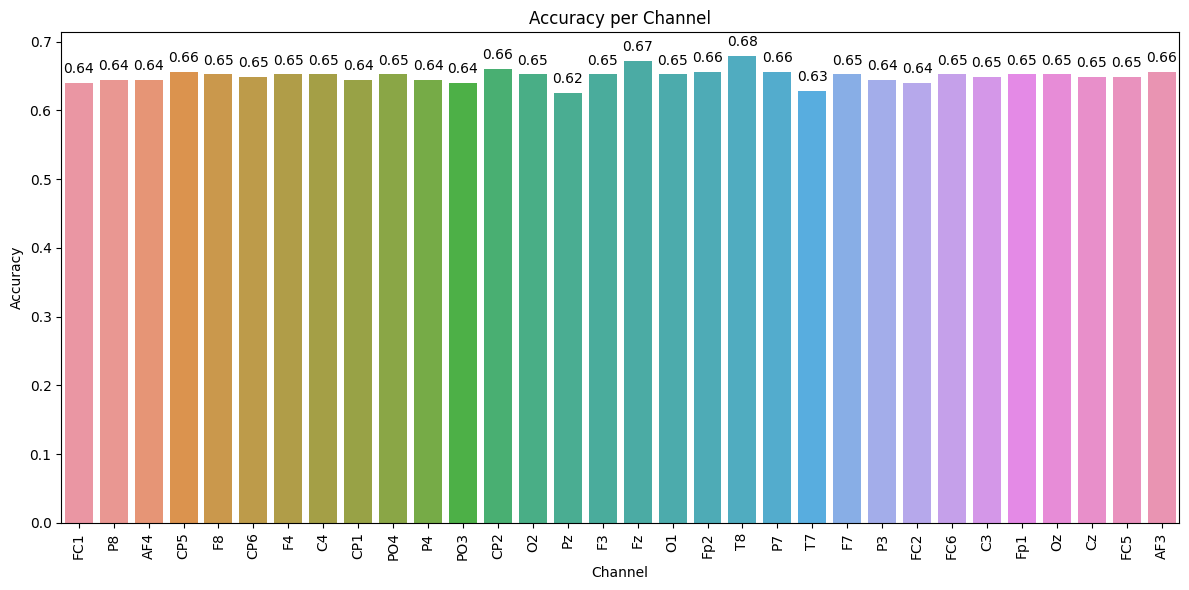

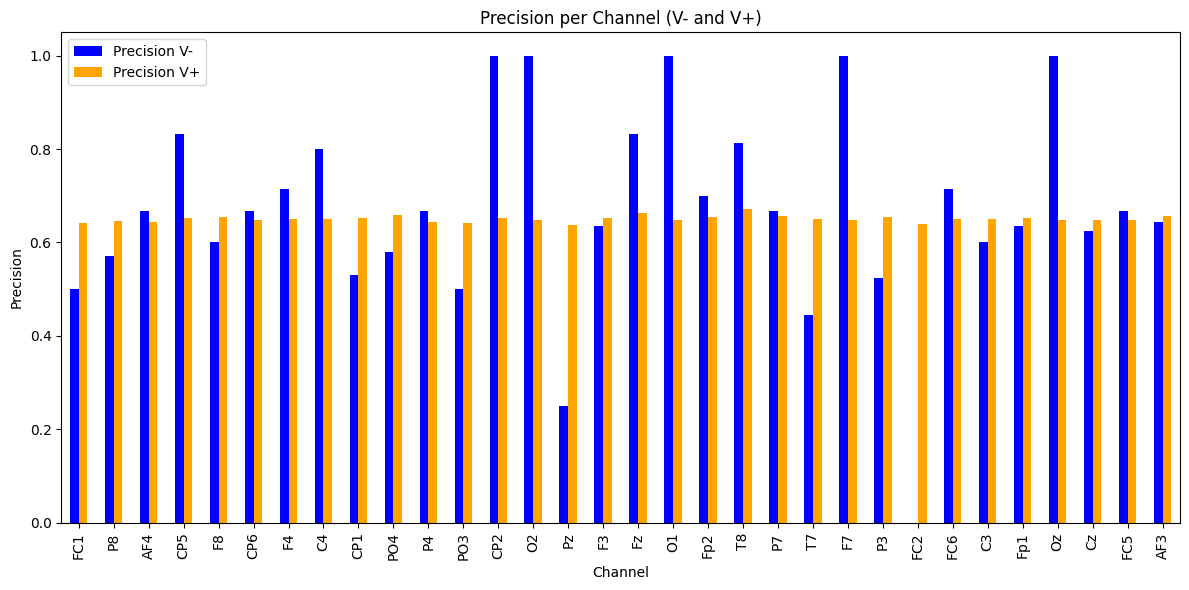

In [6]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- SOLUTION PART 1: Define separate paths ---
# Path for the metadata file (participant ratings)
metadata_folder_path = '/kaggle/input/deap-dataset/deap-dataset/Metadata/'
# Path for the processed channel data created by your first script
channel_data_folder_path = '/kaggle/working/'

# Read targets from the correct metadata folder
targets = pd.read_excel(os.path.join(metadata_folder_path, 'participant_ratings.xls'), index_col=0)
valence_targets = targets['Valence']
y = (valence_targets >= 4.5).astype(int)

class EmotionClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.relu = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm1d(64)
        self.lastlayer = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.lastlayer(x)
        return torch.sigmoid(x)

def crossval_train(x_train, y_train, num_epochs, learning_rate, batch_size, num_classes, n_folds, verbose=False):
    skf = StratifiedKFold(n_splits=n_folds)
    best_models = []
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    for train_index, val_index in skf.split(x_train.cpu().numpy(), y_train.cpu().numpy()):
        x_tr, x_val = x_train[train_index], x_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        # Move data to device
        x_tr, x_val = x_tr.to(device), x_val.to(device)
        y_tr, y_val = y_tr.to(device), y_val.to(device)

        train_set = torch.utils.data.TensorDataset(x_tr, y_tr)
        val_set = torch.utils.data.TensorDataset(x_val, y_val)

        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

        model = EmotionClassifier(x_train.shape[1], num_classes).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        criterion = nn.BCELoss()

        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                loss.backward()
                optimizer.step()

        best_models.append(model)
    return best_models[-1]

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = (outputs > 0.5).float()
        accuracy = accuracy_score(y_test.cpu().numpy(), predicted.cpu().numpy())
        precision = precision_score(y_test.cpu().numpy(), predicted.cpu().numpy(), average=None, zero_division=0)
        f1 = f1_score(y_test.cpu().numpy(), predicted.cpu().numpy(), average=None, zero_division=0)
    return accuracy, precision, f1

scaler = StandardScaler()

accuracies = []
precisions_v_minus = []
precisions_v_plus = []
channel_names = []
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(999)

# --- SOLUTION PART 2: Loop over the correct directory ---
for ch_name in os.listdir(channel_data_folder_path):
    channel_full_path = os.path.join(channel_data_folder_path, ch_name)
    if os.path.isdir(channel_full_path):
        print(f"Processing channel: {ch_name}")
        channel_names.append(ch_name)

        ch_data = []
        for file_name in os.listdir(channel_full_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(channel_full_path, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)

        if not ch_data:
            print(f"  - No CSV files found in {ch_name}, skipping.")
            channel_names.pop() # Remove the name we just added
            continue
            
        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

        best_model = crossval_train(X_train_tensor, y_train_tensor, num_epochs=50, learning_rate=0.001, batch_size=64, num_classes=1, n_folds=5)
        accuracy, precision, f1 = evaluate_model(best_model, X_test_tensor, y_test_tensor)

        accuracies.append(accuracy)
        precisions_v_minus.append(precision[0])
        precisions_v_plus.append(precision[1])

channels = channel_names

# Add a check to ensure we have data before plotting
if not channels:
    print("No channel data was processed. Cannot generate plots.")
else:
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=channels, y=accuracies)
    plt.title("Accuracy per Channel")
    plt.xlabel("Channel")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=90)

    for i, value in enumerate(accuracies):
        ax.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    precision_df = pd.DataFrame({
        'Channel': channels,
        'Precision V-': precisions_v_minus,
        'Precision V+': precisions_v_plus
    })

    precision_df.set_index('Channel', inplace=True)
    precision_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])

    plt.title("Precision per Channel (V- and V+)")
    plt.xlabel("Channel")
    plt.ylabel("Precision")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

Processing channel: FC1
Processing channel: P8
Processing channel: AF4
Processing channel: CP5
Processing channel: F8
Processing channel: CP6
Processing channel: F4
Processing channel: C4
Processing channel: CP1
Processing channel: PO4
Processing channel: P4
Processing channel: PO3
Processing channel: CP2
Processing channel: O2
Processing channel: Pz
Processing channel: F3
Processing channel: Fz
Processing channel: O1
Processing channel: Fp2
Processing channel: T8
Processing channel: P7
Processing channel: T7
Processing channel: F7
Processing channel: P3
Processing channel: FC2
Processing channel: FC6
Processing channel: C3
Processing channel: Fp1
Processing channel: Oz
Processing channel: Cz
Processing channel: FC5
Processing channel: AF3
Accuracy after probabilistic fusion: 0.63
Accuracy after majority vote fusion: 0.64
Accuracy after belief-based fusion: 0.63


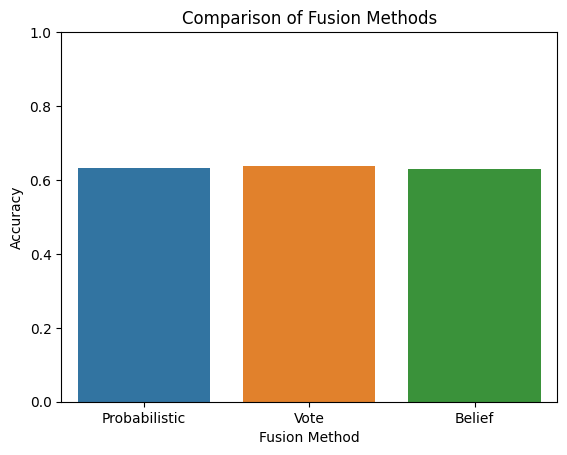

In [7]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- FIX 1: Define correct paths for metadata and channel data ---
metadata_folder_path = '/kaggle/input/deap-dataset/deap-dataset/Metadata/'
channel_data_folder_path = '/kaggle/working/' # Your processed data is here

# Read targets from the metadata folder
targets = pd.read_excel(os.path.join(metadata_folder_path, 'participant_ratings.xls'), index_col=0)
valence_targets = targets['Valence']
y = (valence_targets >= 4.5).astype(int)

# --- FIX 3: Split data ONCE before the loop to get consistent test set ---
# We need to split the data for each channel consistently.
# We'll split the indices first, which is the most robust way.
num_samples = len(y) # Should be 1280 (32 participants * 40 trials)
indices = np.arange(num_samples)

# Split indices into training and testing sets
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y
)

# Create the single, consistent y_test for final evaluation
y_test_final = y.iloc[test_indices]


class EmotionClassifier(nn.Module):
    # (Your class definition is correct, no changes needed)
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.relu = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm1d(64)
        self.lastlayer = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.lastlayer(x)
        return torch.sigmoid(x)

def crossval_train(x_train, y_train, num_epochs, learning_rate, batch_size, num_classes, n_folds, device, verbose=False):
    # (Your function is mostly correct, just passing device in)
    skf = StratifiedKFold(n_splits=n_folds)
    best_models = []

    for train_index, val_index in skf.split(x_train.cpu().numpy(), y_train.cpu().numpy()):
        x_tr, x_val = x_train[train_index], x_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]
        
        x_tr, x_val = x_tr.to(device), x_val.to(device)
        y_tr, y_val = y_tr.to(device), y_val.to(device)

        train_set = torch.utils.data.TensorDataset(x_tr, y_tr)
        val_set = torch.utils.data.TensorDataset(x_val, y_val)

        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

        model = EmotionClassifier(x_train.shape[1], num_classes).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        criterion = nn.BCELoss()

        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                loss.backward()
                optimizer.step()
        best_models.append(model)
    return best_models[-1]


def fusion_probabiliste(probabilities_list):
    return np.mean(probabilities_list, axis=0)

def fusion_par_vote(predictions_list):
    predictions_array = np.array(predictions_list)
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_array)

def fusion_bba(probabilities_list):
    # Note: This is a simplified conjunction. For it to be numerically stable,
    # it's better to work in log-space, but this will work for now.
    fused_beliefs = probabilities_list[0]
    for probs in probabilities_list[1:]:
        # Add a small epsilon to avoid division by zero
        denominator = (fused_beliefs * probs + (1 - fused_beliefs) * (1 - probs))
        denominator[denominator == 0] = 1e-9 
        fused_beliefs = fused_beliefs * probs / denominator
    return fused_beliefs


# --- Main Processing Loop ---
scaler = StandardScaler()
probabilities_list = []
predictions_list = []
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(999)

# Loop over the correct data directory
for ch_name in os.listdir(channel_data_folder_path):
    channel_full_path = os.path.join(channel_data_folder_path, ch_name)
    
    # --- FIX 2: Correctly indent the processing logic ---
    if os.path.isdir(channel_full_path):
        print(f"Processing channel: {ch_name}")
        ch_data = []
        for file_name in os.listdir(channel_full_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(channel_full_path, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)
        
        if not ch_data:
            print(f"  - No CSV files in {ch_name}, skipping.")
            continue

        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        # Drop the trial column if it exists, as it's not a feature
        if 'trial' in ch_data.columns:
            ch_data = ch_data.drop(columns=['trial'])
            
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        # Use the pre-split indices to get consistent data subsets
        X_train = X_scaled[train_indices]
        X_test = X_scaled[test_indices]
        y_train = y.iloc[train_indices]
        # y_test is already defined as y_test_final

        # Convert to Tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
        
        # Train a model for this channel
        best_model = crossval_train(X_train_tensor, y_train_tensor, num_epochs=50, learning_rate=0.001, batch_size=64, num_classes=1, n_folds=5, device=device)

        # Get predictions ON THE CONSISTENT TEST SET
        best_model.eval()
        with torch.no_grad():
            probabilities = best_model(X_test_tensor).cpu().numpy().squeeze()
            predictions = (probabilities > 0.5).astype(int)

        probabilities_list.append(probabilities)
        predictions_list.append(predictions)

# --- Final Evaluation (Now outside the loop) ---
# Check if any models were trained before proceeding
if not probabilities_list:
    print("ERROR: No channel data was processed. Cannot perform fusion.")
else:
    fused_probabilities = fusion_probabiliste(probabilities_list)
    fused_predictions_prob = (fused_probabilities > 0.5).astype(int)
    # Use the consistent y_test_final
    accuracy_prob = accuracy_score(y_test_final, fused_predictions_prob)
    print(f"Accuracy after probabilistic fusion: {accuracy_prob:.2f}")

    fused_predictions_vote = fusion_par_vote(predictions_list)
    accuracy_vote = accuracy_score(y_test_final, fused_predictions_vote)
    print(f"Accuracy after majority vote fusion: {accuracy_vote:.2f}")

    fused_beliefs = fusion_bba(probabilities_list)
    fused_predictions_bba = (fused_beliefs > 0.5).astype(int)
    accuracy_bba = accuracy_score(y_test_final, fused_predictions_bba)
    print(f"Accuracy after belief-based fusion: {accuracy_bba:.2f}")

    fusion_results = pd.DataFrame({
        'Fusion Method': ['Probabilistic', 'Vote', 'Belief'],
        'Accuracy': [accuracy_prob, accuracy_vote, accuracy_bba]
    })

    sns.barplot(data=fusion_results, x='Fusion Method', y='Accuracy')
    plt.title('Comparison of Fusion Methods')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0) # Set y-axis to be between 0 and 1 for accuracy
    plt.show()

2. Arousal

Using device: cuda:0
Processing channel: FC1
Processing channel: P8
Processing channel: AF4
Processing channel: CP5
Processing channel: F8
Processing channel: CP6
Processing channel: F4
Processing channel: C4
Processing channel: CP1
Processing channel: PO4
Processing channel: P4
Processing channel: PO3
Processing channel: CP2
Processing channel: O2
Processing channel: Pz
Processing channel: F3
Processing channel: Fz
Processing channel: O1
Processing channel: Fp2
Processing channel: T8
Processing channel: P7
Processing channel: T7
Processing channel: F7
Processing channel: P3
Processing channel: FC2
Processing channel: FC6
Processing channel: C3
Processing channel: Fp1
Processing channel: Oz
Processing channel: Cz
Processing channel: FC5
Processing channel: AF3


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


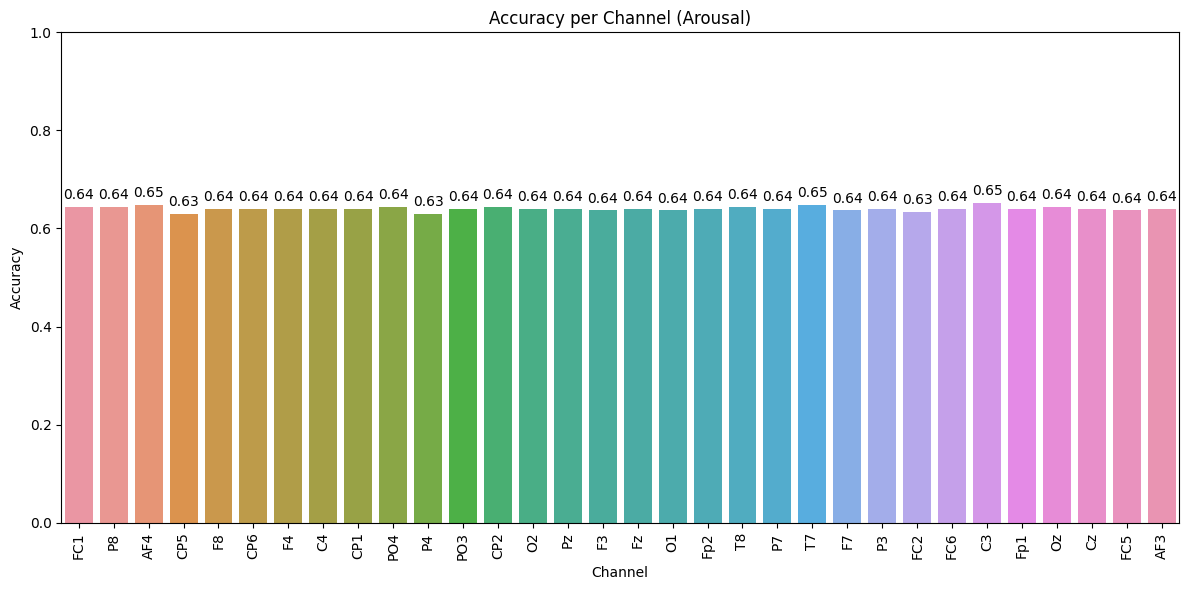

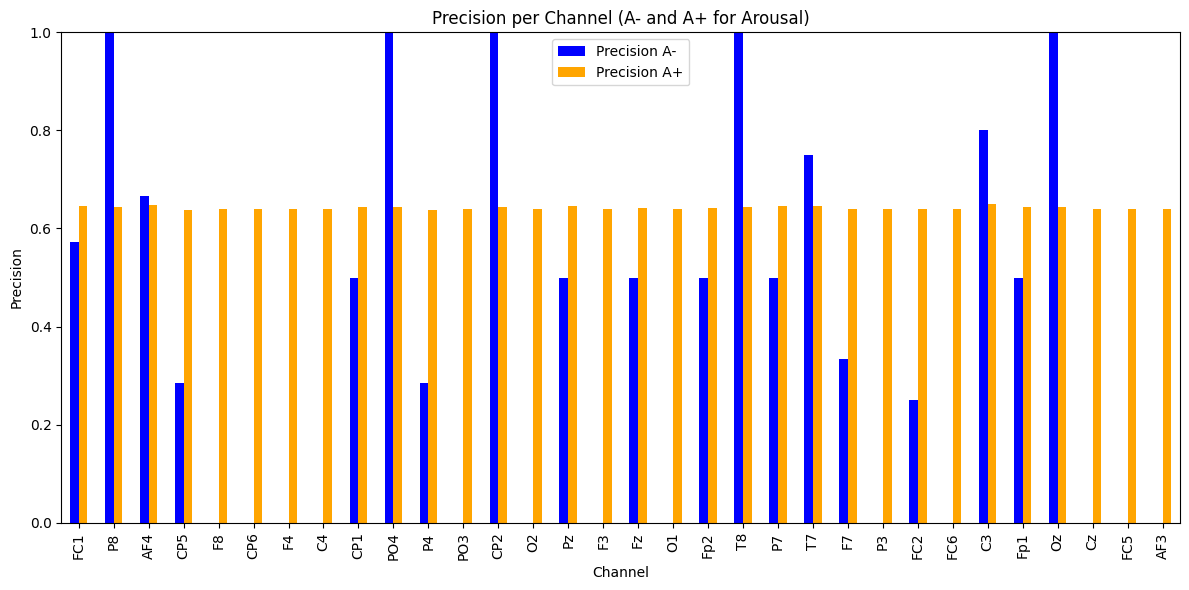

In [8]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- FIX 1: Define correct paths for metadata and channel data ---
metadata_folder_path = '/kaggle/input/deap-dataset/deap-dataset/Metadata/'
channel_data_folder_path = '/kaggle/working/' # Your processed data is here

# Read targets from the metadata folder
targets = pd.read_excel(os.path.join(metadata_folder_path, 'participant_ratings.xls'), index_col=0)
arousal_targets = targets['Arousal']
y = (arousal_targets >= 4.5).astype(int)

# --- FIX 2: Split data ONCE before the loop for a consistent test set ---
# We split indices, which is a robust way to ensure all channels use the same split.
num_samples = len(y) # Total samples = 32 participants * 40 trials = 1280
indices = np.arange(num_samples)

# Split indices into training and testing sets, stratifying on the labels
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y
)

# This is our single, consistent set of true labels for testing all models
y_test_final = y.iloc[test_indices]


class EmotionClassifier(nn.Module):
    # (Your class definition is correct)
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.relu = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm1d(64)
        self.lastlayer = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.lastlayer(x)
        return torch.sigmoid(x)

# --- FIX 3: Pass 'device' as an argument for cleaner code ---
def crossval_train(x_train, y_train, num_epochs, learning_rate, batch_size, num_classes, n_folds, device, verbose=False):
    skf = StratifiedKFold(n_splits=n_folds)
    best_models = []

    for train_index, val_index in skf.split(x_train.cpu().numpy(), y_train.cpu().numpy()):
        x_tr, x_val = x_train[train_index], x_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]
        
        # Move data to the specified device
        x_tr, x_val = x_tr.to(device), x_val.to(device)
        y_tr, y_val = y_tr.to(device), y_val.to(device)

        train_set = torch.utils.data.TensorDataset(x_tr, y_tr)
        val_set = torch.utils.data.TensorDataset(x_val, y_val)
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

        model = EmotionClassifier(x_train.shape[1], num_classes).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        criterion = nn.BCELoss()

        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                loss.backward()
                optimizer.step()
        best_models.append(model)
    return best_models[-1]

def evaluate_model(model, X_test_tensor, y_test_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        predicted = (outputs > 0.5).float()
        
        # Move tensors to CPU for scikit-learn functions
        y_true_cpu = y_test_tensor.cpu().numpy()
        y_pred_cpu = predicted.cpu().numpy()

        accuracy = accuracy_score(y_true_cpu, y_pred_cpu)
        precision = precision_score(y_true_cpu, y_pred_cpu, average=None, zero_division=0)
        f1 = f1_score(y_true_cpu, y_pred_cpu, average=None, zero_division=0)

    return accuracy, precision, f1

# --- Main Processing Loop ---
scaler = StandardScaler()
accuracies = []
precisions_a_minus = []
precisions_a_plus = []
channel_names = []

# Define device once, before the loop
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(999)
print(f"Using device: {device}")

# Loop over the correct directory containing channel data
for ch_name in os.listdir(channel_data_folder_path):
    channel_full_path = os.path.join(channel_data_folder_path, ch_name)
    
    if os.path.isdir(channel_full_path):
        print(f"Processing channel: {ch_name}")
        ch_data = []
        for file_name in os.listdir(channel_full_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(channel_full_path, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)
        
        if not ch_data:
            print(f"  - No CSV files found in {ch_name}, skipping.")
            continue

        channel_names.append(ch_name)
        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        
        # --- FIX 4: Remove non-feature columns before creating X ---
        if 'trial' in ch_data.columns:
            ch_data = ch_data.drop(columns=['trial'])
            
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        # Use the pre-split indices to get consistent data subsets
        X_train = X_scaled[train_indices]
        X_test = X_scaled[test_indices]
        y_train = y.iloc[train_indices]
        # y_test is our y_test_final defined outside the loop

        # Convert to Tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test_final.values, dtype=torch.float32).to(device)

        # Train a model for this channel
        best_model = crossval_train(X_train_tensor, y_train_tensor, num_epochs=50, learning_rate=0.001, batch_size=64, num_classes=1, n_folds=5, device=device)
        
        # Evaluate the model on the consistent test set
        accuracy, precision, f1 = evaluate_model(best_model, X_test_tensor, y_test_tensor)

        accuracies.append(accuracy)
        precisions_a_minus.append(precision[0])
        precisions_a_plus.append(precision[1])

# --- Plotting Results ---
# Check if any data was processed before trying to plot
if not channel_names:
    print("\nERROR: No channel data was processed. Cannot generate plots.")
else:
    channels = channel_names

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=channels, y=accuracies)
    plt.title("Accuracy per Channel (Arousal)")
    plt.xlabel("Channel")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=90)
    plt.ylim(0, 1.0) # Set a consistent y-axis for accuracy

    for i, value in enumerate(accuracies):
        ax.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    precision_df = pd.DataFrame({
        'Channel': channels,
        'Precision A-': precisions_a_minus,
        'Precision A+': precisions_a_plus
    })

    precision_df.set_index('Channel', inplace=True)
    precision_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])

    plt.title("Precision per Channel (A- and A+ for Arousal)")
    plt.xlabel("Channel")
    plt.ylabel("Precision")
    plt.xticks(rotation=90)
    plt.ylim(0, 1.0) # Set a consistent y-axis for precision
    plt.tight_layout()
    plt.show()

Using device: cuda:0
Processing channel: FC1
Processing channel: P8
Processing channel: AF4
Processing channel: CP5
Processing channel: F8
Processing channel: CP6
Processing channel: F4
Processing channel: C4
Processing channel: CP1
Processing channel: PO4
Processing channel: P4
Processing channel: PO3
Processing channel: CP2
Processing channel: O2
Processing channel: Pz
Processing channel: F3
Processing channel: Fz
Processing channel: O1
Processing channel: Fp2
Processing channel: T8
Processing channel: P7
Processing channel: T7
Processing channel: F7
Processing channel: P3
Processing channel: FC2
Processing channel: FC6
Processing channel: C3
Processing channel: Fp1
Processing channel: Oz
Processing channel: Cz
Processing channel: FC5
Processing channel: AF3

Accuracy after probabilistic fusion (Arousal): 0.64
Accuracy after majority vote fusion (Arousal): 0.64
Accuracy after belief-based fusion (Arousal): 0.64


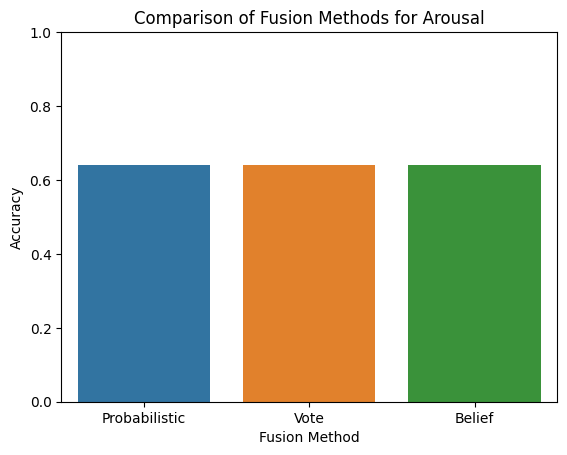

In [9]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- FIX 1: Define correct paths for metadata and channel data ---
metadata_folder_path = '/kaggle/input/deap-dataset/deap-dataset/Metadata/'
channel_data_folder_path = '/kaggle/working/' # Your processed data is here

# Read targets and create the y vector for Arousal
targets = pd.read_excel(os.path.join(metadata_folder_path, 'participant_ratings.xls'), index_col=0)
arousal_targets = targets['Arousal']
y = (arousal_targets >= 4.5).astype(int)

# --- FIX 2: Split data ONCE before the loop for a consistent test set ---
# We split indices, which is a robust way to ensure all channels use the same split.
num_samples = len(y) # Total samples = 32 participants * 40 trials = 1280
indices = np.arange(num_samples)

# Split indices into training and testing sets, stratifying on the labels
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y
)

# This is our single, consistent set of true labels for final evaluation
y_test_final = y.iloc[test_indices]


class EmotionClassifier(nn.Module):
    # (Your class definition is correct)
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.relu = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm1d(64)
        self.lastlayer = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.lastlayer(x)
        return torch.sigmoid(x)

# --- FIX 3: Pass 'device' as an argument for cleaner code ---
def crossval_train(x_train, y_train, num_epochs, learning_rate, batch_size, num_classes, n_folds, device, verbose=False):
    skf = StratifiedKFold(n_splits=n_folds)
    best_models = []

    for train_index, val_index in skf.split(x_train.cpu().numpy(), y_train.cpu().numpy()):
        x_tr, x_val = x_train[train_index], x_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]
        
        x_tr, x_val = x_tr.to(device), x_val.to(device)
        y_tr, y_val = y_tr.to(device), y_val.to(device)

        train_set = torch.utils.data.TensorDataset(x_tr, y_tr)
        val_set = torch.utils.data.TensorDataset(x_val, y_val)
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

        model = EmotionClassifier(x_train.shape[1], num_classes).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        criterion = nn.BCELoss()

        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                loss.backward()
                optimizer.step()
        best_models.append(model)
    return best_models[-1]


# --- Fusion Functions ---
def fusion_probabiliste(probabilities_list):
    return np.mean(probabilities_list, axis=0)

def fusion_par_vote(predictions_list):
    predictions_array = np.array(predictions_list)
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_array)

def fusion_bba(probabilities_list):
    fused_beliefs = probabilities_list[0]
    for probs in probabilities_list[1:]:
        # Add a small epsilon to avoid division by zero
        denominator = (fused_beliefs * probs + (1 - fused_beliefs) * (1 - probs))
        denominator[denominator == 0] = 1e-9 
        fused_beliefs = fused_beliefs * probs / denominator
    return fused_beliefs

# --- Main Processing Loop ---
scaler = StandardScaler()
probabilities_list = []
predictions_list = []
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(999)
print(f"Using device: {device}")

# Loop over the correct data directory
for ch_name in os.listdir(channel_data_folder_path):
    channel_full_path = os.path.join(channel_data_folder_path, ch_name)
    
    # --- FIX 4: Correctly indent the processing logic ---
    if os.path.isdir(channel_full_path):
        print(f"Processing channel: {ch_name}")
        ch_data = []
        for file_name in os.listdir(channel_full_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(channel_full_path, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)
        
        if not ch_data:
            print(f"  - No CSV files in {ch_name}, skipping.")
            continue

        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        # --- FIX 5: Remove non-feature columns before creating X ---
        if 'trial' in ch_data.columns:
            ch_data = ch_data.drop(columns=['trial'])
            
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        # Use the pre-split indices to get consistent data subsets
        X_train = X_scaled[train_indices]
        X_test = X_scaled[test_indices]
        y_train = y.iloc[train_indices]
        # y_test is our y_test_final defined outside the loop

        # Convert to Tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
        
        # Train a model for this channel
        best_model = crossval_train(X_train_tensor, y_train_tensor, num_epochs=50, learning_rate=0.001, batch_size=64, num_classes=1, n_folds=5, device=device)

        # Get predictions ON THE CONSISTENT TEST SET
        best_model.eval()
        with torch.no_grad():
            probabilities = best_model(X_test_tensor).cpu().numpy().squeeze()
            predictions = (probabilities > 0.5).astype(int)

        probabilities_list.append(probabilities)
        predictions_list.append(predictions)

# --- Final Evaluation (Now outside the loop) ---
# Check if any models were trained before proceeding
if not probabilities_list:
    print("\nERROR: No channel data was processed. Cannot perform fusion.")
else:
    fused_probabilities = fusion_probabiliste(probabilities_list)
    fused_predictions_prob = (fused_probabilities > 0.5).astype(int)
    # Use the consistent y_test_final
    accuracy_prob = accuracy_score(y_test_final, fused_predictions_prob)
    print(f"\nAccuracy after probabilistic fusion (Arousal): {accuracy_prob:.2f}")

    fused_predictions_vote = fusion_par_vote(predictions_list)
    accuracy_vote = accuracy_score(y_test_final, fused_predictions_vote)
    print(f"Accuracy after majority vote fusion (Arousal): {accuracy_vote:.2f}")

    fused_beliefs = fusion_bba(probabilities_list)
    fused_predictions_bba = (fused_beliefs > 0.5).astype(int)
    accuracy_bba = accuracy_score(y_test_final, fused_predictions_bba)
    print(f"Accuracy after belief-based fusion (Arousal): {accuracy_bba:.2f}")

    fusion_results = pd.DataFrame({
        'Fusion Method': ['Probabilistic', 'Vote', 'Belief'],
        'Accuracy': [accuracy_prob, accuracy_vote, accuracy_bba]
    })

    sns.barplot(data=fusion_results, x='Fusion Method', y='Accuracy')
    plt.title('Comparison of Fusion Methods for Arousal')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0) # Set y-axis to be between 0 and 1 for accuracy
    plt.show()

# SVM

1. Valence

Processing channel: FC1
  - Best params for FC1: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Processing channel: P8
  - Best params for P8: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Processing channel: AF4
  - Best params for AF4: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Processing channel: CP5
  - Best params for CP5: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Processing channel: F8
  - Best params for F8: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Processing channel: CP6
  - Best params for CP6: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Processing channel: F4
  - Best params for F4: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Processing channel: C4
  - Best params for C4: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Processing channel: CP1
  - Best params for CP1: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Processing channel: PO4
  - Best params for PO4: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Processing channel: P4
  - Best params for P4: {'C': 0.1, 'gamma': 'scale', 'kerne

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


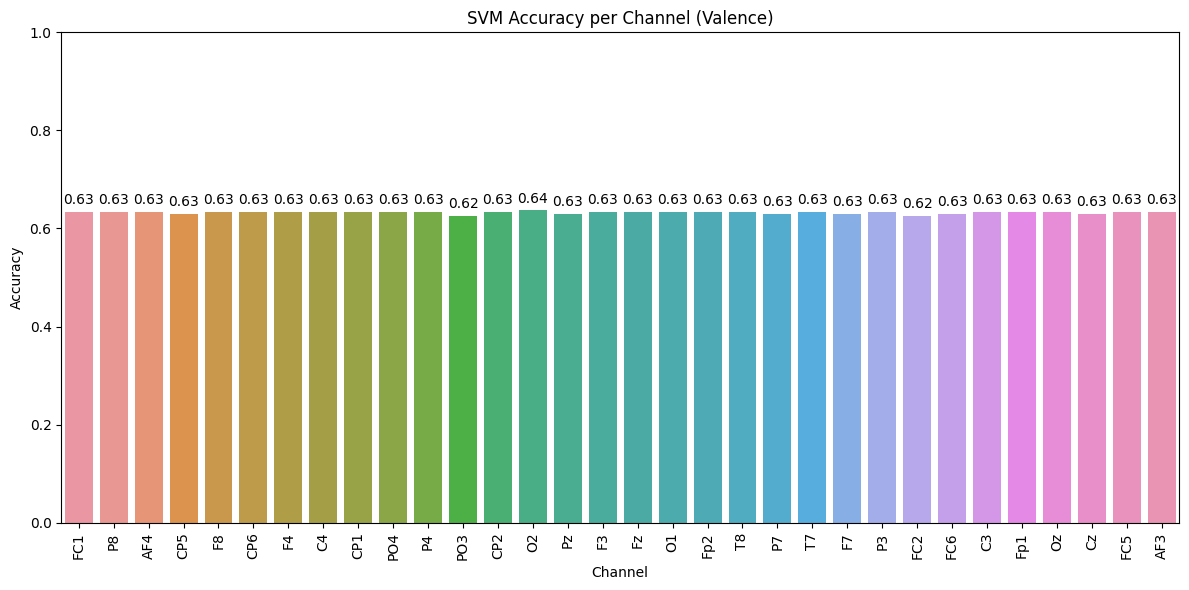

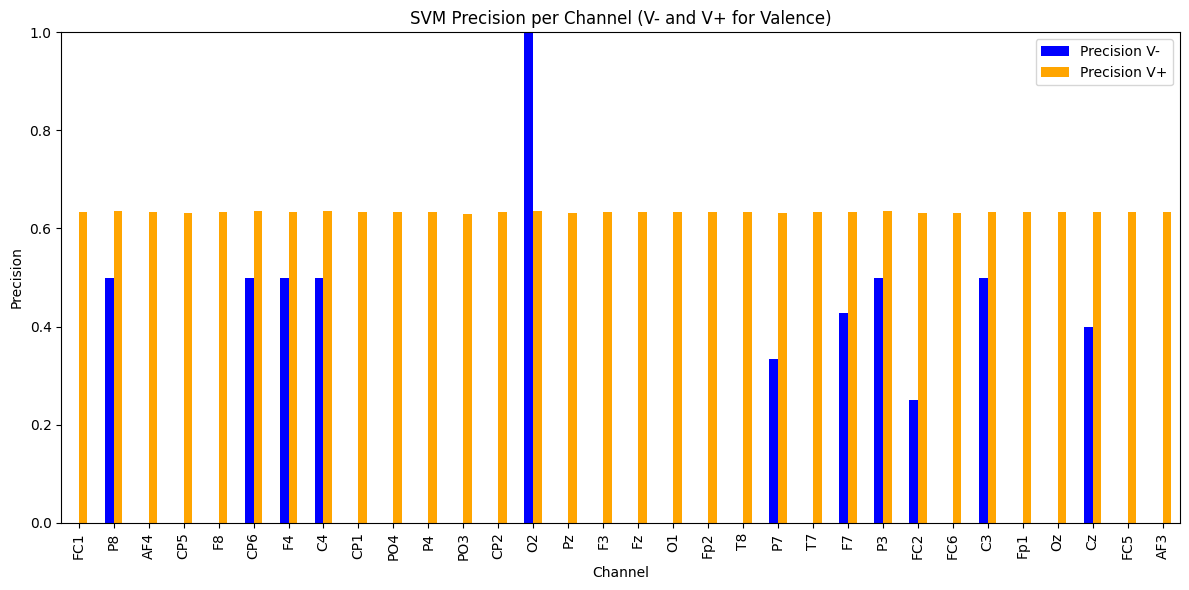

In [10]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- FIX 1: Define correct paths for metadata and channel data ---
metadata_folder_path = '/kaggle/input/deap-dataset/deap-dataset/Metadata/'
channel_data_folder_path = '/kaggle/working/' # Your processed data is here

# Read targets from the metadata folder
targets = pd.read_excel(os.path.join(metadata_folder_path, 'participant_ratings.xls'), index_col=0)
valence_targets = targets['Valence']
y = (valence_targets >= 4.5).astype(int)

# --- FIX 2: Split data ONCE before the loop for a consistent test set ---
# We split indices, which is a robust way to ensure all channels use the same split.
num_samples = len(y) # Total samples = 32 participants * 40 trials = 1280
indices = np.arange(num_samples)

# Split indices into training and testing sets, stratifying on the labels
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y
)

# This is our single, consistent set of true labels for testing all models
y_test_final = y.iloc[test_indices]


def evaluate_svm(model, X_test, y_test):
    predicted = model.predict(X_test)
    accuracy = accuracy_score(y_test, predicted)
    precision = precision_score(y_test, predicted, average=None, zero_division=0)
    f1 = f1_score(y_test, predicted, average=None, zero_division=0)
    return accuracy, precision, f1

# --- Main Processing Loop ---
scaler = StandardScaler()
accuracies = []
precisions_v_minus = []
precisions_v_plus = []
channel_names = []

# Loop over the correct directory containing channel data
for ch_name in os.listdir(channel_data_folder_path):
    channel_full_path = os.path.join(channel_data_folder_path, ch_name)
    
    if os.path.isdir(channel_full_path):
        print(f"Processing channel: {ch_name}")
        ch_data = []
        for file_name in os.listdir(channel_full_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(channel_full_path, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)
        
        if not ch_data:
            print(f"  - No CSV files found in {ch_name}, skipping.")
            continue
            
        channel_names.append(ch_name)
        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        
        # --- FIX 3: Remove non-feature columns before creating X ---
        if 'trial' in ch_data.columns:
            ch_data = ch_data.drop(columns=['trial'])
            
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        # Use the pre-split indices to get consistent data subsets
        X_train = X_scaled[train_indices]
        X_test = X_scaled[test_indices]
        y_train = y.iloc[train_indices]
        # We will use y_test_final for evaluation

        # --- SVM Training with Grid Search ---
        param_grid = {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 0.001, 0.01, 0.1, 1],
            'kernel': ['rbf'] # It's often better to test one kernel at a time
        }
        # Using n_jobs=-1 will use all available CPU cores, speeding up the search
        grid = GridSearchCV(SVC(probability=True), param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1, refit=True)
        grid.fit(X_train, y_train)

        print(f"  - Best params for {ch_name}: {grid.best_params_}")
        best_model = grid.best_estimator_
        
        # Evaluate the model on the consistent test set
        accuracy, precision, f1 = evaluate_svm(best_model, X_test, y_test_final)

        accuracies.append(accuracy)
        precisions_v_minus.append(precision[0])
        precisions_v_plus.append(precision[1])

# --- Plotting Results ---
# Check if any data was processed before trying to plot
if not channel_names:
    print("\nERROR: No channel data was processed. Cannot generate plots.")
else:
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=channel_names, y=accuracies)
    plt.title("SVM Accuracy per Channel (Valence)")
    plt.xlabel("Channel")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=90)
    plt.ylim(0, 1.0) # Set a consistent y-axis for accuracy

    for i, value in enumerate(accuracies):
        ax.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    precision_df = pd.DataFrame({
        'Channel': channel_names,
        'Precision V-': precisions_v_minus,
        'Precision V+': precisions_v_plus
    })

    precision_df.set_index('Channel', inplace=True)
    precision_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])

    plt.title("SVM Precision per Channel (V- and V+ for Valence)")
    plt.xlabel("Channel")
    plt.ylabel("Precision")
    plt.xticks(rotation=90)
    plt.ylim(0, 1.0) # Set a consistent y-axis for precision
    plt.tight_layout()
    plt.show()

2. Arousal

Processing channel: FC1
  - Best params for FC1: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Processing channel: P8
  - Best params for P8: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Processing channel: AF4
  - Best params for AF4: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Processing channel: CP5
  - Best params for CP5: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Processing channel: F8
  - Best params for F8: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Processing channel: CP6
  - Best params for CP6: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Processing channel: F4
  - Best params for F4: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Processing channel: C4
  - Best params for C4: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Processing channel: CP1
  - Best params for CP1: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Processing channel: PO4
  - Best params for PO4: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Processing channel: P4
  - Best params for P4: {'C': 0.1, 'gamma': 'sca

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


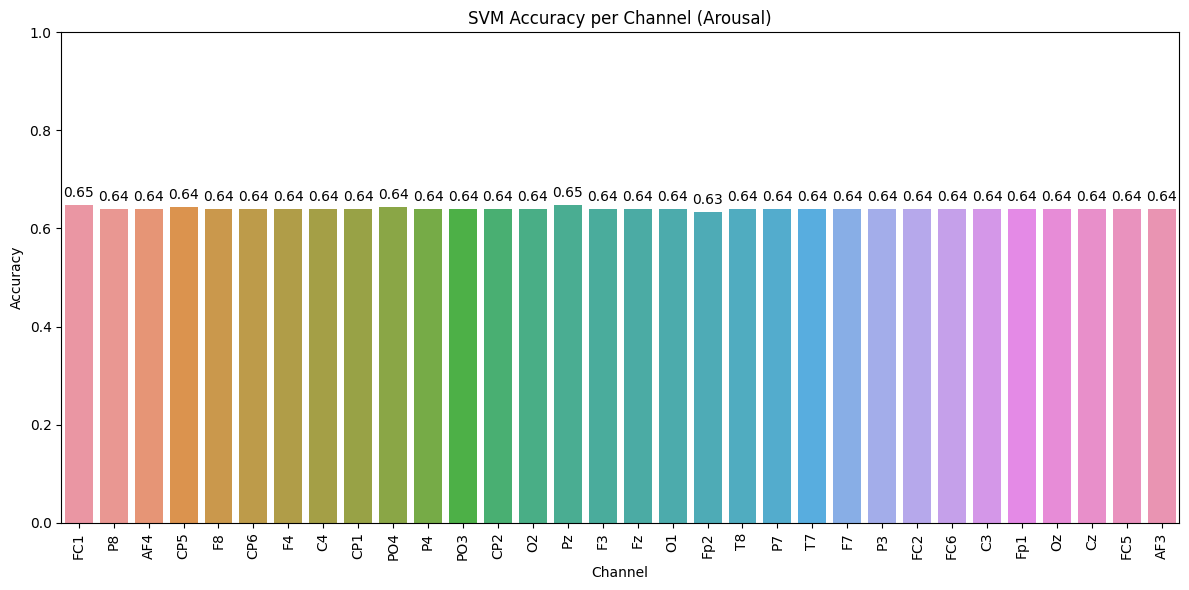

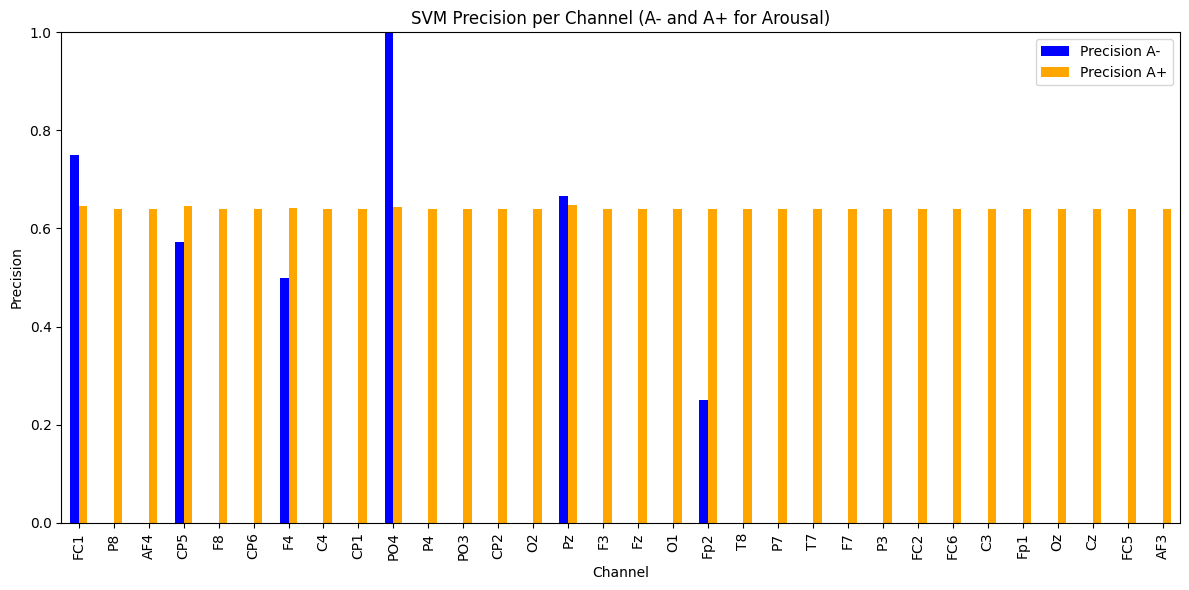

In [11]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- FIX 1: Define correct paths for metadata and channel data ---
metadata_folder_path = '/kaggle/input/deap-dataset/deap-dataset/Metadata/'
channel_data_folder_path = '/kaggle/working/' # Your processed data is here

# Read targets and create the y vector for Arousal
targets = pd.read_excel(os.path.join(metadata_folder_path, 'participant_ratings.xls'), index_col=0)
arousal_targets = targets['Arousal']
y = (arousal_targets >= 4.5).astype(int)

# --- FIX 2: Split data ONCE before the loop for a consistent test set ---
# We split indices, which is a robust way to ensure all channels use the same split.
num_samples = len(y) # Total samples = 32 participants * 40 trials = 1280
indices = np.arange(num_samples)

# Split indices into training and testing sets, stratifying on the labels
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y
)

# This is our single, consistent set of true labels for testing all models
y_test_final = y.iloc[test_indices]


def evaluate_svm(model, X_test, y_test):
    predicted = model.predict(X_test)
    accuracy = accuracy_score(y_test, predicted)
    precision = precision_score(y_test, predicted, average=None, zero_division=0)
    f1 = f1_score(y_test, predicted, average=None, zero_division=0)
    return accuracy, precision, f1

# --- Main Processing Loop ---
scaler = StandardScaler()
accuracies = []
precisions_a_minus = []
precisions_a_plus = []
channel_names = []

# Loop over the correct directory containing channel data
for ch_name in os.listdir(channel_data_folder_path):
    channel_full_path = os.path.join(channel_data_folder_path, ch_name)
    
    if os.path.isdir(channel_full_path):
        print(f"Processing channel: {ch_name}")
        ch_data = []
        for file_name in os.listdir(channel_full_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(channel_full_path, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)
        
        if not ch_data:
            print(f"  - No CSV files found in {ch_name}, skipping.")
            continue
            
        channel_names.append(ch_name)
        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        
        # --- FIX 3: Remove non-feature columns before creating X ---
        if 'trial' in ch_data.columns:
            ch_data = ch_data.drop(columns=['trial'])
            
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        # Use the pre-split indices to get consistent data subsets
        X_train = X_scaled[train_indices]
        X_test = X_scaled[test_indices]
        y_train = y.iloc[train_indices]
        # We will use y_test_final for evaluation

        # --- SVM Training with Grid Search ---
        param_grid = {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 0.001, 0.01, 0.1], # Reduced gamma range for faster search
            'kernel': ['rbf'] 
        }
        # Using n_jobs=-1 will use all available CPU cores, speeding up the search
        grid = GridSearchCV(SVC(probability=True), param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1, refit=True)
        grid.fit(X_train, y_train)

        print(f"  - Best params for {ch_name}: {grid.best_params_}")
        best_model = grid.best_estimator_
        
        # Evaluate the model on the consistent test set
        accuracy, precision, f1 = evaluate_svm(best_model, X_test, y_test_final)

        accuracies.append(accuracy)
        precisions_a_minus.append(precision[0])
        precisions_a_plus.append(precision[1])

# --- Plotting Results ---
# Check if any data was processed before trying to plot
if not channel_names:
    print("\nERROR: No channel data was processed. Cannot generate plots.")
else:
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=channel_names, y=accuracies)
    plt.title("SVM Accuracy per Channel (Arousal)")
    plt.xlabel("Channel")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=90)
    plt.ylim(0, 1.0) # Set a consistent y-axis for accuracy

    for i, value in enumerate(accuracies):
        ax.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # --- FIX 4: Correct the variable names for the DataFrame ---
    precision_df = pd.DataFrame({
        'Channel': channel_names,
        'Precision A-': precisions_a_minus,
        'Precision A+': precisions_a_plus
    })

    precision_df.set_index('Channel', inplace=True)
    precision_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])

    plt.title("SVM Precision per Channel (A- and A+ for Arousal)")
    plt.xlabel("Channel")
    plt.ylabel("Precision")
    plt.xticks(rotation=90)
    plt.ylim(0, 1.0) # Set a consistent y-axis for precision
    plt.tight_layout()
    plt.show()

# Random Forest

1. Valence

Processing channel: FC1
  - Best params for FC1: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Processing channel: P8
  - Best params for P8: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Processing channel: AF4
  - Best params for AF4: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Processing channel: CP5
  - Best params for CP5: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Processing channel: F8
  - Best params for F8: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Processing channel: CP6
  - Best params for CP6: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Processing channel: F4
  - Best params for F4: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Processing channel: C4
  - Best params for C4: {'max_depth':

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


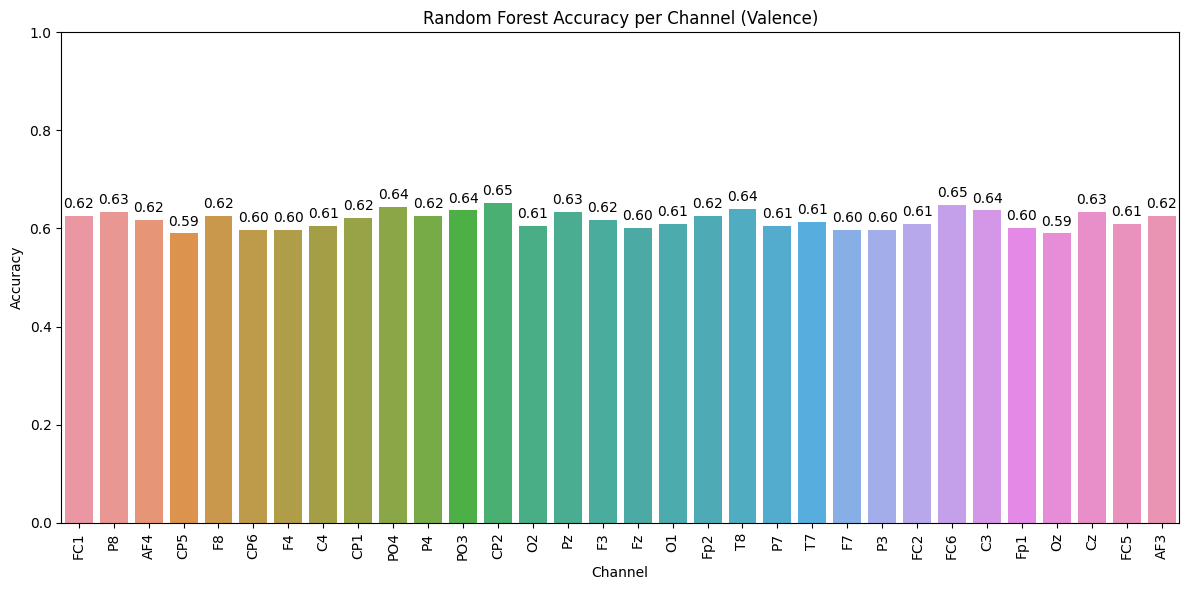

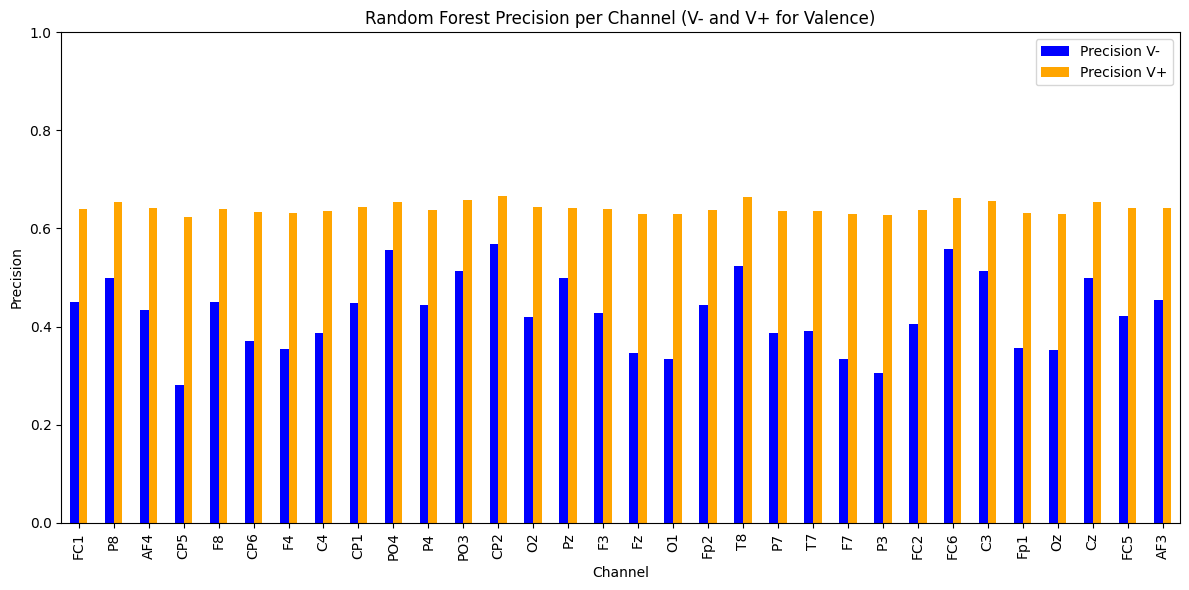

In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- FIX 1: Define correct paths for metadata and channel data ---
metadata_folder_path = '/kaggle/input/deap-dataset/deap-dataset/Metadata/'
channel_data_folder_path = '/kaggle/working/' # Your processed data is here

# Read targets from the metadata folder
targets = pd.read_excel(os.path.join(metadata_folder_path, 'participant_ratings.xls'), index_col=0)
valence_targets = targets['Valence']
y = (valence_targets >= 4.5).astype(int)

# --- FIX 2: Split data ONCE before the loop for a consistent test set ---
# We split indices, which is a robust way to ensure all channels use the same split.
num_samples = len(y) # Total samples = 32 participants * 40 trials = 1280
indices = np.arange(num_samples)

# Split indices into training and testing sets, stratifying on the labels
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y
)

# This is our single, consistent set of true labels for testing all models
y_test_final = y.iloc[test_indices]


# --- Main Processing Loop ---
scaler = StandardScaler()
accuracies = []
precisions_v_minus = []
precisions_v_plus = []
channel_names = []

# Define the hyperparameter grid for the Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Loop over the correct directory containing channel data
for ch_name in os.listdir(channel_data_folder_path):
    channel_full_path = os.path.join(channel_data_folder_path, ch_name)
    
    if os.path.isdir(channel_full_path):
        print(f"Processing channel: {ch_name}")
        ch_data = []
        for file_name in os.listdir(channel_full_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(channel_full_path, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)
        
        if not ch_data:
            print(f"  - No CSV files found in {ch_name}, skipping.")
            continue
            
        channel_names.append(ch_name)
        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        
        # --- FIX 3: Remove non-feature columns before creating X ---
        if 'trial' in ch_data.columns:
            ch_data = ch_data.drop(columns=['trial'])
            
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        # Use the pre-split indices to get consistent data subsets
        X_train = X_scaled[train_indices]
        X_test = X_scaled[test_indices]
        y_train = y.iloc[train_indices]
        # We will use y_test_final for evaluation

        # --- Random Forest Training with Grid Search ---
        rf = RandomForestClassifier(random_state=42)
        # Using n_jobs=-1 will use all available CPU cores, speeding up the search
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5), verbose=0, n_jobs=-1, refit=True)
        grid_search.fit(X_train, y_train)

        print(f"  - Best params for {ch_name}: {grid_search.best_params_}")
        best_rf = grid_search.best_estimator_

        # Evaluate the best model on the consistent test set
        y_pred = best_rf.predict(X_test)
        accuracy = accuracy_score(y_test_final, y_pred)
        precision = precision_score(y_test_final, y_pred, average=None, zero_division=0)

        accuracies.append(accuracy)
        precisions_v_minus.append(precision[0])
        precisions_v_plus.append(precision[1])

# --- Plotting Results ---
# Check if any data was processed before trying to plot
if not channel_names:
    print("\nERROR: No channel data was processed. Cannot generate plots.")
else:
    channels = channel_names

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=channels, y=accuracies)
    plt.title("Random Forest Accuracy per Channel (Valence)")
    plt.xlabel("Channel")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=90)
    plt.ylim(0, 1.0) # Set a consistent y-axis for accuracy

    for i, value in enumerate(accuracies):
        ax.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    precision_df = pd.DataFrame({
        'Channel': channels,
        'Precision V-': precisions_v_minus,
        'Precision V+': precisions_v_plus
    })

    precision_df.set_index('Channel', inplace=True)
    precision_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])

    plt.title("Random Forest Precision per Channel (V- and V+ for Valence)")
    plt.xlabel("Channel")
    plt.ylabel("Precision")
    plt.xticks(rotation=90)
    plt.ylim(0, 1.0) # Set a consistent y-axis for precision
    plt.tight_layout()
    plt.show()

Processing channel: FC1
  - Best params for FC1: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Processing channel: P8
  - Best params for P8: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Processing channel: AF4
  - Best params for AF4: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Processing channel: CP5
  - Best params for CP5: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Processing channel: F8
  - Best params for F8: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
Processing channel: CP6
  - Best params for CP6: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Processing channel: F4
  - Best params for F4: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Processing channel: C4
  - Best params for C4: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
Processing channel: CP1
  - Best params for CP1: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}


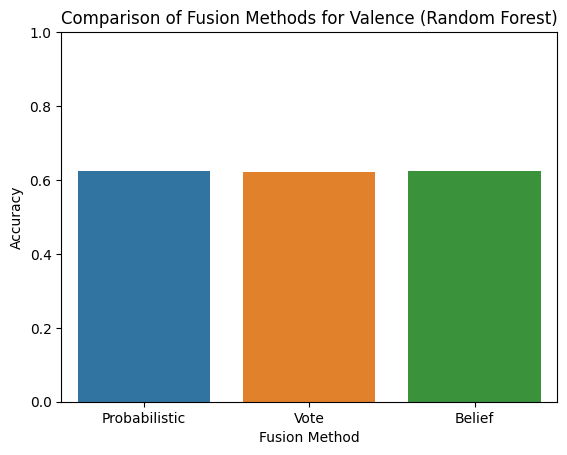

In [13]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- Fusion Functions (with a fix for BBA) ---
def fusion_probabiliste(probabilities_list):
    return np.mean(probabilities_list, axis=0)

def fusion_par_vote(predictions_list):
    predictions_array = np.array(predictions_list)
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_array)

def fusion_bba(probabilities_list):
    # This is a simplified conjunction. Adding an epsilon makes it more stable.
    fused_beliefs = probabilities_list[0]
    for probs in probabilities_list[1:]:
        denominator = (fused_beliefs * probs + (1 - fused_beliefs) * (1 - probs))
        # FIX 5: Avoid division by zero
        denominator[denominator == 0] = 1e-9 
        fused_beliefs = fused_beliefs * probs / denominator
    return fused_beliefs

# --- FIX 1: Define correct paths for metadata and channel data ---
metadata_folder_path = '/kaggle/input/deap-dataset/deap-dataset/Metadata/'
channel_data_folder_path = '/kaggle/working/' # Your processed data is here

# Read targets from the metadata folder
targets = pd.read_excel(os.path.join(metadata_folder_path, 'participant_ratings.xls'), index_col=0)
valence_targets = targets['Valence']
y = (valence_targets >= 4.5).astype(int)

# --- FIX 2: Split data ONCE before the loop for a consistent test set ---
# We split indices, which is a robust way to ensure all channels use the same split.
num_samples = len(y) # Total samples = 32 participants * 40 trials = 1280
indices = np.arange(num_samples)

# Split indices into training and testing sets, stratifying on the labels
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y
)

# This is our single, consistent set of true labels for final evaluation
y_test_final = y.iloc[test_indices]


# --- Main Processing Loop ---
scaler = StandardScaler()
probabilities_list = []
predictions_list = []
channel_names = []

# Define the hyperparameter grid for the Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Loop over the correct directory containing channel data
for ch_name in os.listdir(channel_data_folder_path):
    channel_full_path = os.path.join(channel_data_folder_path, ch_name)
    
    if os.path.isdir(channel_full_path):
        print(f"Processing channel: {ch_name}")
        ch_data = []
        for file_name in os.listdir(channel_full_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(channel_full_path, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)
        
        if not ch_data:
            print(f"  - No CSV files found in {ch_name}, skipping.")
            continue
            
        channel_names.append(ch_name)
        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        
        # --- FIX 4: Remove non-feature columns before creating X ---
        if 'trial' in ch_data.columns:
            ch_data = ch_data.drop(columns=['trial'])
            
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        # Use the pre-split indices to get consistent data subsets
        X_train = X_scaled[train_indices]
        X_test = X_scaled[test_indices]
        y_train = y.iloc[train_indices]
        # We will use y_test_final for evaluation

        # --- Random Forest Training with Grid Search ---
        rf = RandomForestClassifier(random_state=42)
        # Using n_jobs=-1 will use all available CPU cores, speeding up the search
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5), verbose=0, n_jobs=-1, refit=True)
        grid_search.fit(X_train, y_train)

        print(f"  - Best params for {ch_name}: {grid_search.best_params_}")
        best_rf = grid_search.best_estimator_

        # Get probabilities and predictions on the consistent test set
        probabilities = best_rf.predict_proba(X_test)[:, 1] # Probability of the positive class (1)
        predictions = best_rf.predict(X_test)
        
        probabilities_list.append(probabilities)
        predictions_list.append(predictions)

# --- Final Evaluation (Now outside the loop) ---
# Check if any models were trained before proceeding
if not probabilities_list:
    print("\nERROR: No channel data was processed. Cannot perform fusion.")
else:
    fused_probabilities = fusion_probabiliste(probabilities_list)
    fused_predictions_prob = (fused_probabilities > 0.5).astype(int)
    # --- FIX 3: Use the consistent y_test_final for evaluation ---
    accuracy_prob = accuracy_score(y_test_final, fused_predictions_prob)
    print(f"\nAccuracy after probabilistic fusion (Valence): {accuracy_prob:.2f}")

    fused_predictions_vote = fusion_par_vote(predictions_list)
    accuracy_vote = accuracy_score(y_test_final, fused_predictions_vote)
    print(f"Accuracy after majority vote fusion (Valence): {accuracy_vote:.2f}")

    fused_beliefs = fusion_bba(probabilities_list)
    fused_predictions_bba = (fused_beliefs > 0.5).astype(int)
    accuracy_bba = accuracy_score(y_test_final, fused_predictions_bba)
    print(f"Accuracy after belief-based fusion (Valence): {accuracy_bba:.2f}")

    fusion_results = pd.DataFrame({
        'Fusion Method': ['Probabilistic', 'Vote', 'Belief'],
        'Accuracy': [accuracy_prob, accuracy_vote, accuracy_bba]
    })

    sns.barplot(data=fusion_results, x='Fusion Method', y='Accuracy')
    plt.title('Comparison of Fusion Methods for Valence (Random Forest)')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    plt.show()

2. Arousal

Processing channel: FC1
  - Best params for FC1: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Processing channel: P8
  - Best params for P8: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Processing channel: AF4
  - Best params for AF4: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Processing channel: CP5
  - Best params for CP5: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Processing channel: F8
  - Best params for F8: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Processing channel: CP6
  - Best params for CP6: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Processing channel: F4
  - Best params for F4: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Processing channel: C4
  - Best params for C4: {'max_depth': 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


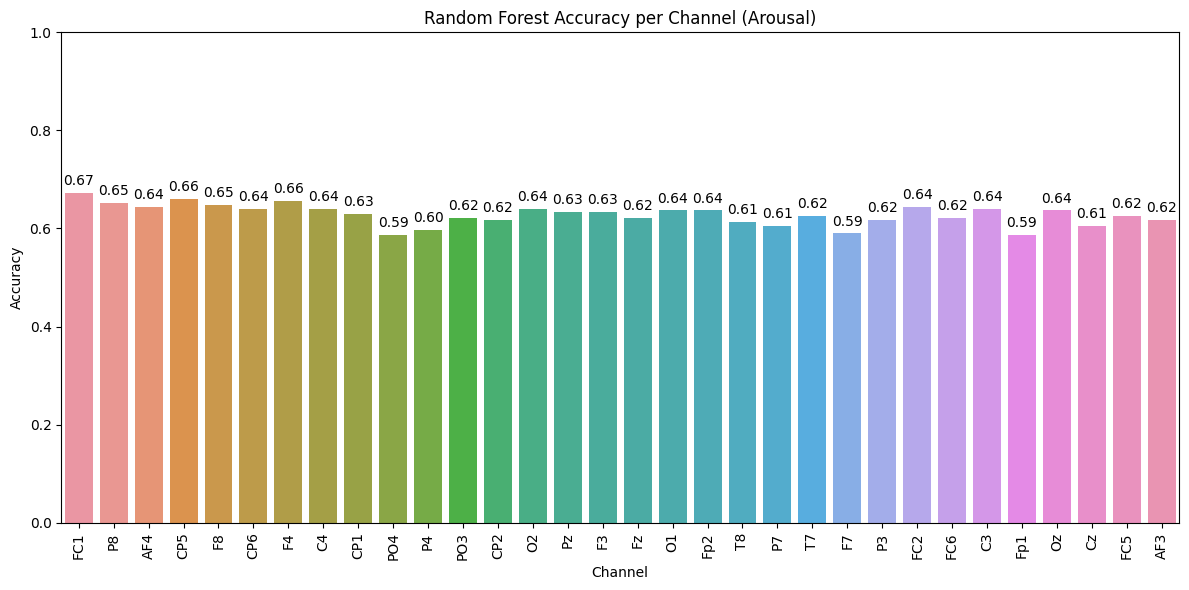

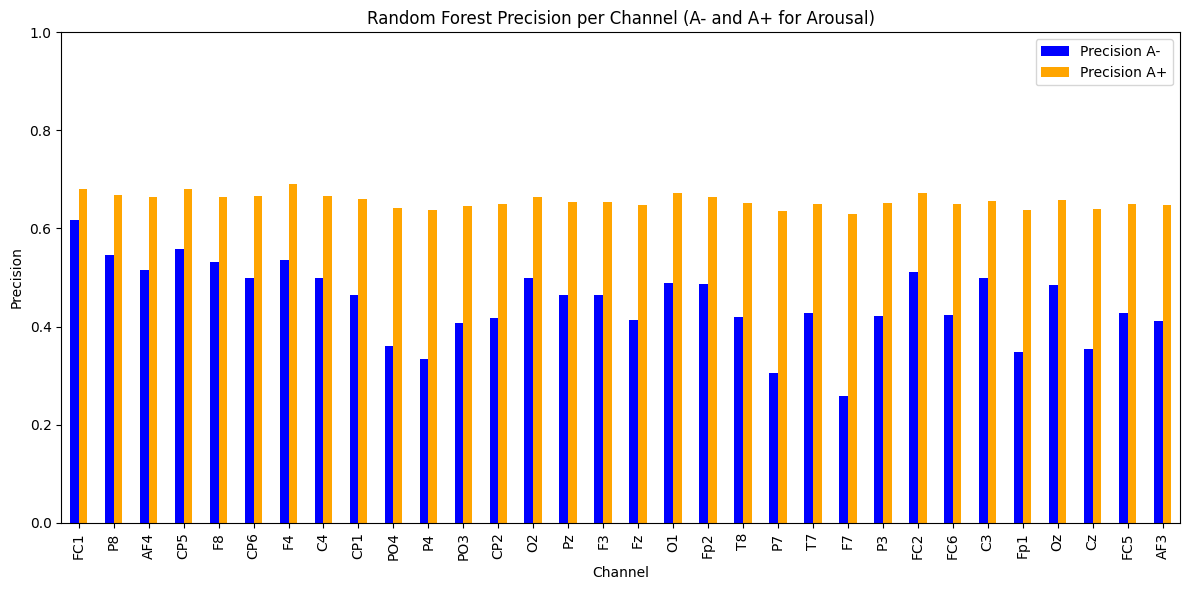

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- FIX 1: Define correct paths for metadata and channel data ---
metadata_folder_path = '/kaggle/input/deap-dataset/deap-dataset/Metadata/'
channel_data_folder_path = '/kaggle/working/' # Your processed data is here

# Read targets from the metadata folder for Arousal
targets = pd.read_excel(os.path.join(metadata_folder_path, 'participant_ratings.xls'), index_col=0)
arousal_targets = targets['Arousal']
y = (arousal_targets >= 4.5).astype(int)

# --- FIX 2: Split data ONCE before the loop for a consistent test set ---
# We split indices, which is a robust way to ensure all channels use the same split.
num_samples = len(y) # Total samples = 32 participants * 40 trials = 1280
indices = np.arange(num_samples)

# Split indices into training and testing sets, stratifying on the labels
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y
)

# This is our single, consistent set of true labels for testing all models
y_test_final = y.iloc[test_indices]


# --- Main Processing Loop ---
scaler = StandardScaler()
accuracies = []
precisions_a_minus = []
precisions_a_plus = []
channel_names = []

# Define the hyperparameter grid for the Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Loop over the correct directory containing channel data
for ch_name in os.listdir(channel_data_folder_path):
    channel_full_path = os.path.join(channel_data_folder_path, ch_name)
    
    if os.path.isdir(channel_full_path):
        print(f"Processing channel: {ch_name}")
        ch_data = []
        for file_name in os.listdir(channel_full_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(channel_full_path, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)
        
        if not ch_data:
            print(f"  - No CSV files found in {ch_name}, skipping.")
            continue
            
        channel_names.append(ch_name)
        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        
        # --- FIX 3: Remove non-feature columns before creating X ---
        if 'trial' in ch_data.columns:
            ch_data = ch_data.drop(columns=['trial'])
            
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        # Use the pre-split indices to get consistent data subsets
        X_train = X_scaled[train_indices]
        X_test = X_scaled[test_indices]
        y_train = y.iloc[train_indices]
        # We will use y_test_final for evaluation

        # --- Random Forest Training with Grid Search ---
        rf = RandomForestClassifier(random_state=42)
        # Using n_jobs=-1 will use all available CPU cores, speeding up the search
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5), verbose=0, n_jobs=-1, refit=True)
        grid_search.fit(X_train, y_train)

        print(f"  - Best params for {ch_name}: {grid_search.best_params_}")
        best_rf = grid_search.best_estimator_

        # Evaluate the best model on the consistent test set
        y_pred = best_rf.predict(X_test)
        accuracy = accuracy_score(y_test_final, y_pred)
        precision = precision_score(y_test_final, y_pred, average=None, zero_division=0)

        accuracies.append(accuracy)
        precisions_a_minus.append(precision[0])
        precisions_a_plus.append(precision[1])

# --- Plotting Results ---
# Check if any data was processed before trying to plot
if not channel_names:
    print("\nERROR: No channel data was processed. Cannot generate plots.")
else:
    channels = channel_names

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=channels, y=accuracies)
    plt.title("Random Forest Accuracy per Channel (Arousal)")
    plt.xlabel("Channel")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=90)
    plt.ylim(0, 1.0) # Set a consistent y-axis for accuracy

    for i, value in enumerate(accuracies):
        ax.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # --- FIX 4: Correct the variable names for the DataFrame ---
    precision_df = pd.DataFrame({
        'Channel': channels,
        'Precision A-': precisions_a_minus,
        'Precision A+': precisions_a_plus
    })

    precision_df.set_index('Channel', inplace=True)
    precision_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])

    plt.title("Random Forest Precision per Channel (A- and A+ for Arousal)")
    plt.xlabel("Channel")
    plt.ylabel("Precision")
    plt.xticks(rotation=90)
    plt.ylim(0, 1.0) # Set a consistent y-axis for precision
    plt.tight_layout()
    plt.show()

Processing channel: FC1
  - Best params for FC1: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Processing channel: P8
  - Best params for P8: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Processing channel: AF4
  - Best params for AF4: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Processing channel: CP5
  - Best params for CP5: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Processing channel: F8
  - Best params for F8: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Processing channel: CP6
  - Best params for CP6: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Processing channel: F4
  - Best params for F4: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Processing channel: C4
  - Best params for C4: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
Processing channel: CP1
  - Best params for CP1: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}

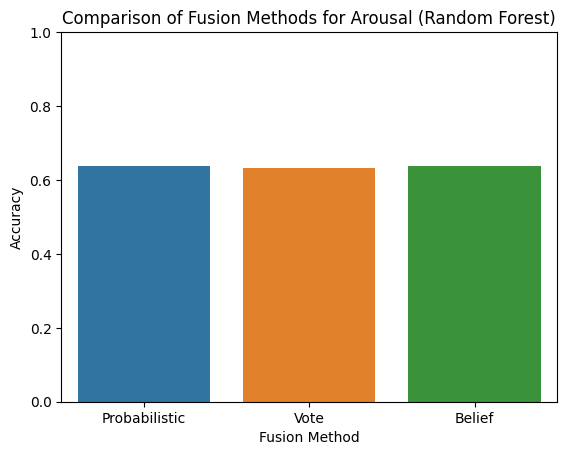

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- Fusion Functions (with a fix for BBA) ---
def fusion_probabiliste(probabilities_list):
    return np.mean(probabilities_list, axis=0)

def fusion_par_vote(predictions_list):
    predictions_array = np.array(predictions_list)
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_array)

def fusion_bba(probabilities_list):
    # This is a simplified conjunction. Adding an epsilon makes it more stable.
    fused_beliefs = probabilities_list[0]
    for probs in probabilities_list[1:]:
        denominator = (fused_beliefs * probs + (1 - fused_beliefs) * (1 - probs))
        # FIX 5: Avoid division by zero
        denominator[denominator == 0] = 1e-9 
        fused_beliefs = fused_beliefs * probs / denominator
    return fused_beliefs

# --- FIX 1: Define correct paths for metadata and channel data ---
metadata_folder_path = '/kaggle/input/deap-dataset/deap-dataset/Metadata/'
channel_data_folder_path = '/kaggle/working/' # Your processed data is here

# Read targets from the metadata folder for Arousal
targets = pd.read_excel(os.path.join(metadata_folder_path, 'participant_ratings.xls'), index_col=0)
arousal_targets = targets['Arousal']
y = (arousal_targets >= 4.5).astype(int)

# --- FIX 2: Split data ONCE before the loop for a consistent test set ---
# We split indices, which is a robust way to ensure all channels use the same split.
num_samples = len(y) # Total samples = 32 participants * 40 trials = 1280
indices = np.arange(num_samples)

# Split indices into training and testing sets, stratifying on the labels
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y
)

# This is our single, consistent set of true labels for final evaluation
y_test_final = y.iloc[test_indices]


# --- Main Processing Loop ---
scaler = StandardScaler()
probabilities_list = []
predictions_list = []
channel_names = []

# Define the hyperparameter grid for the Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Loop over the correct directory containing channel data
for ch_name in os.listdir(channel_data_folder_path):
    channel_full_path = os.path.join(channel_data_folder_path, ch_name)
    
    if os.path.isdir(channel_full_path):
        print(f"Processing channel: {ch_name}")
        ch_data = []
        for file_name in os.listdir(channel_full_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(channel_full_path, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)
        
        if not ch_data:
            print(f"  - No CSV files found in {ch_name}, skipping.")
            continue
            
        channel_names.append(ch_name)
        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        
        # --- FIX 4: Remove non-feature columns before creating X ---
        if 'trial' in ch_data.columns:
            ch_data = ch_data.drop(columns=['trial'])
            
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        # Use the pre-split indices to get consistent data subsets
        X_train = X_scaled[train_indices]
        X_test = X_scaled[test_indices]
        y_train = y.iloc[train_indices]
        # We will use y_test_final for evaluation

        # --- Random Forest Training with Grid Search ---
        rf = RandomForestClassifier(random_state=42)
        # Using n_jobs=-1 will use all available CPU cores, speeding up the search
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5), verbose=0, n_jobs=-1, refit=True)
        grid_search.fit(X_train, y_train)

        print(f"  - Best params for {ch_name}: {grid_search.best_params_}")
        best_rf = grid_search.best_estimator_

        # Get probabilities and predictions on the consistent test set
        probabilities = best_rf.predict_proba(X_test)[:, 1] # Probability of the positive class (1)
        predictions = best_rf.predict(X_test)
        
        probabilities_list.append(probabilities)
        predictions_list.append(predictions)

# --- Final Evaluation (Now outside the loop) ---
# Check if any models were trained before proceeding
if not probabilities_list:
    print("\nERROR: No channel data was processed. Cannot perform fusion.")
else:
    fused_probabilities = fusion_probabiliste(probabilities_list)
    fused_predictions_prob = (fused_probabilities > 0.5).astype(int)
    # --- FIX 3: Use the consistent y_test_final for evaluation ---
    accuracy_prob = accuracy_score(y_test_final, fused_predictions_prob)
    print(f"\nAccuracy after probabilistic fusion (Arousal): {accuracy_prob:.2f}")

    fused_predictions_vote = fusion_par_vote(predictions_list)
    accuracy_vote = accuracy_score(y_test_final, fused_predictions_vote)
    print(f"Accuracy after majority vote fusion (Arousal): {accuracy_vote:.2f}")

    fused_beliefs = fusion_bba(probabilities_list)
    fused_predictions_bba = (fused_beliefs > 0.5).astype(int)
    accuracy_bba = accuracy_score(y_test_final, fused_predictions_bba)
    print(f"Accuracy after belief-based fusion (Arousal): {accuracy_bba:.2f}")

    fusion_results = pd.DataFrame({
        'Fusion Method': ['Probabilistic', 'Vote', 'Belief'],
        'Accuracy': [accuracy_prob, accuracy_vote, accuracy_bba]
    })

    sns.barplot(data=fusion_results, x='Fusion Method', y='Accuracy')
    plt.title('Comparison of Fusion Methods for Arousal (Random Forest)')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    plt.show()

# KNN

1. Valence

Processing channel: FC1
  - Best params for FC1: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: P8
  - Best params for P8: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: AF4
  - Best params for AF4: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: CP5
  - Best params for CP5: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: F8
  - Best params for F8: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Processing channel: CP6
  - Best params for CP6: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: F4
  - Best params for F4: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: C4
  - Best params for C4: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: CP1
  - Best params for CP1: {'metric': 'manhattan', 'n_neighbors': 11, 'weig

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


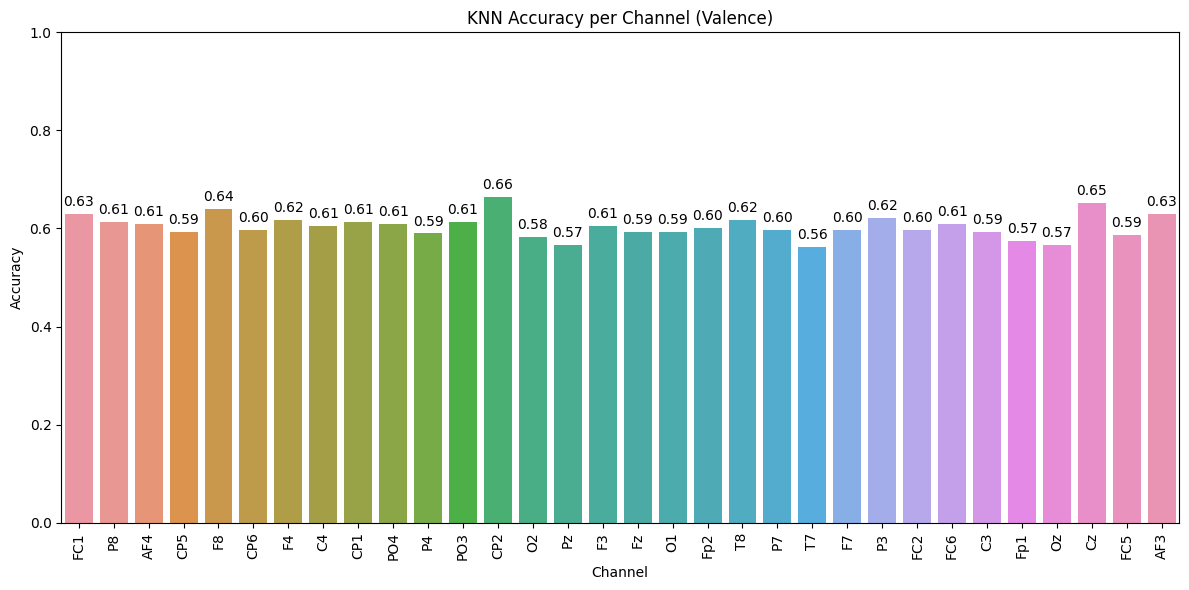

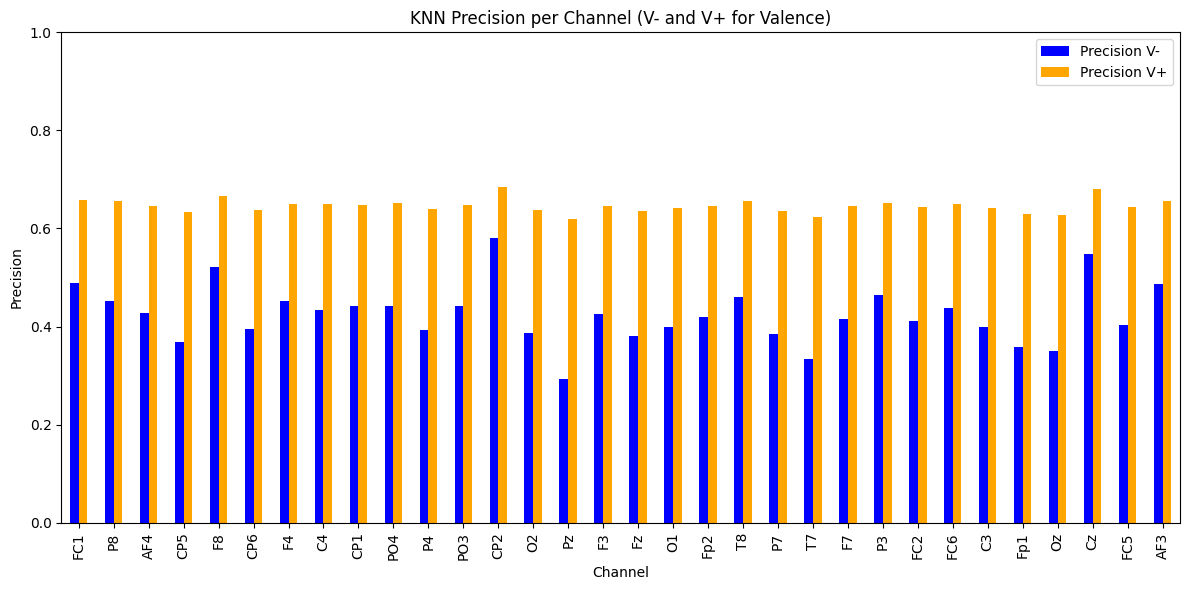

In [16]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- FIX 1: Define correct paths for metadata and channel data ---
metadata_folder_path = '/kaggle/input/deap-dataset/deap-dataset/Metadata/'
channel_data_folder_path = '/kaggle/working/' # Your processed data is here

# Read targets from the metadata folder for Valence
targets = pd.read_excel(os.path.join(metadata_folder_path, 'participant_ratings.xls'), index_col=0)
valence_targets = targets['Valence']
y = (valence_targets >= 4.5).astype(int)

# --- FIX 2: Split data ONCE before the loop for a consistent test set ---
# We split indices, which is a robust way to ensure all channels use the same split.
num_samples = len(y) # Total samples = 32 participants * 40 trials = 1280
indices = np.arange(num_samples)

# Split indices into training and testing sets, stratifying on the labels
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y
)

# This is our single, consistent set of true labels for testing all models
y_test_final = y.iloc[test_indices]


# --- Main Processing Loop ---
scaler = StandardScaler()
accuracies = []
precisions_v_minus = []
precisions_v_plus = []
channel_names = []

# Define the hyperparameter grid for the KNN classifier
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Loop over the correct directory containing channel data
for ch_name in os.listdir(channel_data_folder_path):
    channel_full_path = os.path.join(channel_data_folder_path, ch_name)
    
    if os.path.isdir(channel_full_path):
        print(f"Processing channel: {ch_name}")
        ch_data = []
        for file_name in os.listdir(channel_full_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(channel_full_path, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)
        
        if not ch_data:
            print(f"  - No CSV files found in {ch_name}, skipping.")
            continue
            
        channel_names.append(ch_name)
        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        
        # --- FIX 3: Remove non-feature columns before creating X ---
        if 'trial' in ch_data.columns:
            ch_data = ch_data.drop(columns=['trial'])
            
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        # Use the pre-split indices to get consistent data subsets
        X_train = X_scaled[train_indices]
        X_test = X_scaled[test_indices]
        y_train = y.iloc[train_indices]
        # We will use y_test_final for evaluation

        # --- KNN Training with Grid Search ---
        knn = KNeighborsClassifier()
        # Using n_jobs=-1 will use all available CPU cores, speeding up the search
        grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5), verbose=0, n_jobs=-1, refit=True)
        grid_search.fit(X_train, y_train)

        print(f"  - Best params for {ch_name}: {grid_search.best_params_}")
        best_knn = grid_search.best_estimator_

        # Evaluate the best model on the consistent test set
        y_pred = best_knn.predict(X_test)
        accuracy = accuracy_score(y_test_final, y_pred)
        precision = precision_score(y_test_final, y_pred, average=None, zero_division=0)

        accuracies.append(accuracy)
        precisions_v_minus.append(precision[0])
        precisions_v_plus.append(precision[1])

# --- Plotting Results ---
# Check if any data was processed before trying to plot
if not channel_names:
    print("\nERROR: No channel data was processed. Cannot generate plots.")
else:
    channels = channel_names

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=channels, y=accuracies)
    plt.title("KNN Accuracy per Channel (Valence)")
    plt.xlabel("Channel")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=90)
    plt.ylim(0, 1.0) # Set a consistent y-axis for accuracy

    for i, value in enumerate(accuracies):
        ax.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    precision_df = pd.DataFrame({
        'Channel': channels,
        'Precision V-': precisions_v_minus,
        'Precision V+': precisions_v_plus
    })

    precision_df.set_index('Channel', inplace=True)
    precision_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])

    plt.title("KNN Precision per Channel (V- and V+ for Valence)")
    plt.xlabel("Channel")
    plt.ylabel("Precision")
    plt.xticks(rotation=90)
    plt.ylim(0, 1.0) # Set a consistent y-axis for precision
    plt.tight_layout()
    plt.show()

Processing channel: FC1
  - Best params for FC1: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: P8
  - Best params for P8: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: AF4
  - Best params for AF4: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: CP5
  - Best params for CP5: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: F8
  - Best params for F8: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Processing channel: CP6
  - Best params for CP6: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: F4
  - Best params for F4: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: C4
  - Best params for C4: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: CP1
  - Best params for CP1: {'metric': 'manhattan', 'n_neighbors': 11, 'weig

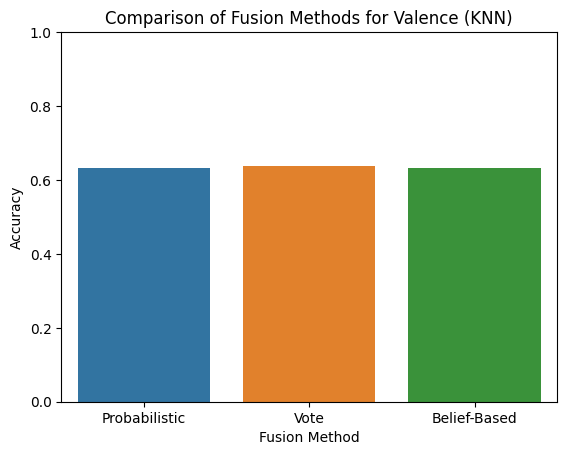

In [17]:
import pandas as pd
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- Fusion Functions (with a fix for BBA) ---
def fusion_probabiliste(probabilities_list):
    return np.mean(probabilities_list, axis=0)

def fusion_par_vote(predictions_list):
    predictions_array = np.array(predictions_list)
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_array)

def fusion_bba(probabilities_list):
    # This is a simplified conjunction. Adding an epsilon makes it more stable.
    fused_beliefs = probabilities_list[0]
    for probs in probabilities_list[1:]:
        denominator = (fused_beliefs * probs + (1 - fused_beliefs) * (1 - probs))
        # FIX 5: Avoid division by zero
        denominator[denominator == 0] = 1e-9 
        fused_beliefs = fused_beliefs * probs / denominator
    return fused_beliefs

# --- FIX 1: Define correct paths for metadata and channel data ---
metadata_folder_path = '/kaggle/input/deap-dataset/deap-dataset/Metadata/'
channel_data_folder_path = '/kaggle/working/' # Your processed data is here

# Read targets from the metadata folder for Valence
targets = pd.read_excel(os.path.join(metadata_folder_path, 'participant_ratings.xls'), index_col=0)
valence_targets = targets['Valence']
y = (valence_targets >= 4.5).astype(int)

# --- FIX 2: Split data ONCE before the loop for a consistent test set ---
# We split indices, which is a robust way to ensure all channels use the same split.
num_samples = len(y) # Total samples = 32 participants * 40 trials = 1280
indices = np.arange(num_samples)

# Split indices into training and testing sets, stratifying on the labels
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y
)

# This is our single, consistent set of true labels for final evaluation
y_test_final = y.iloc[test_indices]


# --- Main Processing Loop ---
scaler = StandardScaler()
probabilities_list = []
predictions_list = []
channel_names = []

# Define the hyperparameter grid for the KNN classifier
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'] # p=2 is euclidean, p=1 is manhattan
}

# Loop over the correct directory containing channel data
for ch_name in os.listdir(channel_data_folder_path):
    channel_full_path = os.path.join(channel_data_folder_path, ch_name)
    
    if os.path.isdir(channel_full_path):
        print(f"Processing channel: {ch_name}")
        ch_data = []
        for file_name in os.listdir(channel_full_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(channel_full_path, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)
        
        if not ch_data:
            print(f"  - No CSV files found in {ch_name}, skipping.")
            continue
            
        channel_names.append(ch_name)
        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        
        # --- FIX 4: Remove non-feature columns before creating X ---
        if 'trial' in ch_data.columns:
            ch_data = ch_data.drop(columns=['trial'])
            
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        # Use the pre-split indices to get consistent data subsets
        X_train = X_scaled[train_indices]
        X_test = X_scaled[test_indices]
        y_train = y.iloc[train_indices]
        # We will use y_test_final for evaluation

        # --- KNN Training with Grid Search ---
        knn = KNeighborsClassifier()
        # Using n_jobs=-1 will use all available CPU cores, speeding up the search
        grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5), verbose=0, n_jobs=-1, refit=True)
        grid_search.fit(X_train, y_train)

        print(f"  - Best params for {ch_name}: {grid_search.best_params_}")
        best_knn = grid_search.best_estimator_

        # Get probabilities and predictions on the consistent test set
        probabilities = best_knn.predict_proba(X_test)[:, 1] # Probability of the positive class (1)
        predictions = best_knn.predict(X_test)
        
        probabilities_list.append(probabilities)
        predictions_list.append(predictions)

# --- Final Evaluation (Now outside the loop) ---
# Check if any models were trained before proceeding
if not probabilities_list:
    print("\nERROR: No channel data was processed. Cannot perform fusion.")
else:
    fused_probabilities = fusion_probabiliste(probabilities_list)
    fused_predictions_prob = (fused_probabilities > 0.5).astype(int)
    # --- FIX 3: Use the consistent y_test_final for evaluation ---
    accuracy_prob = accuracy_score(y_test_final, fused_predictions_prob)
    print(f"\nAccuracy after probabilistic fusion (Valence): {accuracy_prob:.2f}")

    fused_predictions_vote = fusion_par_vote(predictions_list)
    accuracy_vote = accuracy_score(y_test_final, fused_predictions_vote)
    print(f"Accuracy after majority vote fusion (Valence): {accuracy_vote:.2f}")

    fused_beliefs = fusion_bba(probabilities_list)
    fused_predictions_bba = (fused_beliefs > 0.5).astype(int)
    accuracy_bba = accuracy_score(y_test_final, fused_predictions_bba)
    print(f"Accuracy after belief-based fusion (Valence): {accuracy_bba:.2f}")

    fusion_results = pd.DataFrame({
        'Fusion Method': ['Probabilistic', 'Vote', 'Belief-Based'],
        'Accuracy': [accuracy_prob, accuracy_vote, accuracy_bba]
    })

    sns.barplot(data=fusion_results, x='Fusion Method', y='Accuracy')
    plt.title('Comparison of Fusion Methods for Valence (KNN)')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    plt.show()

2. Arousal

Processing channel: FC1
  - Best params for FC1: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Processing channel: P8
  - Best params for P8: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
Processing channel: AF4
  - Best params for AF4: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: CP5
  - Best params for CP5: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
Processing channel: F8
  - Best params for F8: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: CP6
  - Best params for CP6: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
Processing channel: F4
  - Best params for F4: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Processing channel: C4
  - Best params for C4: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: CP1
  - Best params for CP1: {'metric': 'euclidean', 'n_neighbors': 11, 'we

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


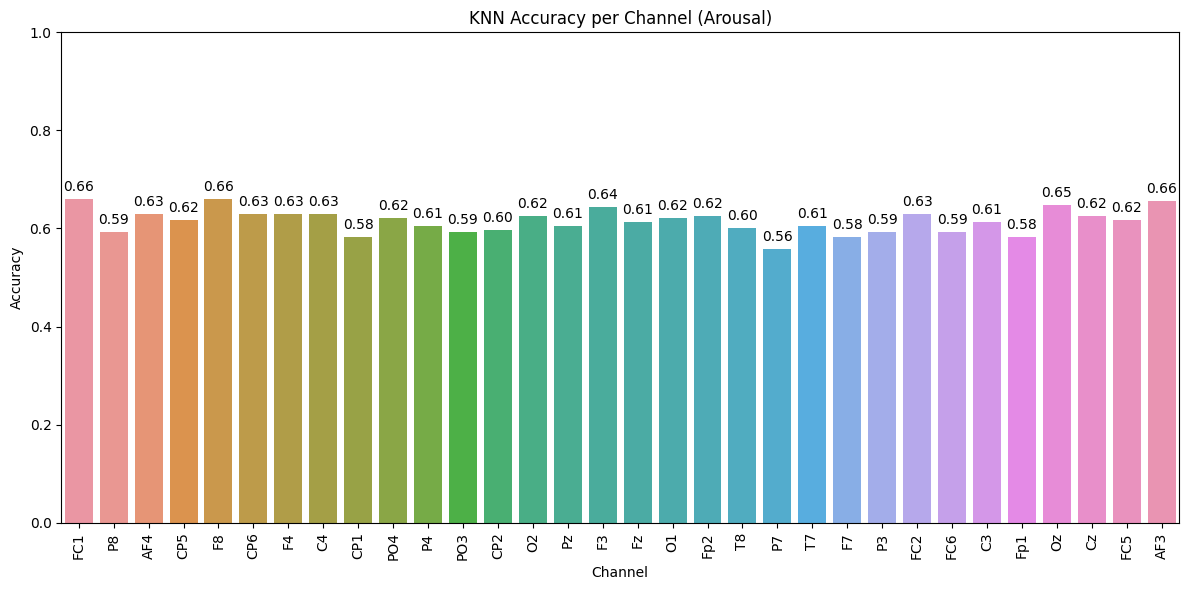

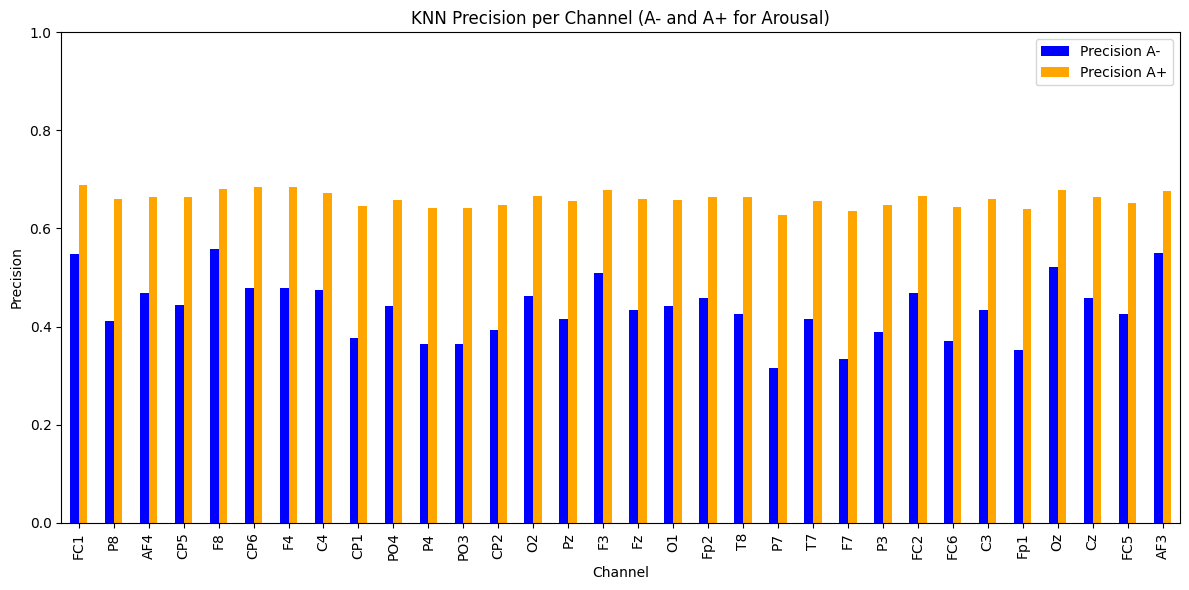

In [18]:
import pandas as pd
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- FIX 1: Define correct paths for metadata and channel data ---
metadata_folder_path = '/kaggle/input/deap-dataset/deap-dataset/Metadata/'
channel_data_folder_path = '/kaggle/working/' # Your processed data is here

# Read targets from the metadata folder for Arousal
targets = pd.read_excel(os.path.join(metadata_folder_path, 'participant_ratings.xls'), index_col=0)
arousal_targets = targets['Arousal']
y = (arousal_targets >= 4.5).astype(int)

# --- FIX 2: Split data ONCE before the loop for a consistent test set ---
# We split indices, which is a robust way to ensure all channels use the same split.
num_samples = len(y) # Total samples = 32 participants * 40 trials = 1280
indices = np.arange(num_samples)

# Split indices into training and testing sets, stratifying on the labels
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y
)

# This is our single, consistent set of true labels for testing all models
y_test_final = y.iloc[test_indices]


# --- Main Processing Loop ---
scaler = StandardScaler()
accuracies = []
precisions_a_minus = []
precisions_a_plus = []
channel_names = []

# Define the hyperparameter grid for the KNN classifier
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'] # p=2 is euclidean, p=1 is manhattan
}

# Loop over the correct directory containing channel data
for ch_name in os.listdir(channel_data_folder_path):
    channel_full_path = os.path.join(channel_data_folder_path, ch_name)
    
    if os.path.isdir(channel_full_path):
        print(f"Processing channel: {ch_name}")
        ch_data = []
        for file_name in os.listdir(channel_full_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(channel_full_path, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)
        
        if not ch_data:
            print(f"  - No CSV files found in {ch_name}, skipping.")
            continue
            
        channel_names.append(ch_name)
        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        
        # --- FIX 3: Remove non-feature columns before creating X ---
        if 'trial' in ch_data.columns:
            ch_data = ch_data.drop(columns=['trial'])
            
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        # Use the pre-split indices to get consistent data subsets
        X_train = X_scaled[train_indices]
        X_test = X_scaled[test_indices]
        y_train = y.iloc[train_indices]
        # We will use y_test_final for evaluation

        # --- KNN Training with Grid Search ---
        knn = KNeighborsClassifier()
        # Using n_jobs=-1 will use all available CPU cores, speeding up the search
        grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5), verbose=0, n_jobs=-1, refit=True)
        grid_search.fit(X_train, y_train)

        print(f"  - Best params for {ch_name}: {grid_search.best_params_}")
        best_knn = grid_search.best_estimator_

        # Evaluate the best model on the consistent test set
        y_pred = best_knn.predict(X_test)
        accuracy = accuracy_score(y_test_final, y_pred)
        precision = precision_score(y_test_final, y_pred, average=None, zero_division=0)

        accuracies.append(accuracy)
        precisions_a_minus.append(precision[0])
        precisions_a_plus.append(precision[1])

# --- Plotting Results ---
# Check if any data was processed before trying to plot
if not channel_names:
    print("\nERROR: No channel data was processed. Cannot generate plots.")
else:
    channels = channel_names

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=channels, y=accuracies)
    plt.title("KNN Accuracy per Channel (Arousal)")
    plt.xlabel("Channel")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=90)
    plt.ylim(0, 1.0) # Set a consistent y-axis for accuracy

    for i, value in enumerate(accuracies):
        ax.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    precision_df = pd.DataFrame({
        'Channel': channels,
        'Precision A-': precisions_a_minus,
        'Precision A+': precisions_a_plus
    })

    precision_df.set_index('Channel', inplace=True)
    precision_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])

    plt.title("KNN Precision per Channel (A- and A+ for Arousal)")
    plt.xlabel("Channel")
    plt.ylabel("Precision")
    plt.xticks(rotation=90)
    plt.ylim(0, 1.0) # Set a consistent y-axis for precision
    plt.tight_layout()
    plt.show()

Processing channel: FC1
  - Best params for FC1: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Processing channel: P8
  - Best params for P8: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
Processing channel: AF4
  - Best params for AF4: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: CP5
  - Best params for CP5: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
Processing channel: F8
  - Best params for F8: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: CP6
  - Best params for CP6: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
Processing channel: F4
  - Best params for F4: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Processing channel: C4
  - Best params for C4: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Processing channel: CP1
  - Best params for CP1: {'metric': 'euclidean', 'n_neighbors': 11, 'we

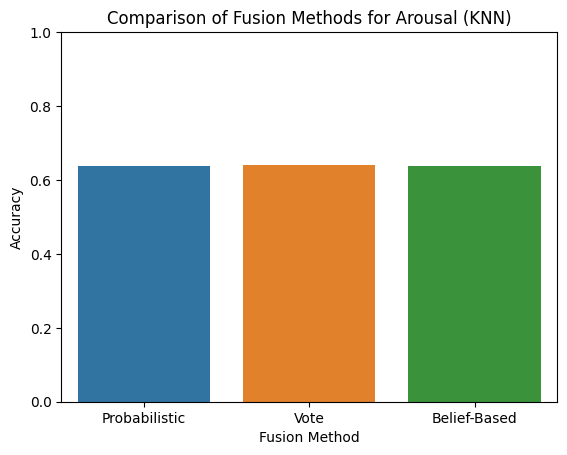

In [19]:
import pandas as pd
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- Fusion Functions (with a fix for BBA) ---
def fusion_probabiliste(probabilities_list):
    return np.mean(probabilities_list, axis=0)

def fusion_par_vote(predictions_list):
    predictions_array = np.array(predictions_list)
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_array)

def fusion_bba(probabilities_list):
    # This is a simplified conjunction. Adding an epsilon makes it more stable.
    fused_beliefs = probabilities_list[0]
    for probs in probabilities_list[1:]:
        denominator = (fused_beliefs * probs + (1 - fused_beliefs) * (1 - probs))
        # FIX 5: Avoid division by zero
        denominator[denominator == 0] = 1e-9 
        fused_beliefs = fused_beliefs * probs / denominator
    return fused_beliefs

# --- FIX 1: Define correct paths for metadata and channel data ---
metadata_folder_path = '/kaggle/input/deap-dataset/deap-dataset/Metadata/'
channel_data_folder_path = '/kaggle/working/' # Your processed data is here

# Read targets from the metadata folder for Arousal
targets = pd.read_excel(os.path.join(metadata_folder_path, 'participant_ratings.xls'), index_col=0)
arousal_targets = targets['Arousal']
y = (arousal_targets >= 4.5).astype(int)

# --- FIX 2: Split data ONCE before the loop for a consistent test set ---
# We split indices, which is a robust way to ensure all channels use the same split.
num_samples = len(y) # Total samples = 32 participants * 40 trials = 1280
indices = np.arange(num_samples)

# Split indices into training and testing sets, stratifying on the labels
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=y
)

# This is our single, consistent set of true labels for final evaluation
y_test_final = y.iloc[test_indices]


# --- Main Processing Loop ---
scaler = StandardScaler()
probabilities_list = []
predictions_list = []
channel_names = []

# Define the hyperparameter grid for the KNN classifier
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'] # p=2 is euclidean, p=1 is manhattan
}

# Loop over the correct directory containing channel data
for ch_name in os.listdir(channel_data_folder_path):
    channel_full_path = os.path.join(channel_data_folder_path, ch_name)
    
    if os.path.isdir(channel_full_path):
        print(f"Processing channel: {ch_name}")
        ch_data = []
        for file_name in os.listdir(channel_full_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(channel_full_path, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)
        
        if not ch_data:
            print(f"  - No CSV files found in {ch_name}, skipping.")
            continue
            
        channel_names.append(ch_name)
        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        
        # --- FIX 4: Remove non-feature columns before creating X ---
        if 'trial' in ch_data.columns:
            ch_data = ch_data.drop(columns=['trial'])
            
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        # Use the pre-split indices to get consistent data subsets
        X_train = X_scaled[train_indices]
        X_test = X_scaled[test_indices]
        y_train = y.iloc[train_indices]
        # We will use y_test_final for evaluation

        # --- KNN Training with Grid Search ---
        knn = KNeighborsClassifier()
        # Using n_jobs=-1 will use all available CPU cores, speeding up the search
        grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5), verbose=0, n_jobs=-1, refit=True)
        grid_search.fit(X_train, y_train)

        print(f"  - Best params for {ch_name}: {grid_search.best_params_}")
        best_knn = grid_search.best_estimator_

        # Get probabilities and predictions on the consistent test set
        probabilities = best_knn.predict_proba(X_test)[:, 1] # Probability of the positive class (1)
        predictions = best_knn.predict(X_test)
        
        probabilities_list.append(probabilities)
        predictions_list.append(predictions)

# --- Final Evaluation (Now outside the loop) ---
# Check if any models were trained before proceeding
if not probabilities_list:
    print("\nERROR: No channel data was processed. Cannot perform fusion.")
else:
    fused_probabilities = fusion_probabiliste(probabilities_list)
    fused_predictions_prob = (fused_probabilities > 0.5).astype(int)
    # --- FIX 3: Use the consistent y_test_final for evaluation ---
    accuracy_prob = accuracy_score(y_test_final, fused_predictions_prob)
    print(f"\nAccuracy after probabilistic fusion (Arousal): {accuracy_prob:.2f}")

    fused_predictions_vote = fusion_par_vote(predictions_list)
    accuracy_vote = accuracy_score(y_test_final, fused_predictions_vote)
    print(f"Accuracy after majority vote fusion (Arousal): {accuracy_vote:.2f}")

    fused_beliefs = fusion_bba(probabilities_list)
    fused_predictions_bba = (fused_beliefs > 0.5).astype(int)
    accuracy_bba = accuracy_score(y_test_final, fused_predictions_bba)
    print(f"Accuracy after belief-based fusion (Arousal): {accuracy_bba:.2f}")

    fusion_results = pd.DataFrame({
        'Fusion Method': ['Probabilistic', 'Vote', 'Belief-Based'],
        'Accuracy': [accuracy_prob, accuracy_vote, accuracy_bba]
    })

    sns.barplot(data=fusion_results, x='Fusion Method', y='Accuracy')
    plt.title('Comparison of Fusion Methods for Arousal (KNN)')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    plt.show()

# Fusion au niveau des caractéristiques (Features Fusion)


# **Feature Extraction and labeling**

In [20]:
eeg_data = data[:,:32,:]
print(eeg_data.shape)

(40, 32, 8064)


In [21]:
import numpy as np
from scipy.signal import welch
# FIX 1: Import 'trapezoid' instead of the old 'simps'
from scipy.integrate import trapezoid

def bandpower(data, sf, band):
    band = np.asarray(band)
    low, high = band
    # Ensure nperseg is at least 2, handle potential division by zero if low is 0
    if low == 0:
        low = 1e-6 # Avoid division by zero, use a very small number
    nperseg = (2 / low) * sf
    
    freqs, psd = welch(data, sf, nperseg=nperseg)
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    
    # FIX 2: Call 'trapezoid' instead of 'simps'
    bp = trapezoid(psd[idx_band], dx=freq_res)
    return bp

# This function relies on a global variable 'eeg_data'.
# Make sure 'eeg_data' is defined before calling this function.
def get_band_power(people, channel, band):
    bd = (0,0)
    if (band == "alpha"):
        bd = (8,12)
    elif (band == "beta"):
        bd = (12,30)
    elif (band == "gamma"):
        bd = (30,64)
    
    # This will raise a NameError if 'eeg_data' is not defined in the global scope.
    return bandpower(eeg_data[people,channel], 128, bd)

In [22]:
eeg_band = []
for i in range (len(eeg_data)):
    for j in range (len(eeg_data[0])):
        eeg_band.append(get_band_power(i,j,"alpha"))
        eeg_band.append(get_band_power(i,j,"beta"))
        eeg_band.append(get_band_power(i,j,"gamma"))

print(eeg_band)

[10.168688031387925, 30.09461801410142, 35.0601051907323, 53.24392474925595, 48.170074203469966, 38.926249831145526, 5.4536423001647325, 10.479721850363383, 8.040704820538503, 44.15226051377682, 32.88238641386638, 14.396963266634947, 37.128546098802936, 23.003184477064387, 10.652778352606731, 5.616984003454321, 5.283775799527104, 1.892785200211868, 30.503661288309342, 18.106407137466793, 9.020323302896774, 55.96987282814798, 32.87686238875769, 13.68444921620041, 97.31068467914506, 55.18144675945949, 27.02110879927153, 22.826805732207234, 16.951490291879743, 5.498184467575667, 13.686932612387876, 10.941991482419606, 4.061642522962993, 14.556608544829553, 12.720543608204789, 5.8472292811040205, 35.054043559887084, 25.39517267538584, 7.7774608679133355, 19.6208475901645, 15.090890325670994, 6.824534447808551, 3.764292358824931, 5.208183633436334, 1.2297724734324937, 23.96338345149956, 18.444949239579067, 5.482370150611045, 8.98224937460963, 15.914599643575631, 14.350859162973492, 15.05459

In [23]:
eeg_band = np.array(eeg_band)
eeg_band = eeg_band.reshape((1280,3)) # 5×32
print(eeg_band.shape)
print(eeg_band)

(1280, 3)
[[ 10.16868803  30.09461801  35.06010519]
 [ 53.24392475  48.1700742   38.92624983]
 [  5.4536423   10.47972185   8.04070482]
 ...
 [ 29.22065104  19.88401521   6.86682486]
 [269.94456745 135.29106184  37.63974124]
 [ 17.48662794  12.52203336   3.8927613 ]]


In [24]:
np.save("eeg_band.npy", eeg_band)
eeg_band = np.load("eeg_band.npy")
print(eeg_band.shape)

(1280, 3)


## Construire les données de l’étiquette

In [25]:
import pandas as pd

df_label = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1],
                        'Dominance': labels[:,2], 'Liking': labels[:,3]})
df_label

,Valence,Arousal,Dominance,Liking
0,1.29,1.40,6.90,7.83
1,0.90,1.69,7.28,8.47
2,0.42,1.46,9.00,7.08
3,4.94,6.01,6.12,8.06
4,6.96,3.92,7.19,6.05
...,...,...,...,...
1275,3.91,6.96,5.82,3.12
1276,2.81,6.13,6.06,1.04
1277,3.05,7.01,5.10,1.10
1278,3.99,7.17,4.85,1.00


In [26]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Valence    1280 non-null   float64
 1   Arousal    1280 non-null   float64
 2   Dominance  1280 non-null   float64
 3   Liking     1280 non-null   float64
dtypes: float64(4)
memory usage: 40.1 KB


In [27]:
df_label.describe()

,Valence,Arousal,Dominance,Liking
count,1280.000000,1280.000000,1280.000000,1280.000000
mean,3.465484,3.730070,5.382750,5.518133
std,2.009664,1.980093,2.096321,2.282780
min,0.000000,0.000000,1.000000,1.000000
25%,1.950000,2.060000,3.932500,3.960000
50%,3.080000,3.315000,5.240000,6.050000
75%,4.950000,4.990000,7.040000,7.090000
max,9.000000,9.000000,9.000000,9.000000


In [28]:
label_name = ["valence","arousal"]
labels_valence = []
labels_arousal = []
for la in labels:
    l = []
    if la[0]>4.5:
        labels_valence.append(1)
    else:
        labels_valence.append(0)
    if la[1]>4.5:
        labels_arousal.append(1)
    else:
        labels_arousal.append(0)

# Création de modèles, formation, tests et optimisation

# **Classification**

In [29]:
#Données X
data_x = eeg_band
print(data_x.shape)

#Données Y
label_y0 = labels_valence
label_y1 = labels_arousal
trainscores = []
testscores = []

(1280, 3)


## KNN

## Valence

In [30]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

poly = preprocessing.PolynomialFeatures(degree=1)
X = poly.fit_transform(data_x)

scaler = preprocessing.StandardScaler()  # Standardisation
X = scaler.fit_transform(X)

# Réduction de la dimensionnalité
pca = PCA(n_components=0.95)  # Ajuster pour conserver 95% de la variance
X = pca.fit_transform(X)
print(X.shape)

# Division des données
X_train, X_test, y_train, y_test = train_test_split(X, label_y0, test_size=0.20, random_state=42)

# Recherche des hyperparamètres
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres :", grid_search.best_params_)

# Modèle optimisé
knn_best = grid_search.best_estimator_
train_score_V_KNN = knn_best.score(X_train, y_train)
test_score_V_KNN = knn_best.score(X_test, y_test)

print("Score de l’ensemble d’entraînement :", train_score_V_KNN)
print("Score de l’ensemble de tests :", test_score_V_KNN)

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(knn_best, X, label_y0, cv=5, scoring='accuracy')
print("Scores de validation croisée :", cv_scores)
print("Score moyen de validation croisée :", cv_scores.mean())

(1280, 1)
Meilleurs paramètres : {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
Score de l’ensemble d’entraînement : 0.7255859375
Score de l’ensemble de tests : 0.69140625
Scores de validation croisée : [0.6953125  0.71875    0.7109375  0.69921875 0.703125  ]
Score moyen de validation croisée : 0.70546875


## Arousal

In [31]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Prétraitement
poly = preprocessing.PolynomialFeatures(degree=1)  # Réduction du degré
X = poly.fit_transform(data_x)

scaler = preprocessing.StandardScaler()  # Standardisation
X = scaler.fit_transform(X)

# Réduction de la dimensionnalité
pca = PCA(n_components=0.95)  # Ajuster pour conserver 95% de la variance
X = pca.fit_transform(X)
print(X.shape)

# Division des données
X_train, X_test, y_train, y_test = train_test_split(X, label_y1, test_size=0.20, random_state=42)

# Recherche des hyperparamètres
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres :", grid_search.best_params_)

# Modèle optimisé
knn_best = grid_search.best_estimator_
train_score_A_KNN = knn_best.score(X_train, y_train)
test_score_A_KNN = knn_best.score(X_test, y_test)

print("Score de l’ensemble d’entraînement :", train_score_A_KNN)
print("Score de l’ensemble de tests :", test_score_A_KNN)


from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(knn_best, X, label_y1, cv=5, scoring='accuracy')
print("Scores de validation croisée :", cv_scores)
print("Score moyen de validation croisée :", cv_scores.mean())

(1280, 1)
Meilleurs paramètres : {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
Score de l’ensemble d’entraînement : 0.7158203125
Score de l’ensemble de tests : 0.71875
Scores de validation croisée : [0.68359375 0.68359375 0.703125   0.70703125 0.7109375 ]
Score moyen de validation croisée : 0.69765625


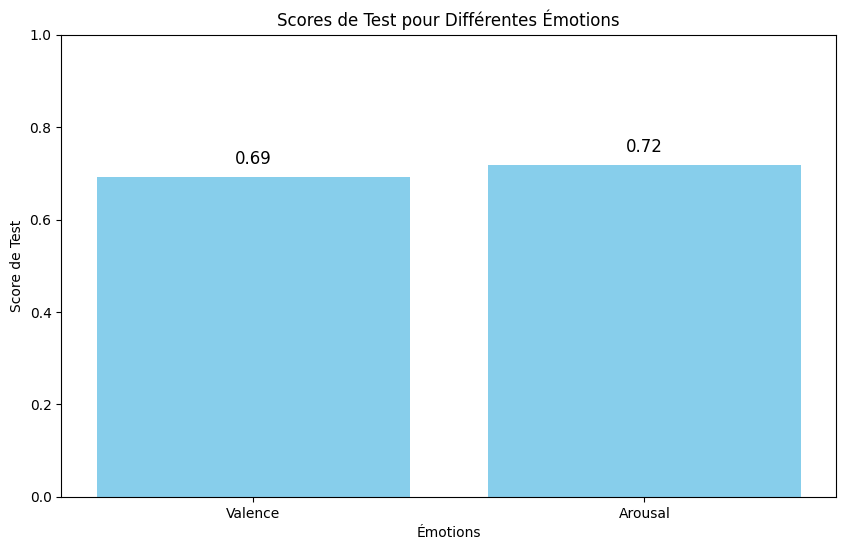

In [32]:
import matplotlib.pyplot as plt

emotions = ['Valence', 'Arousal']
testscores = [test_score_V_KNN, test_score_A_KNN]
plt.figure(figsize=(10,6))
bars = plt.bar(emotions, testscores, color='skyblue')
plt.xlabel('Émotions')
plt.ylabel('Score de Test')
plt.title('Scores de Test pour Différentes Émotions')
plt.ylim(0, 1)

for bar, score in zip(bars, testscores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()

## SVM

## Valence

In [33]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import numpy as np

poly = preprocessing.PolynomialFeatures(degree=1)
X = poly.fit_transform(data_x)

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X = pca.fit_transform(X)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, label_y0, test_size=0.20, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear', 'poly']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres : {grid_search.best_params_}")

svc = grid_search.best_estimator_
train_score_V_SVM = svc.score(X_train, y_train)
test_score_V_SVM = svc.score(X_test, y_test)

print(f"Score de l’ensemble d’entraînement : {train_score_V_SVM}")
print(f"Score de l’ensemble de tests : {test_score_V_SVM}")

(1280, 1)
Meilleurs paramètres : {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
Score de l’ensemble d’entraînement : 0.708984375
Score de l’ensemble de tests : 0.72265625


## Arousal

In [34]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import numpy as np

poly = preprocessing.PolynomialFeatures(degree=1)
X = poly.fit_transform(data_x)

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X = pca.fit_transform(X)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, label_y1, test_size=0.20, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear', 'poly']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres : {grid_search.best_params_}")

svc = grid_search.best_estimator_
train_score_A_SVM = svc.score(X_train, y_train)
test_score_A_SVM = svc.score(X_test, y_test)

print(f"Score de l’ensemble d’entraînement : {train_score_A_SVM}")
print(f"Score de l’ensemble de tests : {test_score_A_SVM}")

(1280, 1)
Meilleurs paramètres : {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
Score de l’ensemble d’entraînement : 0.7021484375
Score de l’ensemble de tests : 0.71875


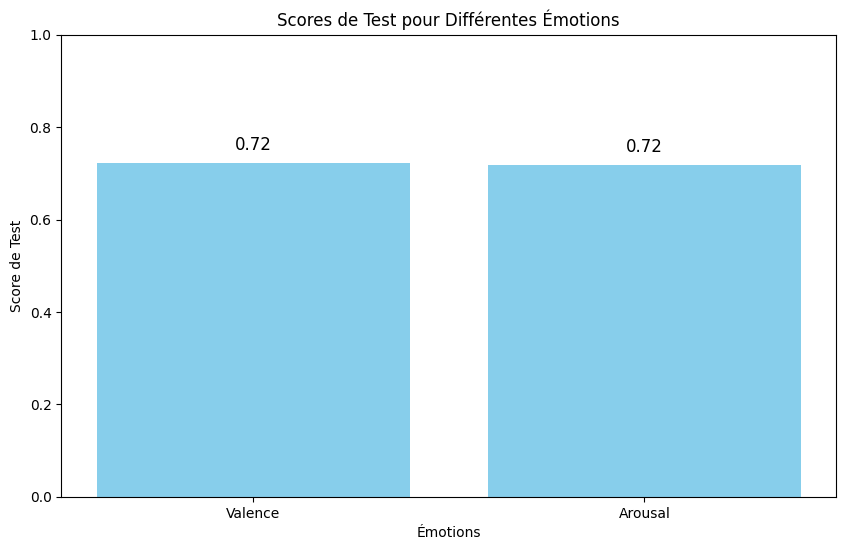

In [35]:
import matplotlib.pyplot as plt

emotions = ['Valence', 'Arousal']
testscores1 = [test_score_V_SVM, test_score_A_SVM]
plt.figure(figsize=(10,6))
bars = plt.bar(emotions, testscores1, color='skyblue')
plt.xlabel('Émotions')
plt.ylabel('Score de Test')
plt.title('Scores de Test pour Différentes Émotions')
plt.ylim(0, 1)

for bar, score in zip(bars, testscores1):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()

## Arbre de décision

## Valence

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Prétraitement
scaler = StandardScaler()
X = scaler.fit_transform(data_x)

pca = PCA(n_components=0.95)  # Conserver 95% de la variance
X = pca.fit_transform(X)
print("Nouvelle forme des données :", X.shape)

# Division des données
X_train, X_test, y_train, y_test = train_test_split(X, label_y0, test_size=0.20, random_state=42)

# Recherche des hyperparamètres
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4, 10],
    'min_samples_leaf': [1, 2, 5]
}

dtree = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Modèle optimisé
dtree_best = grid_search.best_estimator_
train_score_V_AD = dtree_best.score(X_train, y_train)
test_score_V_AD = dtree_best.score(X_test, y_test)

print("Score de l’ensemble d’entraînement :", train_score_V_AD)
print("Score de l’ensemble de tests :", test_score_V_AD)

# Validation croisée
cv_scores = cross_val_score(dtree_best, X, label_y0, cv=5, scoring='accuracy')
print("Scores de validation croisée :", cv_scores)
print("Score moyen :", cv_scores.mean())

Nouvelle forme des données : (1280, 1)
Meilleurs hyperparamètres : {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Score de l’ensemble d’entraînement : 0.775390625
Score de l’ensemble de tests : 0.703125
Scores de validation croisée : [0.6640625  0.71484375 0.69140625 0.69921875 0.66015625]
Score moyen : 0.6859375


## Arousal

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Prétraitement
scaler = StandardScaler()
X = scaler.fit_transform(data_x)

pca = PCA(n_components=0.95)  # Conserver 95% de la variance
X = pca.fit_transform(X)
print("Nouvelle forme des données :", X.shape)

# Division des données
X_train, X_test, y_train, y_test = train_test_split(X, label_y1, test_size=0.20, random_state=42)

# Recherche des hyperparamètres
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4, 10],
    'min_samples_leaf': [1, 2, 5]
}

dtree = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Modèle optimisé
dtree_best = grid_search.best_estimator_
train_score_A_AD = dtree_best.score(X_train, y_train)
test_score_A_AD = dtree_best.score(X_test, y_test)

print("Score de l’ensemble d’entraînement :", train_score_A_AD)
print("Score de l’ensemble de tests :", test_score_A_AD)

# Validation croisée
cv_scores = cross_val_score(dtree_best, X, label_y1, cv=5, scoring='accuracy')
print("Scores de validation croisée :", cv_scores)
print("Score moyen :", cv_scores.mean())

Nouvelle forme des données : (1280, 1)
Meilleurs hyperparamètres : {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4}
Score de l’ensemble d’entraînement : 0.73828125
Score de l’ensemble de tests : 0.70703125
Scores de validation croisée : [0.68359375 0.71875    0.69921875 0.69921875 0.6640625 ]
Score moyen : 0.69296875


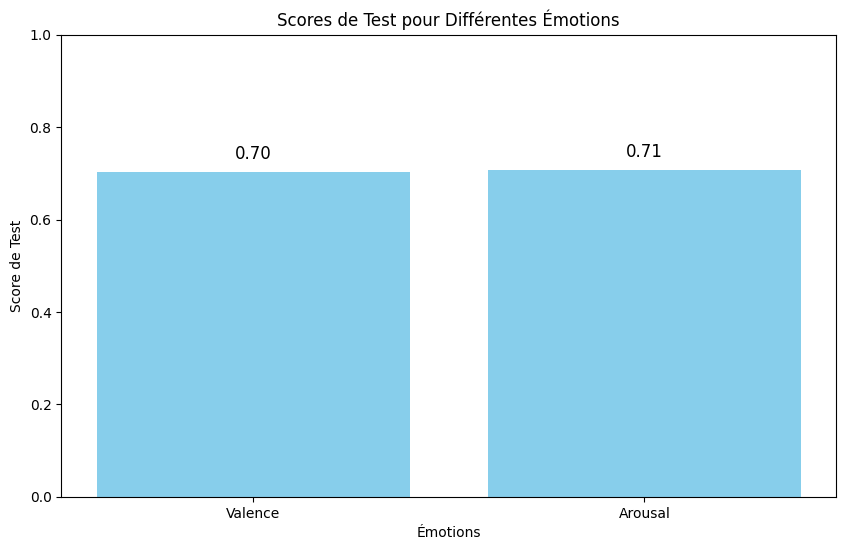

In [38]:
import matplotlib.pyplot as plt

emotions = ['Valence', 'Arousal']
testscores1 = [test_score_V_AD, test_score_A_AD]
plt.figure(figsize=(10,6))
bars = plt.bar(emotions, testscores1, color='skyblue')
plt.xlabel('Émotions')
plt.ylabel('Score de Test')
plt.title('Scores de Test pour Différentes Émotions')
plt.ylim(0, 1)

for bar, score in zip(bars, testscores1):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()

## Random Forest


## Valence

In [39]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Assume 'data_x' and 'label_y0' are defined correctly before this
# For example:
# data_x = np.random.rand(1280, 10) 
# label_y0 = np.random.randint(0, 2, 1280)

# 1. Polynomial Feature Generation
poly = preprocessing.PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_x)

# 2. Scaling
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X_poly)

# --- FIX for Data Leakage: Split the data BEFORE applying PCA ---
# We split the preprocessed (scaled) data, not the final reduced data
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, label_y0, test_size=0.2, random_state=42, stratify=label_y0
)

# 3. Principal Component Analysis
# --- FIX for ValueError: Use a ratio of variance instead of a fixed number ---
# This is the recommended approach. PCA will choose the number of components
# needed to explain 95% of the variance.
pca = PCA(n_components=0.95)

# Fit PCA ONLY on the training data
pca.fit(X_train_scaled)

# Apply the trained PCA to both train and test sets
X_train_reduced = pca.transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

print(f"Original number of features: {X_train_scaled.shape[1]}")
print(f"Number of components chosen by PCA: {pca.n_components_}")


# 4. Model Training and Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1 # Use all available CPU cores
)

# Train on the PCA-reduced training data
grid_search.fit(X_train_reduced, y_train)
best_model = grid_search.best_estimator_

print("\nMeilleurs hyperparamètres :", grid_search.best_params_)

# 5. Evaluation
train_score = best_model.score(X_train_reduced, y_train)
test_score = best_model.score(X_test_reduced, y_test)

print("Score de l’ensemble d’entraînement :", train_score)
print("Score de l’ensemble de test :", test_score)

# For a more robust estimate of performance, cross-validate the entire dataset
# Note: For a truly unbiased estimate, this cross-validation should also
# contain the PCA step inside it using a scikit-learn Pipeline.
# However, this approach is a good approximation.
X_reduced_full = pca.transform(X_scaled) # Apply PCA to the full dataset for this step
cv_scores = cross_val_score(best_model, X_reduced_full, label_y0, cv=5, scoring='accuracy')
print("\nScores de validation croisée :", cv_scores)
print("Score moyen :", cv_scores.mean())

y_pred = best_model.predict(X_test_reduced)
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

Original number of features: 10
Number of components chosen by PCA: 2

Meilleurs hyperparamètres : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Score de l’ensemble d’entraînement : 0.759765625
Score de l’ensemble de test : 0.69921875

Scores de validation croisée : [0.6875     0.703125   0.703125   0.69921875 0.703125  ]
Score moyen : 0.69921875

Matrice de confusion :
[[175   7]
 [ 70   4]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.71      0.96      0.82       182
           1       0.36      0.05      0.09        74

    accuracy                           0.70       256
   macro avg       0.54      0.51      0.46       256
weighted avg       0.61      0.70      0.61       256



## Arousal

In [40]:
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Assume 'data_x' and 'label_y1' are defined correctly before this.
# For example:
# data_x = np.random.rand(1280, 10) 
# label_y1 = np.random.randint(0, 2, 1280)

# 1. Initial Preprocessing (Polynomial Features and Scaling)
poly = preprocessing.PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_x)

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X_poly)

# --- FIX for Data Leakage: Split the data BEFORE applying PCA ---
# We split the preprocessed (scaled) data.
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, label_y1, test_size=0.2, random_state=42, stratify=label_y1
)

# 2. Principal Component Analysis (PCA)
# --- FIX for ValueError: Use a ratio of variance (e.g., 0.95) ---
# This is the recommended approach. PCA will automatically choose the number of
# components needed to explain 95% of the variance in the training data.
# This avoids the error and adapts to your data's characteristics.
pca = PCA(n_components=0.95)

# FIT PCA **ONLY** ON THE TRAINING DATA to prevent data leakage.
pca.fit(X_train_scaled)

# APPLY the trained PCA to both the training and test sets.
X_train_reduced = pca.transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

print(f"Original number of features after scaling: {X_train_scaled.shape[1]}")
print(f"Number of components chosen by PCA to preserve 95% variance: {pca.n_components_}")


# 3. Model Training and Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1 # Use all available CPU cores for faster search
)

# Train on the correctly processed and reduced training data.
grid_search.fit(X_train_reduced, y_train)
best_model = grid_search.best_estimator_

print("\nMeilleurs hyperparamètres :", grid_search.best_params_)

# 4. Evaluation
# Evaluate on the correctly transformed train and test sets.
train_score = best_model.score(X_train_reduced, y_train)
test_score = best_model.score(X_test_reduced, y_test)

print("Score de l’ensemble d’entraînement :", train_score)
print("Score de l’ensemble de test :", test_score)

# For cross-validation on the full dataset, we first transform all the data
# using the PCA that was trained ONLY on the original training set.
# This prevents data leakage during this evaluation step as well.
X_reduced_full = pca.transform(X_scaled)
cv_scores = cross_val_score(best_model, X_reduced_full, label_y1, cv=5, scoring='accuracy')
print("\nScores de validation croisée :", cv_scores)
print("Score moyen :", cv_scores.mean())

# Make predictions on the correctly transformed test set.
y_pred = best_model.predict(X_test_reduced)
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

Original number of features after scaling: 10
Number of components chosen by PCA to preserve 95% variance: 2

Meilleurs hyperparamètres : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Score de l’ensemble d’entraînement : 0.736328125
Score de l’ensemble de test : 0.69140625

Scores de validation croisée : [0.65625    0.6953125  0.68359375 0.6875     0.69921875]
Score moyen : 0.684375

Matrice de confusion :
[[175   6]
 [ 73   2]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.71      0.97      0.82       181
           1       0.25      0.03      0.05        75

    accuracy                           0.69       256
   macro avg       0.48      0.50      0.43       256
weighted avg       0.57      0.69      0.59       256



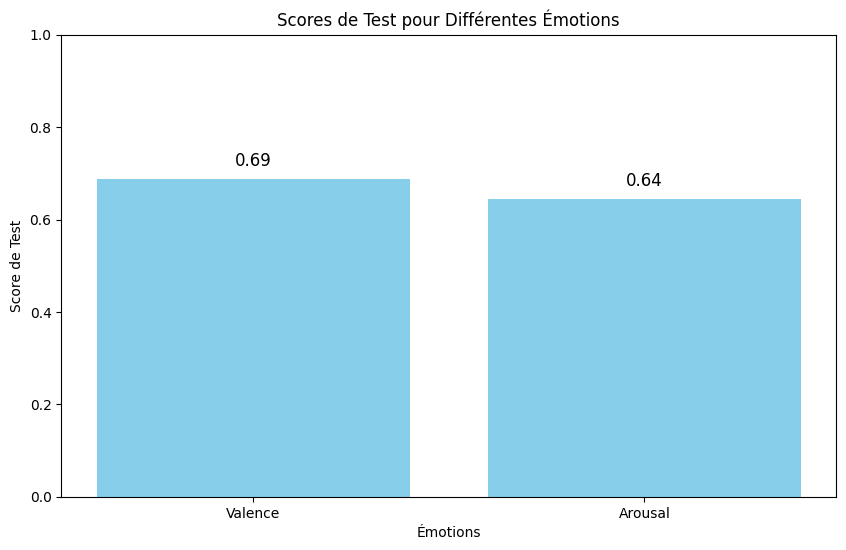

In [41]:
import matplotlib.pyplot as plt

emotions = ['Valence', 'Arousal']
testscores1 = [0.6875, 0.64453125]
plt.figure(figsize=(10,6))
bars = plt.bar(emotions, testscores1, color='skyblue')
plt.xlabel('Émotions')
plt.ylabel('Score de Test')
plt.title('Scores de Test pour Différentes Émotions')
plt.ylim(0, 1)

for bar, score in zip(bars, testscores1):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()

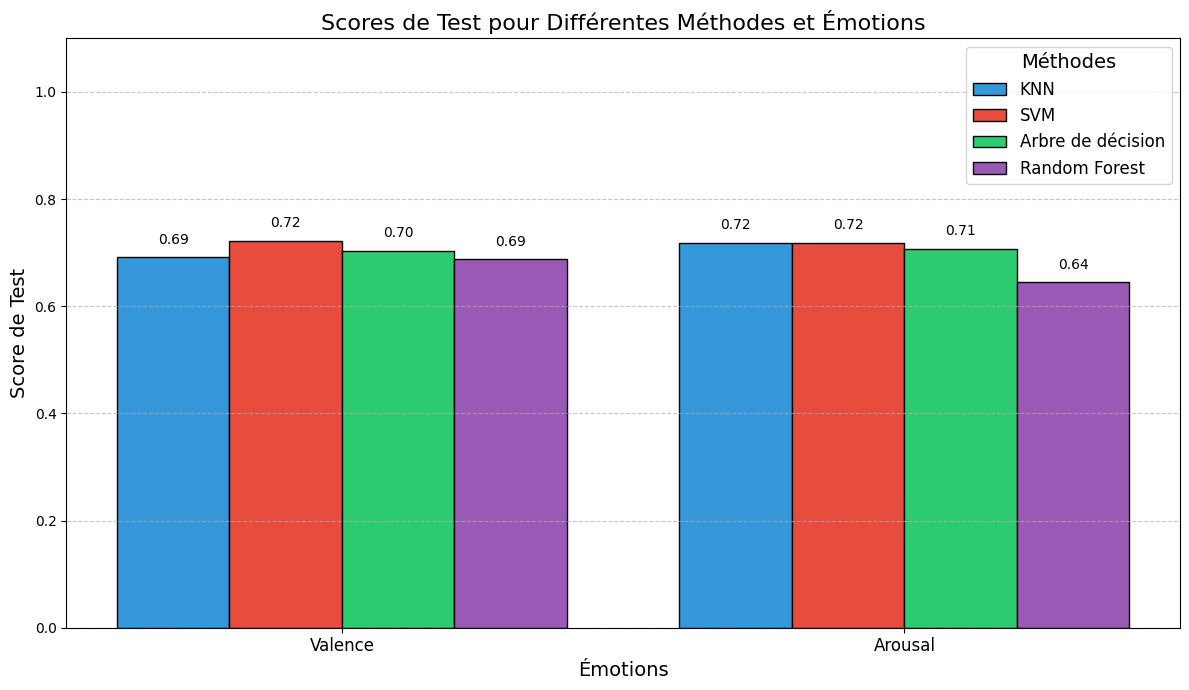

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Données
emotions = ['Valence', 'Arousal']
methods = ['KNN', 'SVM', 'Arbre de décision', 'Random Forest']
scores = {
    'KNN': [test_score_V_KNN, test_score_A_KNN],
    'SVM': [test_score_V_SVM, test_score_A_SVM],
    'Arbre de décision': [test_score_V_AD, test_score_A_AD],
    'Random Forest': [0.6875, 0.64453125]
}

# Paramètres du graphique
x = np.arange(len(emotions))
bar_width = 0.2
offsets = np.arange(len(methods)) * bar_width - (len(methods) - 1) * bar_width / 2
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']  # Couleurs des barres

plt.figure(figsize=(12, 7))

# Création des barres
for i, (method, method_scores) in enumerate(scores.items()):
    plt.bar(
        x + offsets[i],
        method_scores,
        bar_width,
        label=method,
        color=colors[i],
        edgecolor='black'  # Bordures noires pour chaque barre
    )

# Configuration des axes
plt.xticks(x, emotions, fontsize=12)
plt.xlabel('Émotions', fontsize=14)
plt.ylabel('Score de Test', fontsize=14)
plt.title('Scores de Test pour Différentes Méthodes et Émotions', fontsize=16)
plt.ylim(0, 1.1)  # Laisser de l'espace au-dessus des barres

# Ajout des annotations
for i, (method, method_scores) in enumerate(scores.items()):
    for j, score in enumerate(method_scores):
        plt.text(
            x[j] + offsets[i],
            score + 0.02,
            f'{score:.2f}',
            ha='center',
            va='bottom',
            fontsize=10,
            color='black'
        )

# Ajout de la légende
plt.legend(title='Méthodes', fontsize=12, title_fontsize=14)

# Optimisation de l'affichage
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Grille horizontale pour faciliter la lecture
plt.tight_layout()

# Affichage
plt.show()